In [2]:
import numpy as np
import pandas as pd
import h5py
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import geopandas as gpd
import matplotlib.dates as md
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats
from sklearn.linear_model import LinearRegression

In [3]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [4]:
DAY22 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220602_R0_L1_20230701T094923.ict')
start_index = np.where(DAY22["Time_Start"] == pd.to_datetime("2022-06-02 12:58:55"))
stop_index = np.where(DAY22["Time_Start"] == pd.to_datetime("2022-06-02 13:10:00"))

DAY22_subset = DAY22[start_index[0][0]:stop_index[0][0]]

# Print the modified subset dataframe
DAY22_subset


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
5981,2022-06-02 12:58:55,2022-06-02 12:58:56,32.901061,-69.417865,115.705,NaN,NaN,NaN,15.9,4.804000e-08,13.400,57.15,16.970,1.435,1.270,NaN
5982,2022-06-02 12:58:56,2022-06-02 12:58:57,32.901505,-69.416658,115.605,NaN,NaN,NaN,15.9,1.154000e-07,14.065,57.20,16.655,1.235,1.275,NaN
5983,2022-06-02 12:58:57,2022-06-02 12:58:58,32.901950,-69.415451,114.775,NaN,NaN,NaN,15.6,0.000000e+00,14.460,57.20,16.495,1.245,1.275,NaN
5984,2022-06-02 12:58:58,2022-06-02 12:58:59,32.902395,-69.414241,113.025,NaN,NaN,NaN,15.6,1.306000e-07,14.395,57.15,16.220,1.325,1.275,NaN
5985,2022-06-02 12:58:59,2022-06-02 12:59:00,32.902841,-69.413027,110.485,NaN,NaN,NaN,14.9,3.215000e-07,14.565,57.15,17.075,1.315,1.285,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6641,2022-06-02 13:09:55,2022-06-02 13:09:56,32.856578,-69.176604,3810.860,NaN,NaN,NaN,49.6,0.000000e+00,2.070,29.30,NaN,NaN,NaN,NaN
6642,2022-06-02 13:09:56,2022-06-02 13:09:57,32.856534,-69.174895,3811.410,NaN,NaN,NaN,49.6,0.000000e+00,1.790,29.30,NaN,NaN,NaN,NaN
6643,2022-06-02 13:09:57,2022-06-02 13:09:58,32.856492,-69.173186,3812.340,NaN,NaN,NaN,47.6,0.000000e+00,1.225,29.30,NaN,NaN,NaN,NaN
6644,2022-06-02 13:09:58,2022-06-02 13:09:59,32.856451,-69.171477,3813.680,NaN,NaN,NaN,47.6,0.000000e+00,1.235,29.30,NaN,NaN,NaN,NaN


In [5]:
nbins = 20
bins = np.linspace(DAY22_subset.GPS_Altitude_THORNHILL.min(), DAY22_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY22_subset['Bins'] = pd.cut(DAY22_subset['GPS_Altitude_THORNHILL'], bins)
DAY22_subset_median = DAY22_subset.groupby('Bins').median()
DAY22_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(105.985, 291.908]",2022-06-02 12:59:12.000,2022-06-02 12:59:13.000,32.908859,-69.397118,182.2350,NaN,NaN,NaN,15.60,7.339000e-08,14.5650,56.900,17.4750,1.2750,1.3700,NaN
"(291.908, 477.83]",2022-06-02 12:59:41.000,2022-06-02 12:59:42.000,32.934998,-69.379643,388.9450,NaN,NaN,NaN,15.50,3.609000e-08,14.1200,56.100,16.8300,1.4000,1.3750,NaN
"(477.83, 663.753]",2022-06-02 13:00:05.000,2022-06-02 13:00:06.000,32.955627,-69.395696,571.9250,NaN,NaN,NaN,17.20,3.172000e-08,13.3050,54.700,15.1900,1.3450,1.3400,NaN
"(663.753, 849.676]",2022-06-02 13:00:27.500,2022-06-02 13:00:28.500,32.955277,-69.423800,763.2650,NaN,NaN,NaN,18.50,9.583500e-09,10.5825,53.050,13.3775,1.7650,1.2075,NaN
"(849.676, 1035.599]",2022-06-02 13:00:49.500,2022-06-02 13:00:50.500,32.936339,-69.440578,944.0275,NaN,NaN,NaN,20.00,2.925500e-08,10.6725,51.375,14.2575,1.4875,1.2175,NaN
"(1035.599, 1221.522]",2022-06-02 13:01:12.000,2022-06-02 13:01:13.000,32.911789,-69.433273,1120.2100,NaN,NaN,NaN,20.00,0.000000e+00,10.5650,50.000,10.7650,1.2250,0.9100,NaN
"(1221.522, 1407.444]",2022-06-02 13:01:35.500,2022-06-02 13:01:36.500,32.900627,-69.404055,1331.2700,NaN,NaN,NaN,21.00,0.000000e+00,9.5825,48.125,9.7675,1.2450,0.8650,NaN
"(1407.444, 1593.367]",2022-06-02 13:01:59.500,2022-06-02 13:02:00.500,32.910887,-69.373075,1494.2100,NaN,NaN,NaN,22.40,6.421000e-09,9.7675,46.750,9.7100,1.0850,0.8150,NaN
"(1593.367, 1779.29]",2022-06-02 13:02:22.000,2022-06-02 13:02:23.000,32.936250,-69.364681,1682.6500,NaN,NaN,NaN,23.20,0.000000e+00,7.7750,45.400,9.2750,1.4650,0.8800,NaN


In [6]:
DAY22_subset_25 = DAY22_subset_median - DAY22_subset.groupby('Bins').quantile(.25)
DAY22_subset_25
DAY22_subset_75 = DAY22_subset.groupby('Bins').quantile(.75) - DAY22_subset_median
DAY22_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(105.985, 291.908]",0 days 00:00:08,0 days 00:00:08,0.005096,0.008789,48.51500,NaN,NaN,NaN,0.600,5.391000e-08,0.57000,0.2000,0.65500,0.10500,0.01500,NaN
"(291.908, 477.83]",0 days 00:00:06,0 days 00:00:06,0.006425,0.000766,40.48000,NaN,NaN,NaN,0.400,6.481000e-08,1.88500,0.2000,2.46000,0.09000,0.01000,NaN
"(477.83, 663.753]",0 days 00:00:05.500000,0 days 00:00:05.500000,0.001940,0.006010,49.47000,NaN,NaN,NaN,1.550,3.086000e-08,0.56250,0.3750,1.21750,0.18250,0.02250,NaN
"(663.753, 849.676]",0 days 00:00:05.250000128,0 days 00:00:05.250000128,0.002122,0.006326,38.95250,NaN,NaN,NaN,0.200,3.757400e-08,3.22750,0.4375,1.04500,0.26125,0.00625,NaN
"(849.676, 1035.599]",0 days 00:00:05.250000128,0 days 00:00:05.250000128,0.005637,0.001915,40.55375,NaN,NaN,NaN,0.450,2.014500e-08,1.34500,0.3000,0.98375,0.07875,0.04250,NaN
"(1035.599, 1221.522]",0 days 00:00:05.500000,0 days 00:00:05.500000,0.005465,0.005521,46.84500,NaN,NaN,NaN,0.800,2.270500e-08,1.37000,0.2750,1.37750,0.27500,0.08250,NaN
"(1221.522, 1407.444]",0 days 00:00:05.749999872,0 days 00:00:05.749999872,0.000862,0.008256,30.42500,NaN,NaN,NaN,1.600,7.483000e-09,0.35375,0.4000,1.37125,0.10250,0.04000,NaN
"(1407.444, 1593.367]",0 days 00:00:05.749999872,0 days 00:00:05.749999872,0.005764,0.004713,45.85500,NaN,NaN,NaN,1.425,3.651150e-08,1.04500,0.1500,0.89500,0.25375,0.05500,NaN
"(1593.367, 1779.29]",0 days 00:00:05,0 days 00:00:05,0.005791,0.000575,46.45000,NaN,NaN,NaN,2.100,2.435000e-08,1.39500,0.3000,0.89000,0.36500,0.01500,NaN


In [7]:
DAY2 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220602_R0_L1_20230701T094923.ict')
start_index = np.where(DAY2["Time_Start"] == pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"] == pd.to_datetime("2022-06-02 14:11:00"))

DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]
DAY2_subset



,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,NaN,NaN,NaN,34.5,0.0,3.965,42.10,4.77,0.99,0.415,NaN
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,NaN,NaN,NaN,33.1,0.0,5.820,42.05,4.77,0.99,0.395,NaN
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,NaN,NaN,NaN,33.1,0.0,6.380,42.00,4.89,0.82,0.425,NaN
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,NaN,NaN,NaN,33.0,0.0,5.975,42.00,4.89,0.82,0.450,NaN
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,NaN,NaN,NaN,33.0,0.0,6.920,42.00,9.38,1.02,0.440,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10301,2022-06-02 14:10:55,2022-06-02 14:10:56,32.264343,-65.038703,3176.07,NaN,NaN,NaN,55.7,0.0,1.795,31.20,NaN,NaN,NaN,NaN
10302,2022-06-02 14:10:56,2022-06-02 14:10:57,32.263327,-65.039317,3180.14,NaN,NaN,NaN,55.7,0.0,2.410,31.20,NaN,NaN,NaN,NaN
10303,2022-06-02 14:10:57,2022-06-02 14:10:58,32.262289,-65.039886,3184.23,NaN,NaN,NaN,54.2,0.0,2.415,31.10,NaN,NaN,NaN,NaN
10304,2022-06-02 14:10:58,2022-06-02 14:10:59,32.261232,-65.040413,3188.41,NaN,NaN,NaN,54.2,0.0,2.640,31.00,NaN,NaN,NaN,NaN


In [8]:
nbins = 20
bins = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins)
DAY2_subset_median = DAY2_subset.groupby('Bins').median()
DAY2_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(106.28, 260.607]",2022-06-02 13:58:07.000,2022-06-02 13:58:08.000,32.212884,-65.048915,129.9950,NaN,NaN,NaN,19.50,1.052000e-07,11.3500,54.200,16.3100,1.4800,1.4150,NaN
"(260.607, 414.935]",2022-06-02 13:59:23.500,2022-06-02 13:59:24.500,32.243630,-64.982119,312.9625,NaN,NaN,NaN,20.00,1.100000e-07,11.4050,53.400,16.6525,1.4575,1.4450,NaN
"(414.935, 569.262]",2022-06-02 13:55:05.000,2022-06-02 13:55:06.000,32.276937,-65.274051,449.9600,NaN,NaN,NaN,18.20,1.069000e-07,10.9900,51.900,17.9750,1.5850,1.5400,NaN
"(569.262, 723.59]",2022-06-02 14:00:59.500,2022-06-02 14:01:00.500,32.264739,-65.037435,658.1225,NaN,NaN,NaN,19.00,3.754500e-08,9.4600,50.575,14.5375,1.7850,1.5725,NaN
"(723.59, 877.917]",2022-06-02 14:01:34.500,2022-06-02 14:01:35.500,32.232674,-65.025610,784.5150,NaN,NaN,NaN,20.20,2.188000e-08,9.2975,49.500,14.8225,1.7025,1.6200,NaN
"(877.917, 1032.245]",2022-06-02 14:02:06.000,2022-06-02 14:02:07.000,32.231287,-64.985946,966.0450,NaN,NaN,NaN,21.00,1.927000e-08,7.7350,48.300,12.4250,1.7400,1.5750,NaN
"(1032.245, 1186.572]",2022-06-02 14:02:34.500,2022-06-02 14:02:35.500,32.256490,-64.955171,1107.9450,NaN,NaN,NaN,23.40,6.295500e-09,7.4450,46.950,10.1300,1.5925,1.4250,NaN
"(1186.572, 1340.9]",2022-06-02 14:03:11.500,2022-06-02 14:03:12.500,32.285203,-64.967662,1259.7850,NaN,NaN,NaN,24.50,0.000000e+00,6.1125,45.200,8.4300,1.5950,1.0575,NaN
"(1340.9, 1495.227]",2022-06-02 14:03:46.500,2022-06-02 14:03:47.500,32.287492,-65.008714,1410.3050,NaN,NaN,NaN,26.30,0.000000e+00,5.7000,43.850,8.8650,1.4325,0.9600,NaN


In [9]:
DAY2_subset_25 = DAY2_subset_median - DAY2_subset.groupby('Bins').quantile(.25)
DAY2_subset_25
DAY2_subset_75 = DAY2_subset.groupby('Bins').quantile(.75) - DAY2_subset_median
DAY2_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(106.28, 260.607]",0 days 00:00:38,0 days 00:00:38,0.011386,0.045676,43.15500,NaN,NaN,NaN,0.600,5.730000e-08,1.32000,0.200,0.98000,0.24500,0.04000,NaN
"(260.607, 414.935]",0 days 00:00:15.250000128,0 days 00:00:15.250000128,0.004031,0.007064,36.90000,NaN,NaN,NaN,0.575,6.140000e-08,1.57625,0.400,1.79875,0.22000,0.10250,NaN
"(414.935, 569.262]",0 days 00:01:06.500000,0 days 00:01:06.500000,0.014650,0.088544,32.04750,NaN,NaN,NaN,0.700,9.725000e-08,1.09750,0.225,1.49750,0.19750,0.05250,NaN
"(569.262, 723.59]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.046041,0.002170,32.76375,NaN,NaN,NaN,1.225,4.694000e-08,0.87875,0.600,2.93875,0.16250,0.13375,NaN
"(723.59, 877.917]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.083007,0.015434,39.46500,NaN,NaN,NaN,0.800,3.572000e-08,0.83500,0.300,2.27625,0.34875,0.12625,NaN
"(877.917, 1032.245]",0 days 00:00:09.500000,0 days 00:00:09.500000,0.089212,0.011983,29.57500,NaN,NaN,NaN,1.400,2.338000e-08,0.82250,0.400,0.96500,0.22250,0.06750,NaN
"(1032.245, 1186.572]",0 days 00:00:11.749999872,0 days 00:00:11.749999872,0.067394,0.006049,36.28750,NaN,NaN,NaN,0.750,1.824450e-08,1.19375,0.650,1.33500,0.33125,0.04000,NaN
"(1186.572, 1340.9]",0 days 00:00:12.749999872,0 days 00:00:12.749999872,0.012262,0.012110,40.45500,NaN,NaN,NaN,1.400,1.133500e-08,1.26000,0.600,1.85250,0.34500,0.14500,NaN
"(1340.9, 1495.227]",0 days 00:00:11.250000128,0 days 00:00:11.250000128,0.042959,0.012559,35.74500,NaN,NaN,NaN,2.900,8.471750e-09,0.84625,0.350,1.47625,0.34250,0.34625,NaN


In [10]:
DAY2b = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220602_R0_L2_20230701T094923.ict')
start_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
DAY2b_subset = DAY2b[start_index[0][0]:stop_index[0][0]]
DAY2b_subset = DAY2b_subset.replace(-888888, 0)
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,1.9318,0.0876,NaN,20.4,1.652000e-08,11.495,53.0,15.040,1.330,1.360,NaN
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,NaN,0.0876,NaN,20.4,1.205000e-07,10.000,53.1,18.195,1.945,1.330,NaN
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,1.9319,0.0902,421.12,19.9,4.715000e-07,10.070,53.2,19.045,2.065,1.320,NaN
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,NaN,0.0902,NaN,19.9,1.111000e-08,11.740,53.2,17.035,1.530,1.340,NaN
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,1.9321,NaN,421.14,19.7,2.149000e-07,12.590,53.2,17.520,1.390,1.365,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,1.9283,NaN,421.46,49.4,0.000000e+00,3.700,31.4,NaN,NaN,NaN,NaN
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,1.9283,0.0777,NaN,50.8,0.000000e+00,3.385,31.4,NaN,NaN,NaN,NaN
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,NaN,0.0777,421.45,50.8,0.000000e+00,3.170,31.4,NaN,NaN,NaN,NaN
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,1.9278,0.0782,421.45,53.0,0.000000e+00,2.195,31.4,NaN,NaN,NaN,NaN


In [11]:
nbins = 20
bins = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins)
DAY2b_subset_median = DAY2b_subset.groupby('Bins').median()
DAY2b_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(132.5, 311.083]",2022-06-02 18:36:45.500,2022-06-02 18:36:46.500,32.282614,-65.035667,191.1225,1.93150,0.08610,421.190,19.40,6.332000e-08,10.8225,53.600,14.450,1.4025,1.3400,NaN
"(311.083, 489.666]",2022-06-02 18:38:01.500,2022-06-02 18:38:02.500,32.240532,-64.982618,384.2900,1.93180,0.08550,421.250,18.80,0.000000e+00,7.8325,51.150,9.330,1.4525,1.1675,NaN
"(489.666, 668.249]",2022-06-02 18:39:05.000,2022-06-02 18:39:06.000,32.290858,-64.989390,561.4700,1.93180,0.08580,421.290,17.00,6.536000e-09,8.6200,49.000,10.140,1.1600,1.1750,NaN
"(668.249, 846.832]",2022-06-02 18:40:07.000,2022-06-02 18:40:08.000,32.258643,-65.021762,753.5350,1.93165,0.08480,421.320,19.10,7.934000e-09,6.7400,47.300,8.340,1.4350,1.0800,NaN
"(846.832, 1025.415]",2022-06-02 18:41:01.500,2022-06-02 18:41:02.500,32.250738,-64.962283,940.4200,1.93250,0.08750,421.320,20.80,7.819500e-09,6.6125,46.100,8.210,1.2775,1.1800,NaN
"(1025.415, 1203.998]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.299232,-64.954250,1111.9950,NaN,NaN,NaN,NaN,0.000000e+00,6.5125,45.200,7.365,1.3950,0.9000,NaN
"(1203.998, 1382.581]",2022-06-02 18:42:45.500,2022-06-02 18:42:46.500,32.290507,-65.005753,1271.8950,1.93460,0.08440,421.400,27.90,0.000000e+00,5.5925,43.925,6.785,0.9600,0.5975,NaN
"(1382.581, 1561.164]",2022-06-02 18:43:40.500,2022-06-02 18:43:41.500,32.247731,-64.973601,1479.7500,1.93330,0.08380,421.440,29.00,0.000000e+00,4.7000,42.400,5.760,1.1700,0.3975,NaN
"(1561.164, 1739.747]",2022-06-02 18:44:32.000,2022-06-02 18:44:33.000,32.272387,-64.918661,1659.9700,1.93760,0.08500,421.470,35.70,0.000000e+00,4.8800,41.000,5.125,1.0900,0.3075,NaN


In [12]:
DAY2b_subset_25 = DAY2b_subset_median - DAY2b_subset.groupby('Bins').quantile(.25)
DAY2b_subset_25
DAY2b_subset_75 = DAY2b_subset.groupby('Bins').quantile(.75) - DAY2b_subset_median
DAY2b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(132.5, 311.083]",0 days 00:00:22.250000128,0 days 00:00:22.250000128,0.021885,0.008480,43.36750,0.000100,0.002250,0.0325,0.600,5.023000e-08,0.90000,0.1000,1.54875,0.17625,0.03375,NaN
"(311.083, 489.666]",0 days 00:00:15.250000128,0 days 00:00:15.250000128,0.012638,0.012445,42.35625,0.000200,0.002000,0.0200,0.800,2.695750e-08,0.87750,1.4250,2.39125,0.12000,0.02625,NaN
"(489.666, 668.249]",0 days 00:00:16,0 days 00:00:16,0.003499,0.014844,53.97500,0.000000,0.002000,0.0150,0.500,1.977400e-08,0.67500,0.3000,1.04000,0.41500,0.05500,NaN
"(668.249, 846.832]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.013503,0.012284,48.51000,0.000350,0.002800,0.0100,1.300,1.958100e-08,0.87750,0.3750,2.23500,0.16500,0.07750,NaN
"(846.832, 1025.415]",0 days 00:00:12.250000128,0 days 00:00:12.250000128,0.009892,0.010450,29.91000,0.000300,0.002800,0.0200,0.700,2.515800e-08,0.88500,0.1000,0.70500,0.11875,0.07375,NaN
"(1025.415, 1203.998]",0 days 00:00:12.749999872,0 days 00:00:12.749999872,0.007259,0.007432,41.51750,NaN,NaN,NaN,NaN,8.984500e-09,0.68750,0.3000,0.74250,0.18250,0.05000,NaN
"(1203.998, 1382.581]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.011389,0.007551,54.45250,0.000200,0.002975,0.0100,0.700,9.012750e-09,1.18750,0.2750,0.79250,0.27000,0.10125,NaN
"(1382.581, 1561.164]",0 days 00:00:13.749999872,0 days 00:00:13.749999872,0.003726,0.018331,40.32000,0.000250,0.002200,0.0175,1.100,6.190000e-10,0.42125,0.4625,1.23000,0.50000,0.07750,NaN
"(1561.164, 1739.747]",0 days 00:00:11.500000,0 days 00:00:11.500000,0.011928,0.004221,46.63500,0.001200,0.001300,0.0700,0.600,1.247500e-09,1.06250,0.3000,4.24250,0.12500,0.07125,NaN


In [13]:
DAY3 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220603_R0_20230701T094924.ict')
start_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 13:30:00"))
stop_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 15:00:00"))
    
DAY3_subset = DAY3[start_index[0][0]:stop_index[0][0]]
DAY3_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
2467,2022-06-03 13:30:00,2022-06-03 13:30:01,33.872982,-67.052387,2858.90,NaN,0.0833,NaN,49.2,0.0,3.390,35.95,NaN,NaN,NaN,NaN
2468,2022-06-03 13:30:01,2022-06-03 13:30:02,33.872534,-67.053832,2861.55,1.9277,NaN,421.39,49.2,0.0,2.665,35.90,NaN,NaN,NaN,NaN
2469,2022-06-03 13:30:02,2022-06-03 13:30:03,33.872086,-67.055272,2863.82,1.9277,0.0763,NaN,50.9,0.0,2.950,35.90,NaN,NaN,NaN,NaN
2470,2022-06-03 13:30:03,2022-06-03 13:30:04,33.871638,-67.056704,2865.57,NaN,0.0763,NaN,50.9,0.0,3.125,35.90,NaN,NaN,NaN,NaN
2471,2022-06-03 13:30:04,2022-06-03 13:30:05,33.871187,-67.058127,2866.59,1.9275,0.0823,421.33,55.3,0.0,3.060,35.80,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7862,2022-06-03 14:59:55,2022-06-03 14:59:56,32.712767,-65.244314,2413.61,NaN,0.0779,NaN,27.2,0.0,1.240,36.50,NaN,NaN,NaN,NaN
7863,2022-06-03 14:59:56,2022-06-03 14:59:57,32.712103,-65.243151,2408.15,1.9293,0.0728,421.00,26.5,0.0,0.930,36.50,NaN,NaN,NaN,NaN
7864,2022-06-03 14:59:57,2022-06-03 14:59:58,32.711441,-65.241989,2402.02,NaN,0.0728,NaN,26.5,0.0,0.140,36.50,NaN,NaN,NaN,NaN
7865,2022-06-03 14:59:58,2022-06-03 14:59:59,32.710779,-65.240827,2395.43,1.9290,NaN,420.96,24.9,0.0,0.165,36.50,NaN,NaN,NaN,NaN


In [14]:
nbins = 20
bins = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins)
DAY3_subset_median = DAY3_subset.groupby('Bins').median()
DAY3_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(94.825, 370.151]",2022-06-03 13:49:57.000,2022-06-03 13:49:58.000,34.115487,-67.206434,131.235,1.9289,0.08540,421.220,14.00,4.795000e-08,10.9650,56.4,14.3250,1.3100,1.4750,1.4100
"(370.151, 645.478]",2022-06-03 14:09:49.000,2022-06-03 14:09:50.000,34.173190,-67.281351,498.600,1.9291,0.08405,421.210,15.00,6.502000e-08,12.2050,52.8,18.7700,1.5350,1.3750,1.5400
"(645.478, 920.804]",2022-06-03 14:22:42.000,2022-06-03 14:22:43.000,34.202326,-67.234070,863.570,1.9301,0.08240,421.120,18.80,1.198000e-08,9.9650,46.6,12.2800,1.4400,1.0650,1.5700
"(920.804, 1196.13]",2022-06-03 14:18:42.500,2022-06-03 14:18:43.500,34.026322,-67.536288,936.840,1.9293,0.08220,421.110,18.45,3.202500e-09,9.3275,46.6,11.2150,1.3775,1.0200,1.5700
"(1196.13, 1471.456]",2022-06-03 14:25:43.000,2022-06-03 14:25:44.000,34.283647,-67.030360,1327.480,1.9311,0.08055,421.230,27.20,0.000000e+00,5.6400,44.1,7.0150,1.1800,0.4450,NaN
"(1471.456, 1746.782]",2022-06-03 14:29:51.000,2022-06-03 14:29:52.000,34.175179,-67.254158,1555.080,1.9532,0.09185,421.410,51.00,0.000000e+00,7.4500,37.9,7.9650,1.0700,0.8200,1.5100
"(1746.782, 2022.109]",2022-06-03 13:32:08.500,2022-06-03 13:32:09.500,33.812818,-67.042618,1886.845,1.9517,0.09385,421.365,53.60,2.973500e-09,7.8700,35.4,9.6675,1.1275,1.1000,1.2000
"(2022.109, 2297.435]",2022-06-03 13:31:37.500,2022-06-03 13:31:38.500,33.799565,-67.081631,2149.580,1.9481,0.09400,421.260,53.20,0.000000e+00,8.6675,34.2,10.9500,1.2500,1.1525,1.4900
"(2297.435, 2572.761]",2022-06-03 14:34:40.500,2022-06-03 14:34:41.500,33.820365,-67.095526,2450.625,1.9440,0.08790,420.940,48.10,0.000000e+00,6.4100,36.2,8.7150,1.1600,0.8500,NaN


In [15]:
DAY3_subset_25 = DAY3_subset_median - DAY3_subset.groupby('Bins').quantile(.25)
DAY3_subset_25
DAY3_subset_75 = DAY3_subset.groupby('Bins').quantile(.75) - DAY3_subset_median
DAY3_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(94.825, 370.151]",0 days 00:07:29,0 days 00:07:29,0.115971,0.077436,113.6500,0.000200,0.001900,0.0300,0.700,4.126000e-08,0.86500,0.30,1.28500,0.15000,0.09000,0.07500
"(370.151, 645.478]",0 days 00:02:42.500000,0 days 00:02:42.500000,0.080624,0.190818,8.7725,0.000300,0.001850,0.0400,1.100,9.374300e-07,2.88000,0.20,7.14750,0.20250,0.10000,0.19875
"(645.478, 920.804]",0 days 00:01:15.500000,0 days 00:01:15.500000,0.059937,0.094632,43.5000,0.000700,0.001950,0.0600,1.800,3.767500e-08,1.89000,1.30,4.29500,0.23500,0.14000,0.37000
"(920.804, 1196.13]",0 days 00:02:38.250000128,0 days 00:02:38.250000128,0.101843,0.208143,54.4625,0.000800,0.001800,0.0625,3.050,3.191250e-08,2.02500,0.60,2.71500,0.28250,0.10375,0.18000
"(1196.13, 1471.456]",0 days 00:00:22.500000,0 days 00:00:22.500000,0.010911,0.025582,54.5850,0.000300,0.001900,0.1375,2.900,0.000000e+00,0.96500,1.45,1.31000,0.10000,0.13750,NaN
"(1471.456, 1746.782]",0 days 00:01:57,0 days 00:01:57,0.085818,0.140580,12.2200,0.001475,0.003250,0.0900,1.800,7.869000e-09,1.71500,0.70,1.63500,0.22625,0.37000,0.03250
"(1746.782, 2022.109]",0 days 01:01:47.250000128,0 days 01:01:47.250000128,0.207986,0.016846,69.3600,0.001150,0.003900,0.1175,1.750,9.494000e-09,1.80750,1.40,2.75250,0.16375,0.14250,0.08750
"(2022.109, 2297.435]",0 days 01:02:40.250000128,0 days 01:02:40.250000128,0.204335,0.016025,65.3625,0.004750,0.003950,0.7400,1.800,8.679500e-09,1.34750,2.30,2.26500,0.23500,0.41625,0.01750
"(2297.435, 2572.761]",0 days 00:24:57.250000128,0 days 00:24:57.250000128,0.165831,1.830987,63.3725,0.001500,0.002300,0.8800,7.050,2.959000e-09,2.16375,0.10,1.28250,0.14500,0.34250,NaN


In [16]:
DAY7 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220607_R0_L1_20230701T094925.ict')
start_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:48:00"))
    
DAY7_subset =DAY7[start_index[0][0]:stop_index[0][0]]
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,1.9870,0.1102,419.09,48.9,2.102000e-07,21.160,44.75,23.725,1.245,0.615,NaN
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,NaN,0.1102,NaN,48.9,6.026000e-08,21.545,44.80,25.105,1.395,0.620,NaN
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,1.9875,NaN,419.11,48.6,1.223000e-07,20.920,44.80,24.600,1.520,0.625,NaN
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,1.9875,0.1097,NaN,48.6,8.455000e-08,18.410,44.75,21.780,1.535,0.635,NaN
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,NaN,0.1097,NaN,49.4,2.812000e-07,19.490,44.75,22.860,1.445,0.640,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11352,2022-06-07 14:47:55,2022-06-07 14:47:56,32.223583,-64.933389,3141.930,NaN,0.0918,NaN,47.8,0.000000e+00,0.010,29.10,NaN,NaN,NaN,NaN
11353,2022-06-07 14:47:56,2022-06-07 14:47:57,32.222625,-64.932625,3139.810,1.9643,NaN,420.19,49.7,0.000000e+00,-0.390,29.10,NaN,NaN,NaN,NaN
11354,2022-06-07 14:47:57,2022-06-07 14:47:58,32.221687,-64.931820,3135.420,1.9643,0.0915,NaN,49.7,2.382000e-09,-1.100,29.10,NaN,NaN,NaN,NaN
11355,2022-06-07 14:47:58,2022-06-07 14:47:59,32.220775,-64.930970,3129.020,NaN,0.0915,420.13,54.9,6.143000e-09,-0.530,29.10,NaN,NaN,NaN,NaN


In [17]:
nbins = 20
bins = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins)
DAY7_subset_median = DAY7_subset.groupby('Bins').median()
DAY7_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(125.87, 276.673]",2022-06-07 14:32:33.500,2022-06-07 14:32:34.500,32.223139,-64.977351,195.4200,1.98760,0.10960,419.110,49.90,2.089000e-07,20.4875,44.750,24.4475,1.4125,0.7275,NaN
"(276.673, 427.476]",2022-06-07 14:33:35.500,2022-06-07 14:33:36.500,32.182262,-65.016874,345.3350,1.98730,0.10720,419.140,50.10,2.223000e-07,20.6000,44.500,25.4775,1.4650,0.8150,NaN
"(427.476, 578.279]",2022-06-07 14:34:37.500,2022-06-07 14:34:38.500,32.224276,-65.045420,505.4775,1.98755,0.10670,419.220,49.40,2.209500e-07,20.6325,44.200,26.9725,1.4425,0.7700,NaN
"(578.279, 729.082]",2022-06-07 14:35:42.000,2022-06-07 14:35:43.000,32.221607,-64.984099,654.7950,1.98730,0.10830,419.200,50.20,2.771000e-07,21.9350,43.900,30.5800,1.4550,0.7200,NaN
"(729.082, 879.885]",2022-06-07 14:36:44.000,2022-06-07 14:36:45.000,32.174009,-65.012042,804.0350,1.98620,0.10670,419.345,50.70,1.604000e-07,18.3300,43.150,25.7500,1.5150,0.9900,NaN
"(879.885, 1030.688]",2022-06-07 14:37:43.500,2022-06-07 14:37:44.500,32.202478,-65.062934,952.2700,1.98210,0.10310,419.630,49.80,4.763500e-08,15.0500,41.275,18.6050,1.5050,1.0725,NaN
"(1030.688, 1181.491]",2022-06-07 14:38:40.000,2022-06-07 14:38:41.000,32.250023,-65.042979,1101.7100,1.97550,0.09990,419.865,46.40,8.951000e-08,15.3850,40.000,21.5650,1.6100,0.8150,NaN
"(1181.491, 1332.294]",2022-06-07 14:39:32.000,2022-06-07 14:39:33.000,32.237482,-64.988708,1254.3900,1.97560,0.10050,420.140,49.00,3.888000e-09,14.3300,39.800,17.3600,1.5750,0.8350,NaN
"(1332.294, 1483.097]",2022-06-07 14:40:22.000,2022-06-07 14:40:23.000,32.189567,-64.999138,1414.0100,1.97850,0.10200,420.625,56.60,0.000000e+00,5.0050,35.950,7.8900,1.2750,-0.0950,NaN


In [18]:
DAY7_subset_25 = DAY7_subset_median - DAY7_subset.groupby('Bins').quantile(.25)
DAY7_subset_25
DAY7_subset_75 = DAY7_subset.groupby('Bins').quantile(.75) - DAY7_subset_median
DAY7_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(125.87, 276.673]",0 days 00:00:16.250000128,0 days 00:00:16.250000128,0.015576,0.003690,60.03125,0.000300,0.001200,0.0300,1.000,1.117750e-07,0.99125,0.050,1.04625,0.10625,0.0575,NaN
"(276.673, 427.476]",0 days 00:00:14.250000128,0 days 00:00:14.250000128,0.003931,0.017582,46.70000,0.000275,0.001500,0.0100,0.900,7.447500e-08,1.10500,0.100,0.79375,0.17375,0.0150,NaN
"(427.476, 578.279]",0 days 00:00:16.250000128,0 days 00:00:16.250000128,0.010500,0.012931,39.65000,0.000450,0.001550,0.0200,0.900,1.429000e-07,1.58125,0.000,1.37000,0.11625,0.0200,NaN
"(578.279, 729.082]",0 days 00:00:15.500000,0 days 00:00:15.500000,0.011460,0.003765,37.34750,0.000300,0.001225,0.0200,1.300,1.604500e-07,1.55500,0.100,1.69250,0.10500,0.0100,NaN
"(729.082, 879.885]",0 days 00:00:15,0 days 00:00:15,0.003998,0.016677,36.61000,0.000200,0.001025,0.0600,0.900,1.154000e-07,1.93000,0.450,1.27500,0.14500,0.0400,NaN
"(879.885, 1030.688]",0 days 00:00:14.250000128,0 days 00:00:14.250000128,0.013574,0.005760,33.47875,0.001200,0.003300,0.0500,1.075,5.076750e-08,0.66250,0.525,1.41875,0.13375,0.0375,NaN
"(1030.688, 1181.491]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.003859,0.014640,39.58000,0.000500,0.001400,0.0150,1.200,4.269000e-08,1.14750,0.200,1.51000,0.13750,0.0475,NaN
"(1181.491, 1332.294]",0 days 00:00:12,0 days 00:00:12,0.009523,0.005361,38.24000,0.000300,0.003300,0.2350,2.100,5.338200e-08,1.53500,0.100,4.37500,0.24000,0.0700,NaN
"(1332.294, 1483.097]",0 days 00:00:12.500000,0 days 00:00:12.500000,0.009756,0.010269,34.12000,0.000900,0.002200,0.2350,0.900,0.000000e+00,1.04000,1.175,2.12500,0.16750,0.4350,NaN


In [19]:
DAY7b = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220607_R0_L2_20230701T094925.ict')
start_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
    
DAY7b_subset =DAY7b[start_index[0][0]:stop_index[0][0]]
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,1.9799,0.1035,NaN,36.3,4.608000e-07,NaN,47.70,NaN,NaN,NaN,NaN
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,NaN,0.1035,NaN,36.3,2.882000e-07,NaN,47.70,NaN,NaN,NaN,NaN
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,1.9799,NaN,418.71,37.8,7.440000e-07,NaN,47.70,NaN,NaN,NaN,NaN
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,NaN,0.1001,NaN,37.8,1.216000e-07,NaN,47.70,NaN,NaN,NaN,NaN
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,1.9802,NaN,418.68,38.7,2.819000e-07,NaN,47.70,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,1.9357,0.0837,421.47,54.5,0.000000e+00,NaN,29.70,NaN,NaN,NaN,NaN
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,NaN,0.0837,NaN,54.5,6.322000e-09,NaN,29.70,NaN,NaN,NaN,NaN
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,1.9355,NaN,421.43,54.5,0.000000e+00,NaN,29.70,NaN,NaN,NaN,NaN
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,NaN,0.0830,NaN,53.3,0.000000e+00,NaN,29.65,NaN,NaN,NaN,NaN


In [20]:
nbins = 20
bins = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins)
DAY7b_subset_median = DAY7b_subset.groupby('Bins').median()
DAY7b_subset_median

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(132.595, 303.26]",2022-06-07 19:08:28.000,2022-06-07 19:08:29.000,32.257846,-64.976147,210.165,1.98040,0.10215,418.570,37.10,2.068000e-07,NaN,47.60,NaN,NaN,NaN,NaN
"(303.26, 473.926]",2022-06-07 19:09:23.000,2022-06-07 19:09:24.000,32.299892,-65.003903,388.610,1.98050,0.10200,418.525,37.70,2.277000e-07,NaN,46.60,NaN,NaN,NaN,NaN
"(473.926, 644.591]",2022-06-07 19:10:16.000,2022-06-07 19:10:17.000,32.270860,-65.050200,553.840,1.98000,0.10055,418.650,37.70,2.246000e-07,NaN,46.10,NaN,NaN,NaN,NaN
"(644.591, 815.256]",2022-06-07 19:11:06.000,2022-06-07 19:11:07.000,32.236773,-65.016539,727.605,1.97980,0.10000,418.790,38.30,3.223000e-07,NaN,46.00,NaN,NaN,NaN,NaN
"(815.256, 985.921]",2022-06-07 19:11:57.000,2022-06-07 19:11:58.000,32.268496,-64.981012,894.580,1.98000,0.10250,418.750,39.20,3.154000e-07,NaN,45.50,NaN,NaN,NaN,NaN
"(985.921, 1156.586]",2022-06-07 19:12:50.000,2022-06-07 19:12:51.000,32.297975,-65.025065,1079.310,1.98120,0.10310,419.470,45.60,1.851000e-07,NaN,44.40,NaN,NaN,NaN,NaN
"(1156.586, 1327.252]",2022-06-07 19:13:46.000,2022-06-07 19:13:47.000,32.254313,-65.055631,1249.830,1.97900,0.10210,419.870,49.80,0.000000e+00,NaN,41.55,NaN,NaN,NaN,NaN
"(1327.252, 1497.917]",2022-06-07 19:14:42.000,2022-06-07 19:14:43.000,32.235256,-64.999635,1404.740,1.97670,0.10200,421.360,56.10,0.000000e+00,NaN,35.90,NaN,NaN,NaN,NaN
"(1497.917, 1668.582]",2022-06-07 19:15:35.500,2022-06-07 19:15:36.500,32.283800,-64.989856,1578.760,1.97510,0.10340,421.880,55.80,0.000000e+00,NaN,32.30,NaN,NaN,NaN,NaN


In [21]:

DAY7b_subset_25 = DAY7b_subset_median - DAY7b_subset.groupby('Bins').quantile(.25)
DAY7b_subset_25
DAY7b_subset_75 = DAY7b_subset.groupby('Bins').quantile(.75) - DAY7b_subset_median
DAY7b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(132.595, 303.26]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.013547,0.002931,37.7050,0.000100,0.002750,0.0200,0.70,1.437500e-07,NaN,0.1000,NaN,NaN,NaN,NaN
"(303.26, 473.926]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.002504,0.015890,38.4625,0.000200,0.002000,0.0575,0.90,6.130000e-08,NaN,0.2000,NaN,NaN,NaN,NaN
"(473.926, 644.591]",0 days 00:00:12.500000,0 days 00:00:12.500000,0.013278,0.003860,44.6375,0.000200,0.001650,0.1000,1.00,1.254000e-07,NaN,0.2000,NaN,NaN,NaN,NaN
"(644.591, 815.256]",0 days 00:00:12,0 days 00:00:12,0.003080,0.014534,39.2300,0.000200,0.002075,0.0200,1.70,1.734000e-07,NaN,0.0000,NaN,NaN,NaN,NaN
"(815.256, 985.921]",0 days 00:00:13,0 days 00:00:13,0.013432,0.002435,48.8150,0.000150,0.002275,0.1225,1.60,1.529000e-07,NaN,0.2000,NaN,NaN,NaN,NaN
"(985.921, 1156.586]",0 days 00:00:13,0 days 00:00:13,0.002024,0.016621,38.6100,0.000300,0.004000,0.0750,2.80,8.880000e-08,NaN,0.3000,NaN,NaN,NaN,NaN
"(1156.586, 1327.252]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.015633,0.007776,38.2500,0.002275,0.003800,0.7050,1.60,1.961000e-08,NaN,0.9000,NaN,NaN,NaN,NaN
"(1327.252, 1497.917]",0 days 00:00:13,0 days 00:00:13,0.009127,0.011747,44.8000,0.001250,0.002575,0.0650,0.50,0.000000e+00,NaN,1.1000,NaN,NaN,NaN,NaN
"(1497.917, 1668.582]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.008584,0.007586,44.5350,0.000900,0.001300,0.0400,1.30,0.000000e+00,NaN,0.7375,NaN,NaN,NaN,NaN


In [22]:
DAY8 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220608_R0_L2_20230701T094926.ict')
start_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
DAY8_subset = DAY8[start_index[0][0]:stop_index[0][0]]
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,1.9818,0.0988,NaN,34.1,1.062000e-07,12.305,47.60,12.935,0.745,0.695,NaN
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,NaN,NaN,418.21,34.1,1.730000e-08,13.010,47.60,12.770,0.730,0.715,NaN
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,1.9829,0.1013,NaN,33.8,2.844000e-08,13.885,47.65,13.065,0.855,0.730,NaN
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,NaN,0.1013,NaN,33.8,1.337000e-07,12.815,47.70,13.005,1.015,0.740,NaN
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,1.9827,NaN,418.25,34.4,9.848000e-08,12.020,47.70,12.680,1.050,0.725,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,1.9305,0.0759,421.10,42.5,0.000000e+00,0.710,32.20,NaN,NaN,NaN,1.42
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,NaN,0.0759,NaN,41.4,0.000000e+00,1.490,32.20,NaN,NaN,NaN,1.23
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,1.9307,NaN,421.12,41.4,0.000000e+00,1.835,32.20,NaN,NaN,NaN,1.15
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,1.9307,0.0781,NaN,40.3,0.000000e+00,1.920,32.20,NaN,NaN,NaN,1.24


In [23]:
nbins = 20
bins = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins)
DAY8_subset_median = DAY8_subset.groupby('Bins').median()
DAY8_subset_median
DAY8_subset_25 = DAY8_subset_median - DAY8_subset.groupby('Bins').quantile(.25)
DAY8_subset_25
DAY8_subset_75 = DAY8_subset.groupby('Bins').quantile(.75) - DAY8_subset_median
DAY8_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(147.455, 333.705]",0 days 00:00:27,0 days 00:00:27,0.007854,0.035028,64.2550,0.000250,0.002950,0.0550,0.900,9.240000e-08,0.92500,0.0000,0.92000,0.10000,0.13500,NaN
"(333.705, 519.956]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.008836,0.014153,42.6200,0.000150,0.002550,0.0200,0.875,9.160000e-08,1.49750,0.0000,1.10750,0.12125,0.03625,NaN
"(519.956, 706.206]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.014929,0.006504,44.2025,0.000125,0.002900,0.0200,0.800,5.525000e-08,1.38250,0.2000,0.50500,0.20500,0.04500,NaN
"(706.206, 892.456]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.003217,0.013764,48.1300,0.000200,0.002500,0.1175,0.600,8.170000e-08,0.89250,0.1000,1.07250,0.16500,0.07250,NaN
"(892.456, 1078.706]",0 days 00:00:15,0 days 00:00:15,0.014171,0.003605,48.4600,0.000400,0.003900,0.1400,1.200,8.143170e-05,12.03500,0.1000,30.55500,0.26000,0.38500,NaN
"(1078.706, 1264.956]",0 days 00:00:14.500000,0 days 00:00:14.500000,0.004731,0.016424,46.0750,0.002000,0.002100,0.7275,4.600,1.119000e-07,4.03750,0.4000,4.24000,0.25000,0.05000,NaN
"(1264.956, 1451.207]",0 days 00:00:16.749999872,0 days 00:00:16.749999872,0.008973,0.004759,36.2825,0.000625,0.001650,0.0550,1.200,0.000000e+00,1.08250,2.0375,4.80625,0.16500,0.16625,NaN
"(1451.207, 1637.457]",0 days 00:00:11.250000128,0 days 00:00:11.250000128,0.009496,0.006688,52.9550,0.001400,0.003500,1.0050,0.775,0.000000e+00,1.29375,0.4000,NaN,NaN,NaN,NaN
"(1637.457, 1823.707]",0 days 00:00:10.749999872,0 days 00:00:10.749999872,0.008963,0.009932,46.5500,0.001350,0.002700,0.1400,0.700,0.000000e+00,0.42500,0.0250,NaN,NaN,NaN,NaN


In [24]:
DAY10 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220610_R0_L1_20230701T094928.ict')
start_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
DAY10_subset = DAY10[start_index[0][0]:stop_index[0][0]]
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,1.9176,NaN,420.29,18.8,2.604000e-07,NaN,61.4,NaN,NaN,NaN,NaN
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,1.9176,0.0838,NaN,18.8,7.398000e-07,NaN,61.4,NaN,NaN,NaN,NaN
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,NaN,0.0838,NaN,18.0,5.723000e-07,NaN,61.4,NaN,NaN,NaN,NaN
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,1.9173,0.0837,420.26,18.0,2.257000e-07,NaN,61.4,NaN,NaN,NaN,NaN
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,NaN,0.0837,NaN,17.1,4.218000e-07,NaN,61.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,NaN,0.0818,NaN,53.2,0.000000e+00,NaN,43.2,NaN,NaN,NaN,NaN
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,NaN,NaN,421.25,53.3,0.000000e+00,NaN,43.2,NaN,NaN,NaN,NaN
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,1.9308,0.0749,NaN,53.3,1.062000e-08,NaN,43.2,NaN,NaN,NaN,NaN
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,NaN,0.0749,NaN,52.0,0.000000e+00,NaN,43.2,NaN,NaN,NaN,NaN


In [25]:
nbins = 20
bins = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins)
DAY10_subset_median = DAY10_subset.groupby('Bins').median()
DAY10_subset_median
DAY10_subset_25 = DAY10_subset_median - DAY10_subset.groupby('Bins').quantile(.25)
DAY10_subset_25
DAY10_subset_75 = DAY10_subset.groupby('Bins').quantile(.75) - DAY10_subset_median
DAY10_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(122.04, 294.274]",0 days 00:00:17,0 days 00:00:17,0.019265,0.003430,46.49000,0.000100,0.001925,0.0450,0.600,4.968000e-07,NaN,0.0500,NaN,NaN,NaN,NaN
"(294.274, 466.509]",0 days 00:00:05,0 days 00:00:05,0.003220,0.004873,42.82500,0.000300,0.002700,0.0200,0.400,4.100000e-08,NaN,0.2500,NaN,NaN,NaN,NaN
"(466.509, 638.743]",0 days 00:00:05,0 days 00:00:05,0.000502,0.006371,41.04500,0.000175,0.001450,0.0200,1.200,4.000000e-08,NaN,0.3000,NaN,NaN,NaN,NaN
"(638.743, 810.978]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.001362,0.005948,39.60000,0.002950,0.000950,0.0450,1.000,3.214500e-08,NaN,0.3500,NaN,NaN,NaN,NaN
"(810.978, 983.212]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.003760,0.004314,42.35375,0.000200,0.001550,0.0500,0.050,3.692250e-08,NaN,0.3750,NaN,NaN,NaN,NaN
"(983.212, 1155.447]",0 days 00:00:04.500000,0 days 00:00:04.500000,0.004850,0.001614,40.62500,0.000150,0.001625,0.0475,1.850,1.876000e-08,NaN,0.6750,NaN,NaN,NaN,NaN
"(1155.447, 1327.682]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.005316,0.002019,41.13500,0.000100,0.004625,0.0100,0.600,7.747500e-09,NaN,0.3625,NaN,NaN,NaN,NaN
"(1327.682, 1499.916]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.004214,0.004939,41.76500,0.000250,0.002900,0.0400,1.550,4.104500e-08,NaN,0.1000,NaN,NaN,NaN,NaN
"(1499.916, 1672.15]",0 days 00:00:05,0 days 00:00:05,0.002058,0.006995,39.61000,0.000100,0.001100,0.0600,1.500,1.964000e-08,NaN,0.0000,NaN,NaN,NaN,NaN


In [26]:
DAY110b = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220610_R0_L2_20230701T094928.ict')
start_index = np.where(DAY110b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(DAY110b["Time_Start"]==pd.to_datetime("2022-06-10 19:51:00"))
    
DAY110b_subset = DAY110b[start_index[0][0]:stop_index[0][0]]
DAY110b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,NaN,0.0849,NaN,16.3,3.528000e-08,30.540,60.1,28.345,0.870,0.630,NaN
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,NaN,NaN,420.23,16.3,3.256000e-07,30.325,60.1,30.565,0.955,0.625,NaN
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,1.9165,0.0841,420.23,15.6,3.064000e-07,30.020,60.1,30.595,0.965,0.620,NaN
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,NaN,0.0841,NaN,15.6,2.264000e-07,28.055,60.2,30.120,1.070,0.615,NaN
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,1.9161,0.0844,420.22,14.6,3.942000e-07,27.940,60.3,30.610,1.070,0.615,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8437,2022-06-10 19:50:55,2022-06-10 19:50:56,31.228702,-65.973911,4967.450,NaN,NaN,NaN,NaN,0.000000e+00,2.700,29.2,NaN,NaN,NaN,1.120
8438,2022-06-10 19:50:56,2022-06-10 19:50:57,31.227365,-65.974288,4964.110,NaN,NaN,NaN,NaN,0.000000e+00,2.040,29.2,NaN,NaN,NaN,1.070
8439,2022-06-10 19:50:57,2022-06-10 19:50:58,31.226025,-65.974659,4960.810,NaN,NaN,NaN,NaN,0.000000e+00,1.465,29.3,NaN,NaN,NaN,1.155
8440,2022-06-10 19:50:58,2022-06-10 19:50:59,31.224682,-65.975025,4957.520,NaN,NaN,NaN,NaN,0.000000e+00,1.865,29.2,NaN,NaN,NaN,1.230


In [27]:
nbins = 20
bins = np.linspace(DAY110b_subset.GPS_Altitude_THORNHILL.min(), DAY110b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY110b_subset['Bins'] = pd.cut(DAY110b_subset['GPS_Altitude_THORNHILL'], bins)
DAY110b_subset_median = DAY110b_subset.groupby('Bins').median()
DAY110b_subset_median
DAY110b_subset_25 = DAY110b_subset_median - DAY110b_subset.groupby('Bins').quantile(.25)
DAY110b_subset_25
DAY110b_subset_75 = DAY110b_subset.groupby('Bins').quantile(.75) - DAY110b_subset_median
DAY110b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(112.97, 357.058]",0 days 00:01:18,0 days 00:01:18,0.052221,0.078943,2.26500,0.000300,0.001950,0.0200,1.200,1.538000e-07,3.58000,0.200,3.19750,0.10000,0.06500,NaN
"(357.058, 601.145]",0 days 00:00:11.250000128,0 days 00:00:11.250000128,0.007922,0.011272,63.13875,0.000550,0.002400,0.0800,1.325,1.066000e-07,2.80625,0.625,1.84125,0.08625,0.00875,NaN
"(601.145, 845.233]",0 days 00:00:11.749999872,0 days 00:00:11.749999872,0.004252,0.009937,59.90500,0.000300,0.001300,0.0200,1.775,1.511750e-07,1.77750,0.375,1.19375,0.05625,0.02500,NaN
"(845.233, 1089.32]",0 days 00:00:10.749999872,0 days 00:00:10.749999872,0.009107,0.006360,56.24500,0.000650,0.002900,0.0700,0.500,1.162000e-07,2.79875,0.575,2.35500,0.09000,0.03625,NaN
"(1089.32, 1333.408]",0 days 00:00:11.500000,0 days 00:00:11.500000,0.012293,0.009116,55.20000,0.002650,0.002075,0.2300,0.650,6.955000e-08,1.92500,0.375,2.30000,0.15500,0.03250,NaN
"(1333.408, 1577.495]",0 days 00:00:08.749999872,0 days 00:00:08.749999872,0.002226,0.011545,69.47250,0.002825,0.001350,0.2700,1.650,4.796750e-08,3.34375,0.350,3.73500,0.10875,0.22000,NaN
"(1577.495, 1821.582]",0 days 00:00:09.250000128,0 days 00:00:09.250000128,0.006932,0.005957,45.91250,0.000100,0.001000,0.0575,0.500,3.649250e-08,0.78875,0.350,1.58875,0.25875,0.09625,NaN
"(1821.582, 2065.67]",0 days 00:00:11,0 days 00:00:11,0.009504,0.007338,42.74000,0.000800,0.003825,0.0600,0.700,2.042300e-08,1.20000,0.400,0.88000,0.54500,0.02500,NaN
"(2065.67, 2309.757]",0 days 00:00:09.250000128,0 days 00:00:09.250000128,0.006977,0.009989,55.74000,0.005500,0.002300,0.1100,5.275,5.750500e-09,0.77375,0.350,1.37250,0.15500,0.06000,NaN


In [28]:
DAY10b = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220610_R0_L2_20230701T094928.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:25:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:35:00"))
    
DAY10b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10482,2022-06-10 20:25:00,2022-06-10 20:25:01,31.199210,-65.892109,133.810,NaN,NaN,420.07,15.4,1.267000e-07,41.045,58.60,NaN,NaN,0.215,NaN
10483,2022-06-10 20:25:01,2022-06-10 20:25:02,31.200274,-65.891772,133.615,1.9174,0.0902,420.07,15.4,5.161000e-07,42.870,58.60,NaN,NaN,0.225,NaN
10484,2022-06-10 20:25:02,2022-06-10 20:25:03,31.201338,-65.891430,133.015,NaN,0.0902,NaN,15.3,7.293000e-08,40.815,58.50,43.290,1.03,0.235,NaN
10485,2022-06-10 20:25:03,2022-06-10 20:25:04,31.202402,-65.891083,131.855,1.9172,0.0909,419.99,15.3,0.000000e+00,38.635,58.50,40.780,1.10,0.250,NaN
10486,2022-06-10 20:25:04,2022-06-10 20:25:05,31.203466,-65.890727,130.265,NaN,0.0909,NaN,15.2,0.000000e+00,38.335,58.50,40.715,1.10,0.265,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11077,2022-06-10 20:34:55,2022-06-10 20:34:56,31.464508,-65.626679,4924.170,NaN,0.0893,NaN,60.2,0.000000e+00,1.625,30.70,NaN,NaN,NaN,NaN
11078,2022-06-10 20:34:56,2022-06-10 20:34:57,31.465555,-65.625580,4924.550,1.9459,NaN,420.26,61.0,0.000000e+00,1.225,30.70,NaN,NaN,NaN,NaN
11079,2022-06-10 20:34:57,2022-06-10 20:34:58,31.466603,-65.624479,4924.900,1.9459,0.0898,NaN,61.0,0.000000e+00,-0.315,30.65,NaN,NaN,NaN,NaN
11080,2022-06-10 20:34:58,2022-06-10 20:34:59,31.467650,-65.623378,4925.210,NaN,0.0898,420.20,60.8,0.000000e+00,-0.155,30.60,NaN,NaN,NaN,NaN


In [29]:
nbins = 20
bins = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins)
DAY10b_subset_median = DAY10b_subset.groupby('Bins').median()
DAY10b_subset_median
DAY10b_subset_25 = DAY10b_subset_median - DAY10b_subset.groupby('Bins').quantile(.25)
DAY10b_subset_25
DAY10b_subset_75 = DAY10b_subset.groupby('Bins').quantile(.75) - DAY10b_subset_median
DAY10b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(119.575, 360.352]",0 days 00:00:30.749999872,0 days 00:00:30.749999872,0.026552,0.025628,11.53625,0.000800,0.001800,0.0600,1.525,2.649750e-07,3.66625,0.6000,2.55500,0.07250,0.14250,NaN
"(360.352, 601.128]",0 days 00:00:05,0 days 00:00:05,0.005345,0.000487,63.40000,0.000375,0.001975,0.0250,0.600,5.520000e-08,1.32000,0.2500,1.73500,0.02500,0.01000,NaN
"(601.128, 841.905]",0 days 00:00:04,0 days 00:00:04,0.002334,0.003576,59.49000,0.000175,0.002150,0.0200,0.300,1.042000e-07,4.88000,0.3500,4.30500,0.12000,0.01000,NaN
"(841.905, 1082.682]",0 days 00:00:03.500000,0 days 00:00:03.500000,0.000212,0.003939,53.93000,0.000250,0.002500,0.0475,0.500,8.790000e-08,1.66250,0.3750,2.82000,0.14500,0.01250,NaN
"(1082.682, 1323.459]",0 days 00:00:03.749999872,0 days 00:00:03.749999872,0.001746,0.003474,56.76750,0.000000,0.002450,0.0600,3.025,1.011000e-07,3.03375,0.3750,1.54125,0.03500,0.03375,NaN
"(1323.459, 1564.236]",0 days 00:00:03.500000,0 days 00:00:03.500000,0.002901,0.001489,54.35500,0.001475,0.002800,0.1225,1.600,4.796500e-08,3.26000,0.3500,2.07500,0.11750,0.05500,NaN
"(1564.236, 1805.012]",0 days 00:00:05.250000128,0 days 00:00:05.250000128,0.004838,0.003293,59.75250,0.000200,0.000825,0.0150,0.000,8.994000e-08,1.01750,0.3875,0.64625,0.04000,0.04625,NaN
"(1805.012, 2045.789]",0 days 00:00:05.749999872,0 days 00:00:05.749999872,0.002513,0.007255,57.54000,0.000225,0.001700,0.0275,1.600,3.697250e-08,1.34875,0.3750,1.75500,0.06000,0.09125,NaN
"(2045.789, 2286.566]",0 days 00:00:04.749999872,0 days 00:00:04.749999872,0.001430,0.006285,55.54750,0.002125,0.001650,0.1400,3.200,0.000000e+00,0.92750,0.4250,0.89125,0.09375,0.02875,NaN


In [30]:
DAY11 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220611_R0_L1_20230701T094929.ict')
start_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
DAY11_subset = DAY11[start_index[0][0]:stop_index[0][0]]
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,NaN,0.0827,NaN,16.9,5.759000e-07,37.430,61.20,34.410,0.845,0.640,NaN
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,1.9121,NaN,420.27,16.9,9.413000e-08,35.750,61.20,37.500,0.995,0.630,NaN
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,1.9121,0.0803,NaN,18.7,5.510000e-07,29.855,61.20,35.935,1.155,0.630,NaN
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,NaN,0.0803,420.28,18.7,5.228000e-07,28.250,61.20,31.525,1.055,0.630,NaN
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,1.9127,0.0808,420.28,18.0,4.740000e-07,33.750,61.20,32.075,0.870,0.625,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,NaN,0.0847,NaN,53.3,0.000000e+00,0.780,32.60,NaN,NaN,NaN,0.885
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,1.9404,NaN,420.70,54.9,0.000000e+00,-1.310,32.60,NaN,NaN,NaN,0.920
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,1.9404,0.0844,NaN,54.9,0.000000e+00,0.205,32.60,NaN,NaN,NaN,1.040
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,NaN,NaN,420.68,55.3,0.000000e+00,2.635,32.55,NaN,NaN,NaN,1.120


In [31]:
nbins = 20
bins = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins)
DAY11_subset_median = DAY11_subset.groupby('Bins').median()
DAY11_subset_median
DAY11_subset_25 = DAY11_subset_median - DAY11_subset.groupby('Bins').quantile(.25)
DAY11_subset_25
DAY11_subset_75 = DAY11_subset.groupby('Bins').quantile(.75) - DAY11_subset_median
DAY11_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(137.295, 366.776]",0 days 00:00:38.749999872,0 days 00:00:38.749999872,0.019737,0.028329,63.0975,0.000350,0.001950,0.0500,4.100,1.837750e-07,2.27875,0.2500,1.4325,0.07125,0.12000,NaN
"(366.776, 596.256]",0 days 00:00:17,0 days 00:00:17,0.014132,0.003947,51.5150,0.000500,0.002400,0.0250,0.600,1.690000e-07,2.82000,1.0000,3.2800,0.04000,0.16500,NaN
"(596.256, 825.737]",0 days 00:00:11,0 days 00:00:11,0.007106,0.012731,69.3450,0.000100,0.001200,0.0150,0.800,2.413000e-07,1.16000,0.5000,1.1450,0.04000,0.03500,NaN
"(825.737, 1055.218]",0 days 00:00:16.500000,0 days 00:00:16.500000,0.005502,0.020452,71.6350,0.002200,0.002350,0.1000,1.200,1.922000e-07,14.53000,0.5000,12.6175,0.03500,0.03500,NaN
"(1055.218, 1284.699]",0 days 00:00:16,0 days 00:00:16,0.016132,0.004144,50.3300,0.000400,0.004100,0.0500,0.600,1.610000e-07,4.89500,0.5000,2.3250,0.07000,0.01500,NaN
"(1284.699, 1514.18]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.010896,0.014797,60.1850,0.000875,0.003100,0.0300,2.050,2.655000e-07,2.72750,0.2000,4.0975,0.03000,0.06500,NaN
"(1514.18, 1743.66]",0 days 00:00:18.250000128,0 days 00:00:18.250000128,0.005987,0.022828,64.3225,0.000675,0.001700,0.0300,0.700,1.330500e-07,4.30375,0.2000,5.5325,0.05000,0.01625,NaN
"(1743.66, 1973.141]",0 days 00:00:17.250000128,0 days 00:00:17.250000128,0.007032,0.014948,59.8675,0.000200,0.002200,0.0200,0.900,4.356000e-08,8.67750,0.3000,7.9800,0.07875,0.06000,NaN
"(1973.141, 2202.622]",0 days 00:00:20.500000,0 days 00:00:20.500000,0.012450,0.023227,47.8250,0.000300,0.001475,0.0300,1.350,2.574000e-08,1.54750,0.4000,2.1250,0.14500,0.09500,NaN


In [32]:
DAY11b = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220611_R0_L2_20230701T094929.ict')
start_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:08:00"))
stop_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:15:39"))
    
DAY11b_subset = DAY11b[start_index[0][0]:stop_index[0][0]]
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
9830,2022-06-11 20:08:00,2022-06-11 20:08:01,31.216085,-64.640552,127.335,NaN,NaN,420.27,11.7,3.566000e-07,30.185,64.0,NaN,NaN,0.390,NaN
9831,2022-06-11 20:08:01,2022-06-11 20:08:02,31.216703,-64.641627,125.935,1.9155,0.0781,420.27,10.4,4.178000e-07,28.315,64.0,NaN,NaN,0.355,NaN
9832,2022-06-11 20:08:02,2022-06-11 20:08:03,31.217282,-64.642730,124.040,NaN,0.0781,NaN,10.4,4.597000e-07,27.820,64.0,NaN,NaN,0.330,NaN
9833,2022-06-11 20:08:03,2022-06-11 20:08:04,31.217824,-64.643860,121.770,1.9152,NaN,420.34,9.6,2.936000e-07,28.645,64.0,NaN,NaN,0.325,NaN
9834,2022-06-11 20:08:04,2022-06-11 20:08:05,31.218325,-64.645014,119.225,NaN,0.0788,NaN,9.6,1.682000e-07,28.750,63.9,NaN,NaN,0.335,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10284,2022-06-11 20:15:34,2022-06-11 20:15:35,31.204221,-64.650827,2831.710,NaN,0.0759,NaN,24.8,0.000000e+00,1.575,40.8,NaN,NaN,0.200,NaN
10285,2022-06-11 20:15:35,2022-06-11 20:15:36,31.203070,-64.651345,2823.550,1.9133,0.0780,420.02,27.4,0.000000e+00,1.135,40.8,NaN,NaN,0.115,NaN
10286,2022-06-11 20:15:36,2022-06-11 20:15:37,31.201921,-64.651869,2815.510,NaN,0.0780,NaN,27.4,0.000000e+00,1.125,40.8,NaN,NaN,0.030,NaN
10287,2022-06-11 20:15:37,2022-06-11 20:15:38,31.200775,-64.652397,2808.060,1.9125,NaN,419.94,30.4,5.191000e-08,1.305,40.8,NaN,NaN,0.030,NaN


In [33]:
nbins = 20
bins = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins)
DAY11b_subset_median = DAY11b_subset.groupby('Bins').median()
DAY11b_subset_median
DAY11b_subset_25 = DAY11b_subset_median - DAY11b_subset.groupby('Bins').quantile(.25)
DAY11b_subset_25
DAY11b_subset_75 = DAY11b_subset.groupby('Bins').quantile(.75) - DAY11b_subset_median
DAY11b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(108.925, 261.267]",0 days 00:00:07.250000128,0 days 00:00:07.250000128,0.000770,0.010359,58.7275,0.000200,0.001300,0.0475,0.450,9.595000e-08,1.80625,0.3000,0.81125,0.08500,0.01375,NaN
"(261.267, 413.609]",0 days 00:00:04.500000,0 days 00:00:04.500000,0.002125,0.004829,31.8250,0.000150,0.000775,0.0300,1.150,7.480000e-08,1.83000,0.3500,0.99000,0.11000,0.00500,NaN
"(413.609, 565.952]",0 days 00:00:06.250000128,0 days 00:00:06.250000128,0.006338,0.001489,33.6925,0.000100,0.001000,0.0000,0.800,1.225000e-07,3.99125,0.5250,0.96500,0.05500,0.02000,NaN
"(565.952, 718.294]",0 days 00:00:05.749999872,0 days 00:00:05.749999872,0.001687,0.006795,29.1200,0.000250,0.002000,0.0200,1.025,1.270500e-07,4.10875,0.4750,2.18500,0.17125,0.05125,NaN
"(718.294, 870.636]",0 days 00:00:05,0 days 00:00:05,0.002913,0.004188,26.8000,0.000100,0.001200,0.0050,1.100,6.210000e-08,0.94000,0.4000,1.61000,0.11500,0.04000,NaN
"(870.636, 1022.978]",0 days 00:00:05.250000128,0 days 00:00:05.250000128,0.005519,0.000637,28.8475,0.000125,0.000400,0.0100,0.675,6.929500e-08,2.33375,0.2875,1.95125,0.09375,0.00875,NaN
"(1022.978, 1175.321]",0 days 00:00:04,0 days 00:00:04,0.002185,0.004282,34.8000,0.000175,0.001100,0.0500,0.400,1.473700e-07,1.01000,0.3500,1.24000,0.01000,0.00500,NaN
"(1175.321, 1327.663]",0 days 00:00:04,0 days 00:00:04,0.001925,0.004800,32.9200,0.000350,0.004700,0.0225,0.100,5.612000e-08,1.28000,0.3000,1.52500,0.09500,0.00500,NaN
"(1327.663, 1480.005]",0 days 00:00:03.749999872,0 days 00:00:03.749999872,0.003736,0.002654,42.1600,0.000300,0.000750,0.1550,0.450,1.057000e-07,2.17625,0.2000,1.04375,0.04875,0.05000,NaN


In [34]:
DAY13 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220613_R0_L1_20230701T094930.ict')
start_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
DAY13_subset = DAY13[start_index[0][0]:stop_index[0][0]]
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,1.9227,0.0757,NaN,13.6,1.171000e-07,8.535,60.40,9.305,1.110,0.850,NaN
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,NaN,0.0757,NaN,14.9,1.386000e-07,8.360,60.40,8.550,1.080,0.865,NaN
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,NaN,NaN,420.32,14.9,2.691000e-07,8.750,60.35,9.460,1.085,0.880,NaN
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,1.9230,0.0709,420.32,15.3,2.140000e-07,8.000,60.35,10.160,1.230,0.885,NaN
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,NaN,0.0709,NaN,15.3,2.268000e-07,8.585,60.40,11.285,1.260,0.890,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,1.9154,NaN,420.40,36.5,0.000000e+00,1.520,32.80,NaN,NaN,NaN,1.285
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,1.9154,0.0669,NaN,36.5,0.000000e+00,2.475,32.80,NaN,NaN,NaN,1.400
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,NaN,0.0669,NaN,38.0,0.000000e+00,1.985,32.80,NaN,NaN,NaN,1.440
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,1.9157,0.0739,420.35,38.0,0.000000e+00,0.410,32.80,NaN,NaN,NaN,1.410


In [35]:
nbins = 20
bins = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins)
DAY13_subset_median = DAY13_subset.groupby('Bins').median()
DAY13_subset_median
DAY13_subset_25 = DAY13_subset_median - DAY13_subset.groupby('Bins').quantile(.25)
DAY13_subset_25
DAY13_subset_75 = DAY13_subset.groupby('Bins').quantile(.75) - DAY13_subset_median
DAY13_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(138.195, 358.368]",0 days 00:00:28,0 days 00:00:28,0.030130,0.010359,112.47000,0.000400,0.001350,0.0200,0.700,1.723000e-07,0.93500,0.1000,1.61000,0.17000,0.13000,NaN
"(358.368, 578.542]",0 days 00:00:14.250000128,0 days 00:00:14.250000128,0.002181,0.019058,54.09625,0.001000,0.000875,0.0100,0.800,2.105250e-08,1.60625,0.7125,1.63875,0.14250,0.42250,NaN
"(578.542, 798.715]",0 days 00:00:14.749999872,0 days 00:00:14.749999872,0.016774,0.006472,62.55000,0.000425,0.000500,0.0600,1.500,9.681000e-08,4.66250,1.1875,5.74750,0.20375,0.04625,NaN
"(798.715, 1018.888]",0 days 00:00:14.250000128,0 days 00:00:14.250000128,0.003778,0.018661,48.48500,0.000600,0.002050,0.0100,1.275,9.540000e-08,1.41750,0.2500,1.50250,0.11375,0.03375,NaN
"(1018.888, 1239.061]",0 days 00:00:16.250000128,0 days 00:00:16.250000128,0.017967,0.003437,41.75000,0.000750,0.001700,0.0800,0.950,2.396250e-07,6.95375,0.4250,6.85000,0.05000,0.04500,NaN
"(1239.061, 1459.234]",0 days 00:00:18,0 days 00:00:18,0.003568,0.024420,38.70000,0.001300,0.002400,0.0550,0.500,2.075000e-07,6.24000,0.6000,4.68000,0.03500,0.07500,NaN
"(1459.234, 1679.408]",0 days 00:00:18.250000128,0 days 00:00:18.250000128,0.020121,0.018396,55.16250,0.000325,0.002050,0.0600,1.000,2.032250e-07,2.00000,0.6500,2.02125,0.04000,0.10000,NaN
"(1679.408, 1899.581]",0 days 00:00:17.749999872,0 days 00:00:17.749999872,0.017841,0.012524,60.04750,0.000125,0.002300,0.0500,0.625,2.157000e-07,1.48000,0.0000,1.85125,0.04875,0.01500,NaN
"(1899.581, 2119.754]",0 days 00:00:18.500000,0 days 00:00:18.500000,0.006497,0.016531,66.25000,0.000500,0.001700,0.1125,1.800,1.073000e-07,5.51000,0.2000,5.22250,0.06500,0.04750,NaN


In [36]:
DAY13b = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220613_R0_L2_20230701T094930.ict')
start_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00")) 
DAY13b_subset = DAY13b[start_index[0][0]:stop_index[0][0]]
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,1.9225,NaN,420.22,13.4,4.816000e-08,7.265,62.8,NaN,NaN,0.605,NaN
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,1.9225,0.0739,NaN,13.4,5.341000e-08,7.045,62.8,NaN,NaN,0.560,NaN
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,NaN,0.0739,NaN,13.7,1.285000e-08,8.045,62.8,NaN,NaN,0.500,NaN
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,1.9223,0.0733,420.20,13.7,0.000000e+00,8.455,62.9,NaN,NaN,0.480,NaN
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,NaN,0.0733,NaN,11.9,1.368000e-07,8.765,62.9,NaN,NaN,0.415,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,NaN,NaN,NaN,43.9,0.000000e+00,0.790,30.6,NaN,NaN,NaN,1.325
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,1.9123,NaN,420.36,43.2,0.000000e+00,0.790,30.6,NaN,NaN,NaN,1.235
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,1.9123,0.1181,NaN,43.2,0.000000e+00,0.970,30.6,NaN,NaN,NaN,1.180
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,NaN,0.1181,NaN,43.4,0.000000e+00,0.305,30.5,NaN,NaN,NaN,1.190


In [37]:
nbins = 20
bins = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins)
DAY13b_subset_median = DAY13b_subset.groupby('Bins').median()
DAY13b_subset_median
DAY13b_subset_25 = DAY13b_subset_median - DAY13b_subset.groupby('Bins').quantile(.25)
DAY13b_subset_25
DAY13b_subset_75 = DAY13b_subset.groupby('Bins').quantile(.75) - DAY13b_subset_median
DAY13b_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(105.59, 329.686]",0 days 00:00:25.250000128,0 days 00:00:25.250000128,0.010465,0.025778,85.43875,0.000200,0.003100,0.0200,0.900,6.534000e-08,1.39000,0.0000,1.34500,0.22000,0.04375,NaN
"(329.686, 553.781]",0 days 00:00:15.749999872,0 days 00:00:15.749999872,0.002415,0.014763,57.57375,0.000050,0.002100,0.0300,0.850,3.451250e-08,0.93250,0.6000,NaN,NaN,0.04875,NaN
"(553.781, 777.876]",0 days 00:00:16.500000,0 days 00:00:16.500000,0.015576,0.006068,56.09750,0.001600,0.002700,0.0300,0.700,2.023500e-08,0.93250,0.4750,0.57125,0.12875,0.17500,NaN
"(777.876, 1001.972]",0 days 00:00:17.250000128,0 days 00:00:17.250000128,0.018314,0.004672,49.19125,0.001000,0.001900,0.0300,1.100,3.648000e-08,3.46625,1.2500,3.04250,0.10500,0.01500,NaN
"(1001.972, 1226.067]",0 days 00:00:14,0 days 00:00:14,0.002129,0.015698,56.45000,0.001900,0.001500,0.1700,1.300,2.585000e-07,11.51000,0.7500,8.55500,0.09000,0.01000,NaN
"(1226.067, 1450.163]",0 days 00:00:20,0 days 00:00:20,0.020834,0.007982,65.12000,0.002000,0.002800,0.1300,0.800,2.725000e-07,2.79000,0.8000,3.85000,0.05000,0.01500,NaN
"(1450.163, 1674.258]",0 days 00:00:33.749999872,0 days 00:00:33.749999872,0.031172,0.014914,58.66000,0.000800,0.001850,0.0525,0.775,2.813000e-07,7.30375,1.2000,6.54500,0.04125,0.03250,NaN
"(1674.258, 1898.354]",0 days 00:00:44.500000,0 days 00:00:44.500000,0.022624,0.036494,63.18000,0.001100,0.002400,0.0425,1.000,3.975000e-07,12.47000,0.2000,9.61500,0.04000,0.01000,NaN
"(1898.354, 2122.449]",0 days 00:00:39.250000128,0 days 00:00:39.250000128,0.025898,0.031207,64.71000,0.002900,0.002575,0.0500,1.250,2.249000e-07,13.61500,0.4375,13.60500,0.03000,0.02000,NaN


In [38]:
DAY14 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220614_R0_20230701T094931.ict')
start_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
DAY14_subset = DAY14[start_index[0][0]:stop_index[0][0]]
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,1.9203,0.0770,NaN,15.1,3.465000e-08,13.505,62.5,NaN,NaN,0.400,NaN
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,NaN,0.0770,NaN,15.1,0.000000e+00,12.035,62.5,NaN,NaN,0.380,NaN
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,1.9199,NaN,420.07,16.0,3.028000e-07,10.200,62.5,NaN,NaN,0.375,NaN
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,1.9199,0.0764,NaN,16.0,0.000000e+00,9.905,62.5,NaN,NaN,0.355,NaN
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,NaN,0.0764,420.07,15.1,2.347000e-07,11.545,62.5,NaN,NaN,0.325,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,NaN,0.0951,NaN,71.9,0.000000e+00,9.720,25.7,15.95,0.35,0.115,0.995
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,1.9495,0.0991,420.09,67.4,0.000000e+00,7.810,25.7,NaN,NaN,0.140,1.365
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,NaN,0.0991,NaN,67.4,0.000000e+00,4.775,25.7,NaN,NaN,0.140,1.735
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,1.9482,NaN,420.09,58.5,0.000000e+00,2.875,25.7,NaN,NaN,0.140,1.850


In [39]:
nbins = 20
bins = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins)
DAY14_subset_median = DAY14_subset.groupby('Bins').median()
DAY14_subset_median
DAY14_subset_25 = DAY14_subset_median - DAY14_subset.groupby('Bins').quantile(.25)
DAY14_subset_25
DAY14_subset_75 = DAY14_subset.groupby('Bins').quantile(.75) - DAY14_subset_median
DAY14_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(117.0, 535.166]",0 days 00:00:20,0 days 00:00:20,0.016945,0.020369,158.20500,0.000350,0.00140,0.0500,0.900,5.489000e-08,1.24000,0.5000,1.27625,0.15625,0.15500,NaN
"(535.166, 953.333]",0 days 00:00:13.250000128,0 days 00:00:13.250000128,0.002846,0.013087,97.72375,0.002300,0.00090,0.0400,1.375,5.110500e-08,4.21500,1.1625,5.27250,0.11375,0.16750,NaN
"(953.333, 1371.5]",0 days 00:00:11.749999872,0 days 00:00:11.749999872,0.008928,0.007774,104.64000,0.000450,0.00510,0.0300,1.200,1.315750e-07,2.78875,0.9000,3.18500,0.06625,0.03000,NaN
"(1371.5, 1789.666]",0 days 00:00:11.749999872,0 days 00:00:11.749999872,0.012780,0.004222,102.78000,NaN,NaN,NaN,NaN,1.371750e-07,2.55875,0.9000,1.36000,0.06750,0.02500,NaN
"(1789.666, 2207.832]",0 days 00:00:11.500000,0 days 00:00:11.500000,0.002138,0.014201,100.31500,0.000100,0.00225,0.0200,0.700,1.368400e-08,12.50500,0.5000,11.56000,0.13000,0.05250,NaN
"(2207.832, 2625.999]",0 days 00:00:12.250000128,0 days 00:00:12.250000128,0.013057,0.002912,116.56250,0.001650,0.00130,0.0800,1.200,2.348550e-08,4.54750,0.5250,2.46250,0.13125,0.03500,NaN
"(2625.999, 3044.166]",0 days 00:00:12.749999872,0 days 00:00:12.749999872,0.013603,0.012794,84.36000,0.000900,0.00105,0.0350,1.900,0.000000e+00,1.03125,0.5625,NaN,NaN,0.41375,NaN
"(3044.166, 3462.332]",0 days 00:00:12,0 days 00:00:12,0.002493,0.016610,94.40000,0.000100,0.00180,0.0300,1.800,0.000000e+00,0.51000,0.6000,NaN,NaN,NaN,NaN
"(3462.332, 3880.498]",0 days 00:00:13.500000,0 days 00:00:13.500000,0.015262,0.003727,108.68500,0.001000,0.00160,0.0350,1.050,0.000000e+00,0.57000,0.6500,NaN,NaN,NaN,0.09625


In [40]:
DAY17 = simple_read('C:/Users/taiwoajayi/Documents/Ozone/activate-mrg1_hu25_20220617_R0_20230701T094932.ict')
start_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00")) 
DAY17_subset = DAY17[start_index[0][0]:stop_index[0][0]]
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,NaN,0.0915,NaN,39.1,9.107000e-08,13.165,50.40,14.875,1.525,-0.230,NaN
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,1.9741,NaN,417.83,39.4,1.952000e-07,13.780,50.55,15.700,1.365,-0.225,NaN
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,1.9741,0.0903,NaN,39.4,4.587000e-08,14.870,50.55,16.685,1.180,-0.210,NaN
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,NaN,0.0903,NaN,40.3,1.193000e-07,14.235,50.50,15.095,1.025,-0.180,NaN
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,1.9735,NaN,417.82,40.3,8.150000e-08,14.175,50.50,12.480,0.935,-0.170,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,NaN,NaN,419.93,70.6,0.000000e+00,1.235,25.20,NaN,NaN,NaN,1.315
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,NaN,0.0924,NaN,70.6,0.000000e+00,1.015,25.30,NaN,NaN,NaN,1.370
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,NaN,0.0924,NaN,73.4,0.000000e+00,0.930,25.30,NaN,NaN,NaN,1.435
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,NaN,0.0911,419.97,73.4,0.000000e+00,0.950,25.30,NaN,NaN,NaN,1.420


In [41]:
nbins = 20
bins = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins)
DAY17_subset_median = DAY17_subset.groupby('Bins').median()
DAY17_subset_median
DAY17_subset_25 = DAY17_subset_median - DAY17_subset.groupby('Bins').quantile(.25)
DAY17_subset_25
DAY17_subset_75 = DAY17_subset.groupby('Bins').quantile(.75) - DAY17_subset_median
DAY17_subset_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(124.73, 501.808]",0 days 00:00:41.250000128,0 days 00:00:41.250000128,0.018728,0.016713,128.98125,0.000500,0.001925,0.0400,0.675,5.962500e-08,1.05375,0.525,1.42125,0.24000,0.09875,NaN
"(501.808, 878.885]",0 days 00:00:26,0 days 00:00:26,0.008572,0.010748,98.45000,0.000300,0.002300,0.0400,1.000,8.060000e-08,1.08000,0.300,2.05500,0.22500,0.10000,NaN
"(878.885, 1255.962]",0 days 00:01:18.500000,0 days 00:01:18.500000,0.021372,0.023681,1.42000,0.000200,0.002575,0.1000,1.100,2.932500e-07,3.54000,1.800,7.04000,0.22000,0.26000,NaN
"(1255.962, 1633.04]",0 days 00:00:33.250000128,0 days 00:00:33.250000128,0.035941,0.022201,88.02500,0.000200,0.002700,0.0200,0.900,1.406800e-07,2.13750,0.200,3.41375,0.23500,0.04750,NaN
"(1633.04, 2010.117]",0 days 00:00:32.500000,0 days 00:00:32.500000,0.013719,0.036169,96.44000,0.004250,0.003100,0.9600,4.700,1.242800e-07,4.02500,0.800,7.41750,0.23750,0.28500,NaN
"(2010.117, 2387.195]",0 days 00:00:22.749999872,0 days 00:00:22.749999872,0.022723,0.008771,97.94000,0.001800,0.003100,0.0650,3.150,0.000000e+00,0.94375,1.200,NaN,NaN,NaN,NaN
"(2387.195, 2764.272]",0 days 00:00:14,0 days 00:00:14,0.003043,0.018270,99.41000,0.005350,0.001700,0.1800,5.400,0.000000e+00,0.74500,0.400,NaN,NaN,NaN,NaN
"(2764.272, 3141.35]",0 days 00:00:13,0 days 00:00:13,0.013954,0.013775,91.98000,0.003000,0.002900,0.3475,0.700,0.000000e+00,1.73000,0.250,1.86500,0.21500,0.65000,0.08000
"(3141.35, 3518.428]",0 days 00:00:12,0 days 00:00:12,0.011488,0.008179,87.37000,0.000800,0.002800,0.0700,1.800,0.000000e+00,1.50500,0.200,0.00000,0.28500,0.50000,0.04500


In [42]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY22_subset.GPS_Altitude_THORNHILL.min(), DAY22_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY22_subset['Bins'] = pd.cut(DAY22_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY22_subset_1000 = DAY22_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000a = DAY22_subset_1000[start_index:stop_index]
DAY1000_subset_1000a


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(105.985, 143.17]",2022-06-02 12:59:00.500,2022-06-02 12:59:01.500,32.903514,-69.411194,113.9000,NaN,NaN,NaN,15.00,4.399500e-08,14.5850,57.150,17.2750,1.3050,1.3050,NaN
"(143.17, 180.354]",2022-06-02 12:59:09.500,2022-06-02 12:59:10.500,32.907635,-69.400132,160.4275,NaN,NaN,NaN,15.25,4.663000e-08,13.0375,57.000,17.8450,1.4475,1.3900,NaN
"(180.354, 217.539]",2022-06-02 12:59:14.500,2022-06-02 12:59:15.500,32.910235,-69.394203,199.8250,NaN,NaN,NaN,15.50,1.356000e-07,14.7375,56.800,18.0325,1.2525,1.3775,NaN
"(217.539, 254.723]",2022-06-02 12:59:20.500,2022-06-02 12:59:21.500,32.914346,-69.387850,234.4575,NaN,NaN,NaN,16.75,9.489500e-08,14.6250,56.625,17.3300,1.2400,1.3800,NaN
"(254.723, 291.908]",2022-06-02 12:59:26.000,2022-06-02 12:59:27.000,32.919085,-69.383209,276.6850,NaN,NaN,NaN,17.30,9.001000e-08,14.9700,56.600,17.8400,1.2000,1.3750,NaN
"(291.908, 329.092]",2022-06-02 12:59:32.000,2022-06-02 12:59:33.000,32.925125,-69.379793,304.7050,NaN,NaN,NaN,15.50,6.155000e-08,15.0500,56.400,16.6850,1.3150,1.3800,NaN
"(329.092, 366.277]",2022-06-02 12:59:37.000,2022-06-02 12:59:38.000,32.930599,-69.378595,345.2250,NaN,NaN,NaN,16.80,5.002000e-08,16.2000,56.300,16.9950,1.0100,1.3800,NaN
"(366.277, 403.461]",2022-06-02 12:59:40.500,2022-06-02 12:59:41.500,32.934451,-69.378665,383.8625,NaN,NaN,NaN,15.90,2.827000e-08,14.3675,56.100,19.5200,1.3975,1.3375,NaN
"(403.461, 440.646]",2022-06-02 12:59:45.500,2022-06-02 12:59:46.500,32.939847,-69.379819,420.9575,NaN,NaN,NaN,14.80,4.152000e-08,12.8175,55.825,14.5675,1.4425,1.3800,NaN


In [43]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY22_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000a = DAY22_subset_1000[start_index:stop_index]
DAY3000_subset_3000a

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(998.414, 1035.599]",2022-06-02 13:00:58.500,2022-06-02 13:00:59.500,32.926077,-69.440875,1020.465,NaN,NaN,NaN,20.65,2.993500e-08,9.7175,50.75,12.3675,1.4875,1.1100,NaN
"(1035.599, 1072.783]",2022-06-02 13:01:03.000,2022-06-02 13:01:04.000,32.921032,-69.439333,1057.400,NaN,NaN,NaN,21.40,0.000000e+00,9.2750,50.50,9.0650,1.6700,1.0300,NaN
"(1072.783, 1109.968]",2022-06-02 13:01:08.000,2022-06-02 13:01:09.000,32.915694,-69.436460,1089.620,NaN,NaN,NaN,19.60,0.000000e+00,11.4750,50.20,11.1200,1.1400,0.9550,NaN
"(1109.968, 1147.152]",2022-06-02 13:01:13.000,2022-06-02 13:01:14.000,32.910879,-69.432361,1128.500,NaN,NaN,NaN,19.50,2.565000e-08,12.1300,49.90,12.3300,1.1700,0.8900,NaN
"(1147.152, 1184.337]",2022-06-02 13:01:17.500,2022-06-02 13:01:18.500,32.907172,-69.427752,1167.055,NaN,NaN,NaN,20.40,2.895500e-08,11.1975,49.45,12.2700,1.2700,0.8025,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3266.672, 3303.856]",2022-06-02 13:06:03.500,2022-06-02 13:06:04.500,32.971773,-69.393744,3284.205,NaN,NaN,NaN,46.30,0.000000e+00,2.3725,33.50,NaN,NaN,NaN,NaN
"(3303.856, 3341.041]",2022-06-02 13:06:09.000,2022-06-02 13:06:10.000,32.970076,-69.401513,3322.510,NaN,NaN,NaN,44.90,0.000000e+00,4.2000,33.30,NaN,NaN,NaN,NaN
"(3341.041, 3378.225]",2022-06-02 13:06:13.500,2022-06-02 13:06:14.500,32.967769,-69.407456,3359.940,NaN,NaN,NaN,42.00,0.000000e+00,3.4275,33.30,NaN,NaN,NaN,NaN


In [44]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2_subset_1000 = DAY2_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000 = DAY2_subset_1000[start_index:stop_index]
DAY1000_subset_1000


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(106.28, 137.146]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.208306,-65.047757,123.1500,NaN,NaN,NaN,19.10,9.523000e-08,11.3600,54.20,16.6500,1.5650,1.4250,NaN
"(137.146, 168.011]",2022-06-02 13:58:50.000,2022-06-02 13:58:51.000,32.204224,-64.996812,150.3850,NaN,NaN,NaN,19.70,1.304000e-07,11.8350,54.40,16.0850,1.4500,1.3500,NaN
"(168.011, 198.876]",2022-06-02 13:59:04.000,2022-06-02 13:59:05.000,32.212466,-64.981598,178.9650,NaN,NaN,NaN,20.00,1.284000e-07,10.7550,54.25,16.1850,1.5650,1.3850,NaN
"(198.876, 229.742]",2022-06-02 13:57:05.500,2022-06-02 13:57:06.500,32.234272,-65.119394,216.3950,NaN,NaN,NaN,19.30,8.057000e-08,12.3200,52.75,15.8525,1.3100,1.4250,NaN
"(229.742, 260.607]",2022-06-02 13:56:58.500,2022-06-02 13:56:59.500,32.237123,-65.127642,247.8450,NaN,NaN,NaN,19.60,1.242000e-07,11.4250,52.60,15.0675,1.3150,1.4025,NaN
"(260.607, 291.473]",2022-06-02 13:59:25.500,2022-06-02 13:59:26.500,32.233410,-64.973290,277.8950,NaN,NaN,NaN,19.80,1.183000e-07,11.3625,53.90,16.3700,1.4050,1.5700,NaN
"(291.473, 322.338]",2022-06-02 13:56:44.500,2022-06-02 13:56:45.500,32.242777,-65.144480,306.7500,NaN,NaN,NaN,20.00,8.985000e-08,11.4550,52.25,17.5975,1.5750,1.3900,NaN
"(322.338, 353.204]",2022-06-02 13:56:34.500,2022-06-02 13:56:35.500,32.246491,-65.156887,336.3375,NaN,NaN,NaN,20.85,1.626000e-07,11.4425,52.10,17.6025,1.4350,1.3900,NaN
"(353.204, 384.069]",2022-06-02 13:59:47.000,2022-06-02 13:59:48.000,32.249040,-64.980342,369.0100,NaN,NaN,NaN,20.30,1.490000e-07,12.7750,53.50,15.2600,1.2600,1.4450,NaN


In [45]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000 = DAY2_subset_1000[start_index:stop_index]
DAY3000_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(1001.379, 1032.245]",2022-06-02 14:02:21.500,2022-06-02 14:02:22.500,32.233572,-64.967034,1016.815,NaN,NaN,NaN,20.00,2.496000e-08,7.9950,48.10,13.1200,1.7825,1.545,NaN
"(1032.245, 1063.11]",2022-06-02 14:02:28.000,2022-06-02 14:02:29.000,32.238559,-64.960542,1051.000,NaN,NaN,NaN,22.00,7.382000e-09,6.8900,47.90,10.9800,2.1350,1.520,NaN
"(1063.11, 1093.976]",2022-06-02 14:02:35.000,2022-06-02 14:02:36.000,32.244854,-64.954807,1077.130,NaN,NaN,NaN,23.70,6.305000e-09,8.1600,47.60,8.9600,1.5850,1.465,NaN
"(1093.976, 1124.842]",2022-06-02 14:02:41.000,2022-06-02 14:02:42.000,32.250788,-64.951200,1108.710,NaN,NaN,NaN,23.40,0.000000e+00,8.5300,47.30,9.9550,1.3100,1.280,NaN
"(1124.842, 1155.707]",2022-06-02 14:02:47.500,2022-06-02 14:02:48.500,32.257540,-64.948780,1139.915,NaN,NaN,NaN,22.00,1.151000e-08,6.6250,46.90,11.3725,1.9500,1.245,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3007.637, 3038.502]",2022-06-02 14:10:25.500,2022-06-02 14:10:26.500,32.281787,-65.007364,3024.730,NaN,NaN,NaN,48.85,0.000000e+00,1.7500,31.85,NaN,NaN,NaN,NaN
"(3038.502, 3069.368]",2022-06-02 14:10:32.000,2022-06-02 14:10:33.000,32.280306,-65.015731,3053.620,NaN,NaN,NaN,47.30,0.000000e+00,2.4250,31.70,NaN,NaN,NaN,NaN
"(3069.368, 3100.234]",2022-06-02 14:10:36.500,2022-06-02 14:10:37.500,32.278437,-65.021220,3084.940,NaN,NaN,NaN,45.35,0.000000e+00,2.4600,31.65,NaN,NaN,NaN,NaN


In [46]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2b_subset_1000 = DAY2b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000b = DAY2b_subset_1000[start_index:stop_index]
DAY1000_subset_1000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(132.5, 168.217]",2022-06-02 18:36:33.500,2022-06-02 18:36:34.500,32.294860,-65.039923,151.3675,1.93140,0.08720,421.130,19.40,5.269000e-08,10.9000,53.70,14.5100,1.4150,1.3400,NaN
"(168.217, 203.933]",2022-06-02 18:36:12.000,2022-06-02 18:36:13.000,32.310300,-65.023333,186.7200,1.93150,0.08640,421.115,19.40,7.071000e-08,10.5250,53.40,17.0350,1.6250,1.3350,NaN
"(203.933, 239.65]",2022-06-02 18:37:02.000,2022-06-02 18:37:03.000,32.265793,-65.038849,214.3750,1.93120,0.08635,421.190,19.50,7.584000e-08,10.8550,53.70,14.2300,1.2250,1.3850,NaN
"(239.65, 275.366]",2022-06-02 18:37:13.000,2022-06-02 18:37:14.000,32.254715,-65.034943,260.1500,1.93120,0.08250,421.245,19.50,6.848000e-08,10.2250,53.60,13.8700,1.3900,1.4000,NaN
"(275.366, 311.083]",2022-06-02 18:37:24.000,2022-06-02 18:37:25.000,32.245041,-65.027102,289.4500,1.93160,0.08730,421.240,19.30,9.008000e-08,9.5250,53.50,12.9700,1.5750,1.3400,NaN
"(311.083, 346.8]",2022-06-02 18:37:38.000,2022-06-02 18:37:39.000,32.237004,-65.011946,332.1600,1.93160,0.08510,421.230,18.90,1.047000e-08,8.3500,53.00,3.8450,1.2150,1.1850,NaN
"(346.8, 382.516]",2022-06-02 18:37:53.000,2022-06-02 18:37:54.000,32.236630,-64.992675,362.9050,1.93160,0.08530,421.250,19.60,0.000000e+00,7.9050,52.00,9.3400,1.3800,1.1600,NaN
"(382.516, 418.233]",2022-06-02 18:38:07.000,2022-06-02 18:38:08.000,32.244388,-64.977146,399.5450,1.93195,0.08750,421.240,18.40,0.000000e+00,7.6250,50.80,7.3250,1.4600,1.0900,NaN
"(418.233, 453.949]",2022-06-02 18:38:19.000,2022-06-02 18:38:20.000,32.255430,-64.969121,432.9000,1.93200,0.08690,421.250,18.90,0.000000e+00,7.8650,50.00,10.4950,1.5250,1.1450,NaN


In [47]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000b = DAY2b_subset_1000[start_index:stop_index]
DAY3000_subset_3000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(989.698, 1025.415]",2022-06-02 18:41:23.000,2022-06-02 18:41:24.000,32.269872,-64.947192,1010.300,NaN,NaN,NaN,NaN,0.000000e+00,5.905,45.800,7.0400,1.3200,0.9700,NaN
"(1025.415, 1061.132]",2022-06-02 18:41:31.500,2022-06-02 18:41:32.500,32.278880,-64.945719,1046.060,NaN,NaN,NaN,NaN,0.000000e+00,6.800,45.700,7.2850,0.7700,0.8925,NaN
"(1061.132, 1096.848]",2022-06-02 18:41:40.500,2022-06-02 18:41:41.500,32.288332,-64.947078,1080.155,NaN,NaN,NaN,NaN,0.000000e+00,6.435,45.500,7.2475,1.5425,0.9075,NaN
"(1096.848, 1132.565]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.299232,-64.954250,1111.995,NaN,NaN,NaN,NaN,7.180000e-09,6.885,45.200,7.8550,1.3800,0.9900,NaN
"(1132.565, 1168.281]",2022-06-02 18:42:04.500,2022-06-02 18:42:05.500,32.306221,-64.966341,1150.090,NaN,NaN,NaN,NaN,0.000000e+00,6.575,44.800,7.3425,1.4375,0.8000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3275.561, 3311.277]",2022-06-02 18:51:48.500,2022-06-02 18:51:49.500,32.275042,-65.008039,3293.650,1.9279,0.08310,421.425,37.7,0.000000e+00,0.600,31.500,NaN,NaN,NaN,NaN
"(3311.277, 3346.994]",2022-06-02 18:51:54.000,2022-06-02 18:51:55.000,32.268640,-65.008712,3329.670,1.9275,0.08190,421.465,39.8,0.000000e+00,1.005,31.700,NaN,NaN,NaN,NaN
"(3346.994, 3382.711]",2022-06-02 18:51:59.000,2022-06-02 18:52:00.000,32.262831,-65.009201,3366.390,1.9274,0.07885,421.470,41.6,0.000000e+00,0.625,31.700,NaN,NaN,NaN,NaN


In [48]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY3_subset_1000 = DAY3_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_3 = DAY3_subset_1000[start_index:stop_index]
DAY1000_subset_3

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(94.825, 149.89]",2022-06-03 13:45:28.500,2022-06-03 13:45:29.500,34.142639,-67.165956,122.9500,1.92880,0.08540,421.210,14.0,4.259000e-08,10.8750,56.700,13.9300,1.3025,1.4800,NaN
"(149.89, 204.956]",2022-06-03 13:54:59.500,2022-06-03 13:55:00.500,33.928738,-67.590937,187.3925,1.92855,0.08700,421.220,13.5,5.586500e-08,10.2150,56.100,14.2700,1.2900,1.5000,NaN
"(204.956, 260.021]",2022-06-03 14:00:22.500,2022-06-03 14:00:23.500,34.111793,-67.404486,247.7050,1.92900,0.08550,421.240,14.0,6.117000e-08,11.1775,55.875,15.5025,1.3225,1.4750,1.3775
"(260.021, 315.086]",2022-06-03 13:56:57.000,2022-06-03 13:56:58.000,33.959246,-67.563614,275.4400,1.92890,0.08450,421.220,14.3,4.721000e-08,10.8150,55.800,14.9300,1.3750,1.4100,1.4250
"(315.086, 370.151]",2022-06-03 13:55:36.500,2022-06-03 13:55:37.500,33.976991,-67.341925,339.8950,1.92880,0.08550,421.310,14.0,8.206000e-08,11.6875,55.550,14.7850,1.2250,1.4675,1.4200
"(370.151, 425.217]",2022-06-03 14:04:58.500,2022-06-03 14:04:59.500,34.251154,-67.066855,406.7575,1.92930,0.08430,421.315,16.5,4.219500e-08,11.0325,54.500,13.2625,1.3025,1.3150,1.3875
"(425.217, 480.282]",2022-06-03 14:05:23.500,2022-06-03 14:05:24.500,34.249331,-67.072107,456.6750,1.92900,0.08350,421.270,14.6,3.775000e-08,11.8650,54.050,15.4675,1.5675,1.1000,1.4750
"(480.282, 535.347]",2022-06-03 14:10:05.000,2022-06-03 14:10:06.000,34.179626,-67.299747,499.2650,1.92910,0.08410,421.210,14.9,7.819000e-08,12.4400,52.800,20.0100,1.5350,1.3850,1.7300
"(535.347, 590.412]",2022-06-03 14:14:56.000,2022-06-03 14:14:57.000,33.993495,-67.622091,562.7650,1.92860,0.08130,421.060,16.8,4.901000e-09,8.9550,51.300,12.5500,1.5900,1.4200,NaN


In [49]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3_subset_3000 = DAY3_subset_1000[start_index:stop_index]
DAY3_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(975.869, 1030.934]",2022-06-03 14:16:33.500,2022-06-03 14:16:34.500,33.965128,-67.706089,1003.240,1.92950,0.08080,421.000,18.90,0.000000e+00,7.9350,46.550,10.8875,1.3850,1.0025,1.5900
"(1030.934, 1086.0]",2022-06-03 14:16:45.000,2022-06-03 14:16:46.000,33.975829,-67.718794,1059.470,1.93000,0.08410,421.110,20.60,5.563000e-09,7.1250,46.600,8.3650,1.4550,1.0300,NaN
"(1086.0, 1141.065]",2022-06-03 14:16:31.500,2022-06-03 14:16:32.500,33.988404,-67.726647,1108.940,1.93020,0.08150,421.240,23.70,0.000000e+00,6.5725,47.100,7.3900,1.2975,1.0025,NaN
"(1141.065, 1196.13]",2022-06-03 13:33:26.500,2022-06-03 13:33:27.500,33.858219,-67.077414,1171.680,1.93070,0.08360,421.040,27.30,0.000000e+00,5.5400,39.250,2.5125,1.0875,0.5575,NaN
"(1196.13, 1251.195]",2022-06-03 14:25:41.000,2022-06-03 14:25:42.000,34.283454,-67.038518,1211.990,1.93010,0.08010,421.230,24.60,0.000000e+00,5.8550,46.300,7.1150,1.2050,0.4350,NaN
"(1251.195, 1306.26]",2022-06-03 13:33:12.000,2022-06-03 13:33:13.000,33.862823,-67.056964,1279.990,1.93060,0.08060,421.090,26.00,0.000000e+00,5.8250,38.300,7.7700,1.2600,0.5950,NaN
"(1306.26, 1361.326]",2022-06-03 13:59:32.500,2022-06-03 13:59:33.500,34.076123,-67.027614,1337.770,1.93120,0.08235,421.110,27.95,0.000000e+00,5.8875,41.400,7.1300,1.1200,0.4550,NaN
"(1361.326, 1416.391]",2022-06-03 14:26:11.500,2022-06-03 14:26:12.500,34.301374,-67.000262,1382.065,1.93180,0.08195,421.310,28.95,0.000000e+00,5.3575,44.200,6.8475,1.1650,0.3750,NaN
"(1416.391, 1471.456]",2022-06-03 13:32:49.000,2022-06-03 13:32:50.000,33.856856,-67.027029,1443.090,1.93130,0.08090,421.120,30.80,0.000000e+00,4.8350,36.900,2.9700,1.1000,0.2850,NaN


In [50]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7_subset_1000 = DAY7_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7 = DAY7_subset_1000[start_index:stop_index]
DAY1000_subset_7


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(125.87, 156.031]",2022-06-07 14:32:05.500,2022-06-07 14:32:06.500,32.247084,-64.993783,130.6300,1.98770,0.10970,419.110,49.45,2.179000e-07,20.1175,44.775,23.6225,1.4400,0.6600,NaN
"(156.031, 186.191]",2022-06-07 14:32:17.500,2022-06-07 14:32:18.500,32.238512,-64.982933,180.1375,1.98780,0.10960,419.105,50.65,1.330300e-07,20.5825,44.800,23.8350,1.3675,0.7800,NaN
"(186.191, 216.352]",2022-06-07 14:32:32.000,2022-06-07 14:32:33.000,32.224748,-64.974263,193.0700,1.98800,0.10770,419.150,51.20,2.106000e-07,20.3400,44.750,24.8000,1.4000,0.8050,NaN
"(216.352, 246.512]",2022-06-07 14:32:43.000,2022-06-07 14:32:44.000,32.212704,-64.972458,234.8800,1.98745,0.11150,419.150,50.10,2.064000e-07,18.9800,44.700,25.3000,1.9800,0.7200,NaN
"(246.512, 276.673]",2022-06-07 14:32:56.500,2022-06-07 14:32:57.500,32.198293,-64.976183,261.1925,1.98730,0.10935,419.090,49.10,2.085500e-07,21.0750,44.700,25.0125,1.3950,0.7125,NaN
"(276.673, 306.834]",2022-06-07 14:33:10.000,2022-06-07 14:33:11.000,32.186671,-64.986863,293.3950,1.98730,0.11290,419.125,49.00,1.525000e-07,20.6550,44.700,24.7500,1.5900,0.7950,NaN
"(306.834, 336.994]",2022-06-07 14:33:22.500,2022-06-07 14:33:23.500,32.180313,-65.000790,320.0050,1.98710,0.10730,419.110,48.90,1.878000e-07,21.5625,44.600,25.6925,1.4175,0.8300,NaN
"(336.994, 367.155]",2022-06-07 14:33:36.500,2022-06-07 14:33:37.500,32.179169,-65.018100,348.4225,1.98720,0.10600,419.145,50.60,2.300000e-07,21.6450,44.500,26.2825,1.3700,0.8425,NaN
"(367.155, 397.315]",2022-06-07 14:33:47.000,2022-06-07 14:33:48.000,32.182422,-65.030220,384.6800,1.98740,0.10800,419.150,50.70,2.964000e-07,19.5450,44.500,25.2150,1.5250,0.8050,NaN


In [51]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7_subset_3000 = DAY7_subset_1000[start_index:stop_index]
DAY7_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(1000.527, 1030.688]",2022-06-07 14:38:08.500,2022-06-07 14:38:09.500,32.226197,-65.063460,1014.245,1.98100,0.0993,419.680,48.40,6.625500e-08,12.5800,40.5,17.1975,1.8625,0.9625,NaN
"(1030.688, 1060.849]",2022-06-07 14:38:18.000,2022-06-07 14:38:19.000,32.234533,-65.059455,1049.390,1.97670,0.0990,419.810,45.50,1.069000e-07,14.7500,40.3,18.9100,1.5500,0.8800,NaN
"(1060.849, 1091.009]",2022-06-07 14:38:29.000,2022-06-07 14:38:30.000,32.243113,-65.052401,1076.340,1.97565,0.0971,419.820,46.50,8.951000e-08,15.2550,40.1,20.0450,1.5850,0.8500,NaN
"(1091.009, 1121.17]",2022-06-07 14:38:41.000,2022-06-07 14:38:42.000,32.250523,-65.041995,1104.090,1.97565,0.1011,419.880,46.40,9.305000e-08,15.5400,40.0,22.2800,1.6150,0.8050,NaN
"(1121.17, 1151.33]",2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,32.254166,-65.030077,1136.620,1.97550,0.0991,419.880,46.00,4.882000e-08,19.0700,40.0,24.5150,1.4950,0.8000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2960.966, 2991.127]",2022-06-07 14:47:25.500,2022-06-07 14:47:26.500,32.247455,-64.960510,2976.480,1.96350,0.0947,420.070,56.35,0.000000e+00,2.6225,29.1,NaN,NaN,NaN,NaN
"(2991.127, 3021.288]",2022-06-07 14:47:30.000,2022-06-07 14:47:31.000,32.244711,-64.955429,3005.480,1.96000,0.0900,420.250,51.20,0.000000e+00,2.2600,29.1,NaN,NaN,NaN,NaN
"(3021.288, 3051.448]",2022-06-07 14:47:35.000,2022-06-07 14:47:36.000,32.241233,-64.950133,3037.260,1.94700,0.0909,420.960,52.30,0.000000e+00,1.0250,29.1,NaN,NaN,NaN,NaN


In [52]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7b_subset_1000 = DAY7b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7b = DAY7b_subset_1000[start_index:stop_index]
DAY1000_subset_7b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(132.595, 166.728]",2022-06-07 19:08:09.000,2022-06-07 19:08:10.000,32.245348,-64.993377,138.9650,1.98000,0.10280,418.575,37.10,1.994000e-07,NaN,47.70,NaN,NaN,NaN,NaN
"(166.728, 200.861]",2022-06-07 19:08:21.500,2022-06-07 19:08:22.500,32.252398,-64.980762,183.5400,1.98040,0.10480,418.580,37.30,2.079500e-07,NaN,47.60,NaN,NaN,NaN,NaN
"(200.861, 234.994]",2022-06-07 19:08:31.500,2022-06-07 19:08:32.500,32.261138,-64.974323,217.5125,1.98050,0.10300,418.580,37.50,2.017000e-07,NaN,47.40,NaN,NaN,NaN,NaN
"(234.994, 269.127]",2022-06-07 19:08:42.500,2022-06-07 19:08:43.500,32.272447,-64.972235,251.5325,1.98045,0.09930,418.570,36.40,2.202000e-07,NaN,47.30,NaN,NaN,NaN,NaN
"(269.127, 303.26]",2022-06-07 19:08:51.500,2022-06-07 19:08:52.500,32.281722,-64.974383,286.8050,1.98040,0.10010,418.535,35.25,2.843000e-07,NaN,47.10,NaN,NaN,NaN,NaN
"(303.26, 337.393]",2022-06-07 19:09:01.500,2022-06-07 19:09:02.500,32.290928,-64.980598,318.2300,1.98020,0.09960,418.500,38.20,1.810000e-07,NaN,46.90,NaN,NaN,NaN,NaN
"(337.393, 371.526]",2022-06-07 19:09:12.000,2022-06-07 19:09:13.000,32.298341,-64.990692,354.8600,1.98060,0.10385,418.590,37.40,2.483000e-07,NaN,46.80,NaN,NaN,NaN,NaN
"(371.526, 405.659]",2022-06-07 19:09:23.500,2022-06-07 19:09:24.500,32.302729,-65.004544,389.4000,1.98050,0.10200,418.555,38.50,2.266500e-07,NaN,46.60,NaN,NaN,NaN,NaN
"(405.659, 439.792]",2022-06-07 19:09:35.000,2022-06-07 19:09:36.000,32.302622,-65.019577,421.5550,1.98070,0.10000,418.500,36.50,2.605000e-07,NaN,46.50,NaN,NaN,NaN,NaN


In [53]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7b_subset_3000 = DAY7b_subset_1000[start_index:stop_index]
DAY7b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(985.921, 1020.054]",2022-06-07 19:12:28.500,2022-06-07 19:12:29.500,32.296267,-64.998305,1003.240,1.98045,0.09820,419.165,40.50,2.526000e-07,NaN,44.800,NaN,NaN,NaN,NaN
"(1020.054, 1054.187]",2022-06-07 19:12:38.500,2022-06-07 19:12:39.500,32.300110,-65.010330,1036.910,1.98090,0.10700,419.390,41.40,1.841000e-07,NaN,44.700,NaN,NaN,NaN,NaN
"(1054.187, 1088.32]",2022-06-07 19:12:48.000,2022-06-07 19:12:49.000,32.300666,-65.022512,1072.330,1.98140,0.10155,419.470,45.60,1.905000e-07,NaN,44.450,NaN,NaN,NaN,NaN
"(1088.32, 1122.453]",2022-06-07 19:12:58.500,2022-06-07 19:12:59.500,32.297754,-65.035518,1104.765,1.98150,0.10230,419.550,49.10,1.685000e-07,NaN,44.150,NaN,NaN,NaN,NaN
"(1122.453, 1156.586]",2022-06-07 19:13:10.500,2022-06-07 19:13:11.500,32.290292,-65.048118,1140.005,1.98140,0.10310,419.570,48.40,1.274000e-07,NaN,43.675,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3306.969, 3341.102]",2022-06-07 19:22:24.000,2022-06-07 19:22:25.000,32.278740,-64.979743,3325.470,1.96180,0.09500,420.200,53.40,0.000000e+00,NaN,30.200,NaN,NaN,NaN,NaN
"(3341.102, 3375.235]",2022-06-07 19:22:29.500,2022-06-07 19:22:30.500,32.283576,-64.983815,3359.530,1.96145,0.09650,420.375,53.65,0.000000e+00,NaN,30.100,NaN,NaN,NaN,NaN
"(3375.235, 3409.368]",2022-06-07 19:22:35.000,2022-06-07 19:22:36.000,32.287903,-64.988645,3393.950,1.95800,0.09630,420.595,50.60,0.000000e+00,NaN,30.000,NaN,NaN,NaN,NaN


In [54]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY8_subset_1000 = DAY8_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_8 = DAY8_subset_1000[start_index:stop_index]
DAY1000_subset_8


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(147.455, 184.705]",2022-06-08 20:30:28.000,2022-06-08 20:30:29.000,32.293626,-65.017848,154.5400,1.98280,0.10070,418.245,34.60,1.268000e-07,12.6400,47.700,12.7700,0.9050,0.7150,NaN
"(184.705, 221.955]",2022-06-08 20:31:07.000,2022-06-08 20:31:08.000,32.300051,-65.066294,198.9850,1.98285,0.09870,418.330,34.30,1.243000e-07,11.4450,47.700,12.4400,1.1000,0.9100,NaN
"(221.955, 259.205]",2022-06-08 20:31:21.500,2022-06-08 20:31:22.500,32.291698,-65.080461,242.1600,1.98310,0.09910,418.385,35.20,1.402000e-07,11.5375,47.700,12.2600,1.0675,0.9275,NaN
"(259.205, 296.455]",2022-06-08 20:31:32.500,2022-06-08 20:31:33.500,32.282742,-65.087275,278.0025,1.98230,0.09770,418.400,35.00,1.678500e-07,13.8725,47.700,14.1750,0.8900,0.9375,NaN
"(296.455, 333.705]",2022-06-08 20:31:44.000,2022-06-08 20:31:45.000,32.272093,-65.089858,314.4600,1.98260,0.09730,418.415,33.80,2.726000e-07,14.7950,47.700,13.7050,0.8050,0.9950,NaN
"(333.705, 370.955]",2022-06-08 20:31:54.500,2022-06-08 20:31:55.500,32.262326,-65.088323,352.5375,1.98190,0.09930,418.485,34.20,8.761500e-08,13.2900,47.700,13.8475,1.0400,0.9525,NaN
"(370.955, 408.205]",2022-06-08 20:32:04.500,2022-06-08 20:32:05.500,32.253920,-65.083280,389.1225,1.98220,0.09600,418.410,35.60,1.349450e-07,14.6600,47.700,13.9575,0.7975,0.9500,NaN
"(408.205, 445.455]",2022-06-08 20:32:15.500,2022-06-08 20:32:16.500,32.246596,-65.074434,425.9075,1.98190,0.10220,418.450,34.80,2.257000e-07,13.9225,47.700,13.2650,0.9375,0.9350,NaN
"(445.455, 482.705]",2022-06-08 20:32:27.000,2022-06-08 20:32:28.000,32.241922,-65.062468,462.3600,1.98210,0.09375,418.430,33.90,1.044000e-07,12.3550,47.700,12.6900,1.0750,1.0000,NaN


In [55]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY8_subset_3000 = DAY8_subset_1000[start_index:stop_index]
DAY8_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(1004.206, 1041.456]",2022-06-08 20:35:22.000,2022-06-08 20:35:23.000,32.281187,-65.081965,1020.120,1.9821,0.09890,418.665,34.5,2.750000e-04,22.9300,45.70,35.8000,1.5250,0.6750,NaN
"(1041.456, 1078.706]",2022-06-08 20:35:35.000,2022-06-08 20:35:36.000,32.268765,-65.078655,1060.190,1.9815,0.09580,419.020,37.9,1.395000e-07,14.0050,45.50,18.0550,1.4300,1.0100,NaN
"(1078.706, 1115.956]",2022-06-08 20:35:48.500,2022-06-08 20:35:49.500,32.257159,-65.071069,1096.685,1.9815,0.10000,419.010,37.6,1.927500e-07,14.8175,45.15,19.2950,1.2625,1.1700,NaN
"(1115.956, 1153.206]",2022-06-08 20:36:00.500,2022-06-08 20:36:01.500,32.249873,-65.060165,1134.755,1.9810,0.09865,419.140,39.0,1.672000e-07,13.7400,44.75,13.9625,1.1525,1.2275,NaN
"(1153.206, 1190.456]",2022-06-08 20:36:12.500,2022-06-08 20:36:13.500,32.247776,-65.046364,1173.080,1.9785,0.10200,419.460,41.6,4.234500e-08,9.6050,44.40,9.5800,1.4625,1.1175,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3276.459, 3313.709]",2022-06-08 20:43:51.000,2022-06-08 20:43:52.000,32.296100,-65.043959,3293.800,1.9367,0.08180,421.160,47.1,0.000000e+00,1.5700,30.10,NaN,NaN,NaN,1.1300
"(3313.709, 3350.959]",2022-06-08 20:43:55.500,2022-06-08 20:43:56.500,32.297077,-65.049657,3332.045,1.9361,0.08450,421.195,47.2,0.000000e+00,2.9600,30.10,NaN,NaN,NaN,0.8400
"(3350.959, 3388.209]",2022-06-08 20:44:00.000,2022-06-08 20:44:01.000,32.297241,-65.055479,3370.540,1.9358,0.08110,421.135,38.8,0.000000e+00,2.8350,30.20,NaN,NaN,NaN,1.0300


In [56]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10_subset_1000 = DAY10_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10 = DAY10_subset_1000[start_index:stop_index]
DAY1000_subset_10

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(122.04, 156.487]",2022-06-10 15:17:25.000,2022-06-10 15:17:26.000,32.234690,-65.001976,123.7050,1.91760,0.08370,420.310,17.80,6.591000e-07,NaN,61.600,NaN,NaN,NaN,NaN
"(156.487, 190.934]",2022-06-10 15:17:52.500,2022-06-10 15:17:53.500,32.265725,-65.007644,173.7850,1.91680,0.08600,420.410,16.40,1.266000e-06,NaN,61.600,NaN,NaN,NaN,NaN
"(190.934, 225.381]",2022-06-10 15:17:58.000,2022-06-10 15:17:59.000,32.271651,-65.009660,209.2900,1.91610,0.08270,420.400,17.80,1.968000e-06,NaN,61.600,NaN,NaN,NaN,NaN
"(225.381, 259.828]",2022-06-10 15:18:03.000,2022-06-10 15:18:04.000,32.276788,-65.012279,244.1150,1.91610,0.08390,420.390,16.50,3.535000e-07,NaN,61.400,NaN,NaN,NaN,NaN
"(259.828, 294.274]",2022-06-10 15:18:07.500,2022-06-10 15:18:08.500,32.281187,-65.015215,277.9725,1.91635,0.08140,420.395,16.60,2.203000e-07,NaN,61.200,NaN,NaN,NaN,NaN
"(294.274, 328.721]",2022-06-10 15:18:12.000,2022-06-10 15:18:13.000,32.285285,-65.018704,312.6600,1.91660,0.08390,420.435,16.00,2.361000e-07,NaN,61.000,NaN,NaN,NaN,NaN
"(328.721, 363.168]",2022-06-10 15:18:16.500,2022-06-10 15:18:17.500,32.288983,-65.022752,349.4500,1.91655,0.07980,420.450,18.35,3.547500e-07,NaN,60.750,NaN,NaN,NaN,NaN
"(363.168, 397.615]",2022-06-10 15:18:20.500,2022-06-10 15:18:21.500,32.291912,-65.026738,383.6350,1.91630,0.07800,420.440,17.30,2.308500e-07,NaN,60.550,NaN,NaN,NaN,NaN
"(397.615, 432.062]",2022-06-10 15:18:24.500,2022-06-10 15:18:25.500,32.294488,-65.031034,417.9100,1.91600,0.08535,420.455,17.80,1.923000e-07,NaN,60.350,NaN,NaN,NaN,NaN


In [57]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10_subset_3000 = DAY10_subset_1000[start_index:stop_index]
DAY10_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,72,72,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,7.200000e+01,0.0,72.000000,0.0,0.0,0.0,0.0
mean,2022-06-10 15:22:02.215277824,2022-06-10 15:22:03.215277568,32.251439,-65.054579,2223.083125,1.926953,0.082574,421.083889,34.050694,1.362452e-08,NaN,48.492708,NaN,NaN,NaN,NaN
min,2022-06-10 15:19:33.500000,2022-06-10 15:19:34.500000,32.210292,-65.111223,1002.010000,1.920700,0.072300,420.805000,22.650000,0.000000e+00,NaN,43.600000,NaN,NaN,NaN,NaN
25%,2022-06-10 15:20:44.375000064,2022-06-10 15:20:45.375000064,32.222546,-65.087423,1611.416250,1.925887,0.079763,420.968750,29.050000,0.000000e+00,NaN,46.062500,NaN,NaN,NaN,NaN
50%,2022-06-10 15:21:59.500000,2022-06-10 15:22:00.500000,32.247502,-65.062052,2224.182500,1.927400,0.081900,421.035000,32.025000,0.000000e+00,NaN,48.887500,NaN,NaN,NaN,NaN
75%,2022-06-10 15:23:18.124999936,2022-06-10 15:23:19.124999936,32.276819,-65.017371,2834.736250,1.928825,0.085237,421.181250,40.800000,1.752713e-08,NaN,50.687500,NaN,NaN,NaN,NaN
max,2022-06-10 15:24:42.500000,2022-06-10 15:24:43.500000,32.302521,-64.988910,3449.025000,1.931650,0.094500,421.530000,45.150000,8.192500e-08,NaN,54.800000,NaN,NaN,NaN,NaN
std,NaN,NaN,0.030873,0.040516,721.003619,0.002463,0.004233,0.175654,6.678336,2.414560e-08,NaN,2.907598,NaN,NaN,NaN,NaN


In [58]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY110b_subset.GPS_Altitude_THORNHILL.min(), DAY110b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY110b_subset['Bins'] = pd.cut(DAY110b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY110b_subset_1000 = DAY110b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_110b = DAY110b_subset_1000[start_index:stop_index]
DAY1000_subset_110b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(112.97, 161.788]",2022-06-10 19:32:19.500,2022-06-10 19:32:20.500,31.700626,-65.755362,115.2325,1.91580,0.08470,420.170,16.20,4.309500e-07,29.7775,61.200,32.3800,1.0550,0.6200,NaN
"(161.788, 210.605]",2022-06-10 19:34:43.500,2022-06-10 19:34:44.500,31.798272,-65.891416,181.9325,1.91640,0.09040,420.250,16.35,3.853000e-07,35.3400,61.175,37.6075,1.0950,0.5100,NaN
"(210.605, 259.422]",2022-06-10 19:34:52.000,2022-06-10 19:34:53.000,31.805841,-65.897477,232.4700,1.91705,0.08810,420.330,18.90,1.744000e-07,34.6800,60.900,35.7950,1.1150,0.4800,NaN
"(259.422, 308.24]",2022-06-10 19:35:00.000,2022-06-10 19:35:01.000,31.813945,-65.901028,286.4950,1.91670,0.08715,420.310,16.40,1.616000e-07,40.9650,60.600,39.5200,0.9150,0.4950,NaN
"(308.24, 357.058]",2022-06-10 19:35:09.000,2022-06-10 19:35:10.000,31.823671,-65.902442,332.9850,1.91680,0.09290,420.410,15.70,2.727000e-07,43.3250,60.100,44.9250,0.9600,0.4600,NaN
"(357.058, 405.875]",2022-06-10 19:35:18.000,2022-06-10 19:35:19.000,31.833527,-65.901482,381.7600,1.91670,0.08680,420.405,15.40,2.221000e-07,41.1450,59.600,42.8950,1.0200,0.4450,NaN
"(405.875, 454.692]",2022-06-10 19:35:27.000,2022-06-10 19:35:28.000,31.842996,-65.897901,429.9200,1.91690,0.08915,420.395,13.70,2.925000e-07,45.5500,59.100,43.3950,0.9300,0.4600,NaN
"(454.692, 503.51]",2022-06-10 19:35:36.000,2022-06-10 19:35:37.000,31.851346,-65.891483,479.5150,1.91770,0.08945,420.380,16.00,2.462000e-07,47.3350,58.600,46.6450,0.9850,0.4650,NaN
"(503.51, 552.328]",2022-06-10 19:35:45.000,2022-06-10 19:35:46.000,31.857986,-65.882745,529.9600,1.91770,0.09230,420.450,16.50,2.968000e-07,48.5700,58.100,49.1450,0.9550,0.4800,NaN


In [59]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY110b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY110b_subset_3000 = DAY110b_subset_1000[start_index:stop_index]
DAY110b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,50,50,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,50.000000,50.000000,37.000000,37.000000,38.000000,0.0
mean,2022-06-10 19:40:40.389999616,2022-06-10 19:40:41.389999616,31.831694,-65.831992,2212.45680,1.928109,0.085475,420.801900,32.405000,2.461415e-08,9.633400,45.638500,14.978851,1.190270,0.992434,NaN
min,2022-06-10 19:37:18.500000,2022-06-10 19:37:19.500000,31.758285,-65.878375,1016.09500,1.919000,0.076100,420.110000,20.600000,0.000000e+00,-0.622500,38.600000,4.367500,0.705000,0.035000,NaN
25%,2022-06-10 19:38:59.249999872,2022-06-10 19:39:00.249999872,31.811919,-65.857824,1614.56625,1.924400,0.082638,420.700000,26.425000,0.000000e+00,3.975000,41.175000,8.000000,1.010000,0.750625,NaN
50%,2022-06-10 19:40:36.750000128,2022-06-10 19:40:37.750000128,31.834155,-65.830404,2214.46500,1.927850,0.085900,420.850000,32.775000,0.000000e+00,7.317500,45.550000,12.600000,1.150000,1.162500,NaN
75%,2022-06-10 19:42:20.624999936,2022-06-10 19:42:21.624999936,31.859045,-65.805386,2809.13750,1.930438,0.087975,420.992500,38.850000,2.196500e-08,11.696250,49.837500,18.827500,1.302500,1.280000,NaN
max,2022-06-10 19:43:52.500000,2022-06-10 19:43:53.500000,31.871745,-65.791199,3415.82500,1.940200,0.091500,421.160000,42.700000,1.743000e-07,35.342500,54.200000,34.650000,2.040000,1.620000,NaN
std,NaN,NaN,0.030311,0.028828,711.99631,0.005144,0.003914,0.261696,6.720933,4.623830e-08,8.551799,4.808921,8.499924,0.257235,0.423593,NaN


In [60]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10b_subset_1000 = DAY10b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10b = DAY10b_subset_1000[start_index:stop_index]
DAY1000_subset_10b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(119.575, 167.73]",2022-06-10 20:25:54.000,2022-06-10 20:25:55.000,31.246358,-65.850461,127.6650,1.91690,0.08920,420.040,16.30,1.552000e-07,29.9550,57.450,33.5800,1.0350,0.4550,NaN
"(167.73, 215.886]",2022-06-10 20:26:49.500,2022-06-10 20:26:50.500,31.294812,-65.804153,192.9050,1.91560,0.08840,420.220,15.70,7.835000e-07,38.7175,58.300,38.6775,1.0200,0.6625,NaN
"(215.886, 264.041]",2022-06-10 20:26:53.500,2022-06-10 20:26:54.500,31.298720,-65.801157,242.3875,1.91595,0.08330,420.260,15.00,3.425000e-07,35.9725,58.300,37.3275,0.9975,0.6475,NaN
"(264.041, 312.196]",2022-06-10 20:26:57.500,2022-06-10 20:26:58.500,31.302887,-65.798766,289.1125,1.91600,0.08620,420.260,14.85,3.233000e-07,33.0800,58.275,35.3150,1.0475,0.6000,NaN
"(312.196, 360.352]",2022-06-10 20:27:02.000,2022-06-10 20:27:03.000,31.307843,-65.796931,334.1400,1.91660,0.08880,420.320,12.90,4.798000e-07,43.4350,58.200,37.0100,0.9350,0.6000,NaN
"(360.352, 408.507]",2022-06-10 20:27:07.000,2022-06-10 20:27:08.000,31.313522,-65.795905,384.2600,1.91685,0.09440,420.340,14.00,2.535000e-07,41.7250,58.100,42.5100,1.0500,0.5700,NaN
"(408.507, 456.662]",2022-06-10 20:27:11.500,2022-06-10 20:27:12.500,31.318646,-65.795860,435.1125,1.91745,0.09185,420.415,12.90,2.232000e-07,36.2100,57.900,38.1675,1.1100,0.5700,NaN
"(456.662, 504.818]",2022-06-10 20:27:15.000,2022-06-10 20:27:16.000,31.322558,-65.796392,479.9450,1.91730,0.09200,420.490,14.80,2.363000e-07,39.5700,57.700,40.2400,1.0100,0.5600,NaN
"(504.818, 552.973]",2022-06-10 20:27:18.500,2022-06-10 20:27:19.500,31.326337,-65.797454,525.2150,1.91640,0.08660,420.415,15.05,2.318500e-07,40.9200,57.475,37.7875,0.9000,0.5400,NaN


In [61]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10b_subset_3000 = DAY10b_subset_1000[start_index:stop_index]
DAY10b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,51,51,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,5.100000e+01,51.000000,51.000000,34.000000,34.000000,41.000000,0.0
mean,2022-06-10 20:29:26.068627456,2022-06-10 20:29:27.068627456,31.329671,-65.801464,2215.111471,1.924325,0.085376,421.040784,28.527451,4.873239e-08,12.525000,46.723529,17.257279,1.095441,0.870000,NaN
min,2022-06-10 20:27:53,2022-06-10 20:27:54,31.296727,-65.852543,1010.110000,1.917450,0.079300,420.535000,11.900000,0.000000e+00,-0.120000,40.475000,4.032500,0.760000,0.470000,NaN
25%,2022-06-10 20:28:33.249999872,2022-06-10 20:28:34.249999872,31.306468,-65.840587,1612.202500,1.922775,0.083250,420.950000,25.200000,0.000000e+00,3.797500,42.687500,7.321875,0.973750,0.720000,NaN
50%,2022-06-10 20:29:29.500000,2022-06-10 20:29:30.500000,31.328231,-65.793183,2217.135000,1.924700,0.085200,421.100000,29.900000,0.000000e+00,8.202500,46.150000,12.932500,1.057500,0.925000,NaN
75%,2022-06-10 20:30:13.500000,2022-06-10 20:30:14.500000,31.344971,-65.764913,2819.677500,1.926600,0.087600,421.257500,33.800000,4.529500e-08,17.541250,50.625000,25.652500,1.231250,1.000000,NaN
max,2022-06-10 20:31:03.500000,2022-06-10 20:31:04.500000,31.382440,-65.754387,3420.200000,1.931000,0.092700,421.360000,37.800000,4.020500e-07,40.580000,54.300000,43.725000,1.437500,1.185000,NaN
std,NaN,NaN,0.025792,0.037514,715.663084,0.003777,0.003089,0.262674,6.672700,9.830793e-08,11.971853,4.385779,11.757160,0.171508,0.205622,NaN


In [62]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11_subset_1000 = DAY11_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11 = DAY11_subset_1000[start_index:stop_index]
DAY1000_subset_11


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(137.295, 183.191]",2022-06-11 15:24:38.000,2022-06-11 15:24:39.000,32.199022,-64.981262,139.4050,1.91250,0.08070,420.270,16.50,5.052000e-07,31.9650,61.150,31.5100,0.9500,0.6400,NaN
"(183.191, 229.087]",2022-06-11 15:25:26.500,2022-06-11 15:25:27.500,32.202683,-65.032508,206.6225,1.91180,0.07480,420.400,10.70,2.836500e-07,30.0825,60.650,31.0925,1.0375,0.5100,NaN
"(229.087, 274.983]",2022-06-11 15:25:52.000,2022-06-11 15:25:53.000,32.228500,-65.038554,248.9200,1.91210,0.08000,420.370,11.80,2.721000e-07,32.5600,59.600,33.0200,0.9950,0.3900,NaN
"(274.983, 320.88]",2022-06-11 15:26:15.000,2022-06-11 15:26:16.000,32.246798,-65.020353,294.7700,1.91120,0.07270,420.375,11.40,1.905000e-07,29.3900,58.700,29.0700,0.8750,0.4550,NaN
"(320.88, 366.776]",2022-06-11 15:26:29.000,2022-06-11 15:26:30.000,32.249291,-65.003630,343.1150,1.91060,0.07910,420.330,9.90,1.886000e-07,26.2200,58.200,25.5300,0.9200,0.4200,NaN
"(366.776, 412.672]",2022-06-11 15:26:42.500,2022-06-11 15:26:43.500,32.246002,-64.988482,394.6075,1.91020,0.07820,420.340,11.85,1.766500e-07,25.5400,57.750,23.9275,0.9150,0.3325,NaN
"(412.672, 458.568]",2022-06-11 15:26:58.000,2022-06-11 15:26:59.000,32.236136,-64.975996,434.9900,1.91150,0.07760,420.380,11.20,3.254000e-07,34.1450,57.200,32.9150,0.9000,0.1800,NaN
"(458.568, 504.464]",2022-06-11 15:27:15.500,2022-06-11 15:27:16.500,32.220900,-64.971576,479.7575,1.91260,0.07770,420.390,11.65,3.623500e-07,39.4300,56.250,39.8325,0.9500,0.0250,NaN
"(504.464, 550.36]",2022-06-11 15:27:29.500,2022-06-11 15:27:30.500,32.208572,-64.975829,527.8900,1.91300,0.08100,420.390,10.95,3.691000e-07,39.6450,55.250,39.8975,0.9350,0.0325,NaN


In [63]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11_subset_3000 = DAY11_subset_1000[start_index:stop_index]
DAY11_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,53,53,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,5.300000e+01,53.000000,53.000000,31.000000,31.000000,31.000000,0.0
mean,2022-06-11 15:34:51.264150784,2022-06-11 15:34:52.264151040,32.238720,-64.995605,2225.631038,1.915162,0.077344,420.178019,22.409434,1.077484e-07,18.372311,44.529717,28.206048,0.882016,0.226855,NaN
min,2022-06-11 15:29:30.500000,2022-06-11 15:29:31.500000,32.200148,-65.044382,1037.675000,1.909900,0.071900,419.790000,11.750000,0.000000e+00,-0.635000,38.700000,0.830000,0.702500,-0.030000,NaN
25%,2022-06-11 15:32:17,2022-06-11 15:32:18,32.217092,-65.018447,1624.760000,1.914000,0.075300,420.030000,18.800000,0.000000e+00,1.125000,41.600000,11.290000,0.820000,0.085000,NaN
50%,2022-06-11 15:35:29,2022-06-11 15:35:30,32.237643,-64.994541,2225.230000,1.914900,0.076600,420.160000,22.300000,2.558000e-09,7.975000,44.200000,30.397500,0.850000,0.180000,NaN
75%,2022-06-11 15:37:29,2022-06-11 15:37:30,32.261440,-64.974099,2823.450000,1.916250,0.078700,420.300000,26.400000,2.002000e-07,36.215000,48.200000,42.833750,0.960000,0.282500,NaN
max,2022-06-11 15:38:57.500000,2022-06-11 15:38:58.500000,32.285866,-64.950364,3416.330000,1.922200,0.086600,420.620000,36.600000,6.837000e-07,69.225000,50.600000,63.775000,1.160000,0.645000,NaN
std,NaN,NaN,0.024913,0.027679,707.969318,0.002238,0.003197,0.184572,5.862832,1.724107e-07,21.510407,3.483857,18.699942,0.110970,0.175661,NaN


In [64]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11b_subset_1000 = DAY11b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11b = DAY11b_subset_1000[start_index:stop_index]
DAY1000_subset_11b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(108.925, 139.393]",2022-06-11 20:08:07.500,2022-06-11 20:08:08.500,31.219751,-64.649218,117.8975,1.91520,0.07880,420.350,9.65,3.413000e-07,27.9925,63.900,27.0900,1.0175,0.3725,NaN
"(139.393, 169.862]",2022-06-11 20:08:18.500,2022-06-11 20:08:19.500,31.221780,-64.662994,155.3050,1.91480,0.07750,420.580,10.80,2.909000e-07,25.0550,63.525,25.0875,1.0150,0.4300,NaN
"(169.862, 200.33]",2022-06-11 20:08:22.000,2022-06-11 20:08:23.000,31.222112,-64.667273,184.5700,1.91420,0.08080,420.610,11.00,6.197000e-07,31.9100,63.500,27.4100,0.7650,0.4350,NaN
"(200.33, 230.799]",2022-06-11 20:08:25.500,2022-06-11 20:08:26.500,31.222478,-64.671463,214.7325,1.91365,0.07610,420.675,13.75,5.466500e-07,30.1275,63.225,27.6350,0.9400,0.4100,NaN
"(230.799, 261.267]",2022-06-11 20:08:29.000,2022-06-11 20:08:30.000,31.222965,-64.675553,247.0700,1.91325,0.08200,420.680,7.80,3.812000e-07,32.0850,63.000,26.7050,0.7850,0.4200,NaN
"(261.267, 291.736]",2022-06-11 20:08:32.000,2022-06-11 20:08:33.000,31.223379,-64.678986,275.3900,1.91280,0.07700,420.710,7.50,4.240000e-07,34.8400,62.750,29.1000,0.9050,0.4500,NaN
"(291.736, 322.204]",2022-06-11 20:08:36.000,2022-06-11 20:08:37.000,31.224086,-64.683442,308.0950,1.91225,0.07840,420.670,11.00,4.468000e-07,31.8150,62.600,27.6850,1.1100,0.4650,NaN
"(322.204, 352.673]",2022-06-11 20:08:41.000,2022-06-11 20:08:42.000,31.225641,-64.688748,332.6500,1.91290,0.07775,420.775,9.10,3.745000e-07,34.2100,62.200,30.7450,0.8150,0.4550,NaN
"(352.673, 383.141]",2022-06-11 20:08:45.000,2022-06-11 20:08:46.000,31.227667,-64.692540,364.2550,1.91310,0.07630,420.760,11.30,1.909000e-07,30.5250,61.900,30.6150,1.0475,0.4500,NaN


In [65]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11b_subset_3000 = DAY11b_subset_1000[start_index:stop_index]
DAY11b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(992.51, 1022.978]",2022-06-11 20:10:20.500,2022-06-11 20:10:21.500,31.230824,-64.658997,1007.105,1.91730,0.08445,420.290,14.45,1.342500e-07,27.5325,54.650,27.5200,1.1425,0.5525,NaN
"(1022.978, 1053.447]",2022-06-11 20:10:24.000,2022-06-11 20:10:25.000,31.228020,-64.661901,1034.660,1.91530,0.08705,420.270,14.40,4.626000e-08,32.1800,54.500,29.9950,0.9350,0.5050,NaN
"(1053.447, 1083.915]",2022-06-11 20:10:27.500,2022-06-11 20:10:28.500,31.225668,-64.665294,1068.345,1.91490,0.08560,420.240,15.45,1.436650e-07,25.2425,54.225,24.5675,0.9425,0.4900,NaN
"(1083.915, 1114.384]",2022-06-11 20:10:31.000,2022-06-11 20:10:32.000,31.223786,-64.669063,1100.200,1.91560,0.08445,420.220,13.40,6.427000e-08,31.9650,53.900,31.3450,0.9000,0.4900,NaN
"(1114.384, 1144.852]",2022-06-11 20:10:34.500,2022-06-11 20:10:35.500,31.222475,-64.673154,1130.580,1.91580,0.08590,420.295,14.30,5.755000e-08,31.0300,53.675,31.4800,0.9575,0.4925,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2972.959, 3003.428]",2022-06-11 20:14:53.500,2022-06-11 20:14:54.500,31.248967,-64.650137,2989.120,1.91420,0.07450,420.150,26.50,0.000000e+00,2.8125,41.650,NaN,NaN,0.3300,NaN
"(3003.428, 3033.896]",2022-06-11 20:15:11.500,2022-06-11 20:15:12.500,31.230501,-64.641713,3019.390,1.91370,0.07475,419.950,26.40,0.000000e+00,1.7725,41.100,NaN,NaN,0.3300,NaN
"(3033.896, 3064.365]",2022-06-11 20:15:06.500,2022-06-11 20:15:07.500,31.236496,-64.639950,3050.175,1.91300,0.07340,420.080,28.80,0.000000e+00,2.2775,41.200,NaN,NaN,NaN,NaN


In [66]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13_subset_1000 = DAY13_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13 = DAY13_subset_1000[start_index:stop_index]
DAY1000_subset_13


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(138.195, 182.23]",2022-06-13 14:30:32.000,2022-06-13 14:30:33.000,32.211055,-65.017005,138.9350,1.9231,0.07290,420.330,14.90,2.793000e-07,8.6350,60.500,10.6650,1.2850,0.9050,NaN
"(182.23, 226.264]",2022-06-13 14:31:11.500,2022-06-13 14:31:12.500,32.245850,-64.994188,199.8125,1.9233,0.07450,420.320,15.90,2.289000e-07,9.2100,60.600,12.1500,1.2700,1.1325,NaN
"(226.264, 270.299]",2022-06-13 14:31:24.000,2022-06-13 14:31:25.000,32.259414,-64.997626,251.1650,1.9225,0.07640,420.315,15.00,1.465000e-07,8.5100,60.400,10.5550,1.2950,1.0800,NaN
"(270.299, 314.334]",2022-06-13 14:31:36.500,2022-06-13 14:31:37.500,32.271554,-65.006133,292.3100,1.9225,0.07440,420.340,16.00,1.130500e-07,8.0400,60.000,9.5725,1.3100,0.9775,NaN
"(314.334, 358.368]",2022-06-13 14:31:48.000,2022-06-13 14:31:49.000,32.280090,-65.017838,338.4650,1.9226,0.07165,420.350,16.60,7.937000e-08,9.1100,59.500,10.0700,1.1300,0.9100,NaN
"(358.368, 402.403]",2022-06-13 14:32:01.000,2022-06-13 14:32:02.000,32.285844,-65.033991,380.4400,1.9248,0.07760,420.340,17.20,7.698000e-08,7.5500,59.000,9.3650,1.3300,0.9700,NaN
"(402.403, 446.438]",2022-06-13 14:32:13.000,2022-06-13 14:32:14.000,32.287315,-65.050159,422.4850,1.9253,0.07600,420.380,15.90,5.739000e-08,8.8650,58.500,9.6550,1.1950,0.8600,NaN
"(446.438, 490.472]",2022-06-13 14:32:22.000,2022-06-13 14:32:23.000,32.285775,-65.062118,469.4600,1.9263,0.07750,420.360,16.70,5.991000e-08,9.2050,58.100,9.8650,1.0950,0.5100,NaN
"(490.472, 534.507]",2022-06-13 14:32:33.000,2022-06-13 14:32:34.000,32.280658,-65.075490,513.9000,1.9273,0.07660,420.300,18.90,1.238000e-08,9.7600,57.450,10.2650,1.0750,0.3300,NaN


In [67]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13_subset_3000 = DAY13_subset_1000[start_index:stop_index]
DAY13_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(1018.888, 1062.923]",2022-06-13 14:34:55.500,2022-06-13 14:34:56.500,32.220413,-64.995351,1043.195,1.92180,0.07830,420.290,15.25,3.070500e-07,39.1200,49.950,38.6625,0.8725,-0.0475,NaN
"(1062.923, 1106.957]",2022-06-13 14:35:07.500,2022-06-13 14:35:08.500,32.233542,-64.989012,1085.090,1.92240,0.07750,420.295,14.70,3.706000e-07,40.2950,49.500,38.7600,0.8475,-0.0400,NaN
"(1106.957, 1150.992]",2022-06-13 14:35:20.000,2022-06-13 14:35:21.000,32.248213,-64.987533,1131.920,1.92140,0.07560,420.305,13.90,3.797000e-07,40.6700,49.200,39.2800,0.8350,0.0400,NaN
"(1150.992, 1195.027]",2022-06-13 14:35:35.000,2022-06-13 14:35:36.000,32.265223,-64.992717,1172.530,1.92175,0.07775,420.365,16.20,3.246000e-07,45.5200,48.800,44.3100,0.8650,-0.0250,NaN
"(1195.027, 1239.061]",2022-06-13 14:35:49.500,2022-06-13 14:35:50.500,32.278966,-65.004468,1216.515,1.91705,0.08030,420.520,15.30,7.119500e-07,72.2025,48.250,70.1875,0.8300,-0.0325,NaN
"(1239.061, 1283.096]",2022-06-13 14:36:04.000,2022-06-13 14:36:05.000,32.288747,-65.020637,1262.420,1.91845,0.08120,420.550,15.60,7.797000e-07,89.3350,47.600,88.7600,0.8300,-0.0100,NaN
"(1283.096, 1327.131]",2022-06-13 14:36:18.000,2022-06-13 14:36:19.000,32.292316,-65.039284,1303.960,1.91890,0.08150,420.545,16.80,7.184000e-07,95.8050,47.100,94.0600,0.8500,-0.0450,NaN
"(1327.131, 1371.165]",2022-06-13 14:36:32.000,2022-06-13 14:36:33.000,32.290713,-65.058244,1353.230,1.91760,0.08255,420.530,15.30,5.795000e-07,85.1900,46.700,85.9200,0.8600,-0.0300,NaN
"(1371.165, 1415.2]",2022-06-13 14:36:48.500,2022-06-13 14:36:49.500,32.280985,-65.077565,1387.600,1.91520,0.07900,420.660,14.50,4.183000e-07,66.3625,45.950,68.1850,0.8925,0.0625,NaN


In [68]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13b_subset_1000 = DAY13b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13b = DAY13b_subset_1000[start_index:stop_index]
DAY1000_subset_13b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(105.59, 150.409]",2022-06-13 19:46:21.500,2022-06-13 19:46:22.500,32.234071,-64.991872,119.6275,1.92120,0.07580,420.220,13.40,5.000000e-08,6.1475,63.150,NaN,NaN,0.4475,NaN
"(150.409, 195.228]",2022-06-13 19:46:50.000,2022-06-13 19:46:51.000,32.223075,-64.962152,172.9900,1.92125,0.07710,420.290,13.60,7.802000e-08,6.3900,63.200,5.890,1.1500,0.4400,NaN
"(195.228, 240.047]",2022-06-13 19:47:03.500,2022-06-13 19:47:04.500,32.226720,-64.946639,218.5850,1.92110,0.07310,420.295,13.65,1.955000e-07,3.9300,63.200,6.150,1.1900,0.5550,NaN
"(240.047, 284.866]",2022-06-13 19:47:16.500,2022-06-13 19:47:17.500,32.235319,-64.934760,261.7975,1.92145,0.07780,420.330,13.30,1.020950e-07,4.3075,63.200,5.800,0.9000,0.6100,NaN
"(284.866, 329.686]",2022-06-13 19:47:33.000,2022-06-13 19:47:34.000,32.250726,-64.927562,309.0100,1.92150,0.07710,420.305,15.10,2.211000e-08,4.4350,63.000,5.800,1.0000,0.5550,NaN
"(329.686, 374.505]",2022-06-13 19:47:48.000,2022-06-13 19:47:49.000,32.265647,-64.930256,352.0100,1.92170,0.07310,420.310,15.40,3.540000e-08,3.8300,62.400,NaN,NaN,0.4725,NaN
"(374.505, 419.324]",2022-06-13 19:48:00.500,2022-06-13 19:48:01.500,32.275791,-64.938610,396.1500,1.92120,0.07620,420.315,14.50,1.780000e-08,2.6650,61.975,NaN,NaN,NaN,NaN
"(419.324, 464.143]",2022-06-13 19:48:11.500,2022-06-13 19:48:12.500,32.282020,-64.948867,442.3500,1.92100,0.07790,420.350,12.95,4.325500e-08,3.5925,61.500,NaN,NaN,NaN,NaN
"(464.143, 508.962]",2022-06-13 19:48:21.500,2022-06-13 19:48:22.500,32.284975,-64.959430,489.9675,1.92160,0.07430,420.350,15.30,0.000000e+00,3.5200,61.175,NaN,NaN,NaN,NaN


In [69]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13b_subset_3000 = DAY13b_subset_1000[start_index:stop_index]
DAY13b_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,55,55,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,5.500000e+01,55.000000,55.000000,35.000000,35.000000,39.000000,6.000000
mean,2022-06-13 20:00:15.181818368,2022-06-13 20:00:16.181818112,32.258666,-64.985232,2233.695182,1.909372,0.072723,420.069545,20.921818,3.055564e-07,45.875545,41.140909,69.468357,0.795571,-0.035321,1.585833
min,2022-06-13 19:51:08.500000,2022-06-13 19:51:09.500000,32.213012,-65.044575,1023.140000,1.898000,0.060900,419.395000,11.700000,0.000000e+00,-0.950000,33.900000,7.397500,0.630000,-0.395000,1.325000
25%,2022-06-13 19:55:19,2022-06-13 19:55:20,32.234317,-65.005774,1625.920000,1.902200,0.065300,419.635000,14.400000,0.000000e+00,1.610000,35.800000,35.442500,0.755000,-0.097500,1.447500
50%,2022-06-13 20:01:55.500000,2022-06-13 20:01:56.500000,32.262889,-64.985934,2235.735000,1.911150,0.071000,420.180000,17.800000,1.781000e-08,28.997500,40.550000,61.980000,0.775000,-0.077500,1.655000
75%,2022-06-13 20:05:10,2022-06-13 20:05:11,32.282792,-64.965711,2838.435000,1.915125,0.079900,420.432500,22.750000,6.022000e-07,73.017500,43.950000,103.443750,0.818750,-0.033750,1.690000
max,2022-06-13 20:06:36,2022-06-13 20:06:37,32.293547,-64.930189,3445.290000,1.924200,0.087300,420.720000,44.850000,1.441000e-06,155.235000,52.700000,149.655000,1.020000,1.340000,1.800000
std,NaN,NaN,0.025344,0.028085,718.093513,0.007130,0.007733,0.419464,9.144715,4.072279e-07,49.884169,5.695424,43.332080,0.080046,0.249568,0.187147


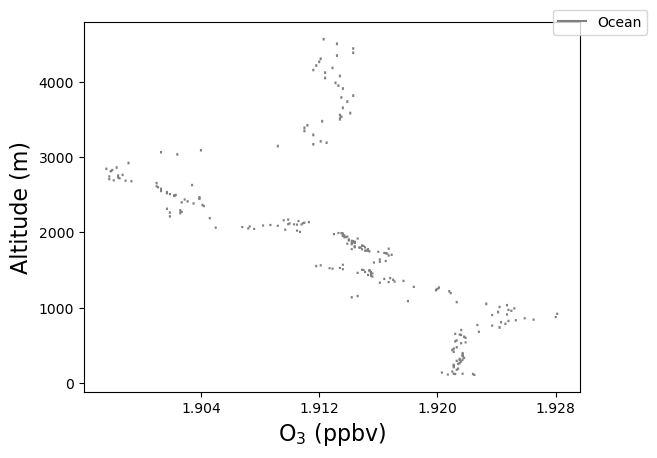

In [70]:
fig,ax = plt.subplots()
#ax.plot(DAY13b_subset['O3_ppbv_DISKIN'], DAY13b_subset['GPS_Altitude_THORNHILL'], color = "red", label = 'North America')
ax.plot(DAY13b_subset['CH4_ppm_DISKIN'], DAY13b_subset['GPS_Altitude_THORNHILL'], color = "grey", label = 'Ocean')
#ax.plot(DAY13b_subset['CO2_ppm_DISKIN'], DAY13b_subset['GPS_Altitude_THORNHILL'], color = "green", label = 'North Africa')
#ax.plot(DAY13b_subset['CO_ppm_DISKIN'], DAY13b_subset['GPS_Altitude_THORNHILL'], color = "blue", label = 'Caribbean')
ax.set_ylabel('Altitude (m)', fontsize = 16)
ax.set_xlabel(r'$\mathrm{O_{3}}$ (ppbv)', fontsize = 16)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')

In [71]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY14_subset_1000 = DAY14_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_14 = DAY14_subset_1000[start_index:stop_index]
DAY1000_subset_14


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(117.0, 200.633]",2022-06-14 16:05:20.000,2022-06-14 16:05:21.000,30.634387,-64.413680,118.0250,1.91990,0.07460,420.110,14.80,4.627000e-08,11.7300,62.400,NaN,NaN,0.3250,NaN
"(200.633, 284.267]",2022-06-14 16:05:44.500,2022-06-14 16:05:45.500,30.642431,-64.438555,243.7250,1.92020,0.07400,420.260,17.20,4.260000e-08,12.7450,61.700,16.1900,1.1800,0.8125,NaN
"(284.267, 367.9]",2022-06-14 16:05:55.000,2022-06-14 16:05:56.000,30.651870,-64.443885,326.2200,1.92065,0.07110,420.300,16.00,7.098000e-08,9.2800,61.400,11.6250,1.2250,0.6100,NaN
"(367.9, 451.533]",2022-06-14 16:06:05.500,2022-06-14 16:06:06.500,30.662373,-64.443863,410.0450,1.92155,0.07350,420.300,13.10,8.010500e-08,11.8925,60.925,10.1200,1.0325,0.5525,NaN
"(451.533, 535.166]",2022-06-14 16:06:16.000,2022-06-14 16:06:17.000,30.672051,-64.438733,493.6150,1.91700,0.07460,420.410,14.20,7.209000e-08,16.1800,60.100,15.0300,0.8700,0.4500,NaN
"(535.166, 618.8]",2022-06-14 16:06:27.500,2022-06-14 16:06:28.500,30.680642,-64.429457,577.6025,1.91680,0.07175,420.440,14.20,3.552500e-08,15.2175,58.975,14.8225,1.0575,0.3600,NaN
"(618.8, 702.433]",2022-06-14 16:06:38.500,2022-06-14 16:06:39.500,30.684686,-64.417288,662.5250,1.91560,0.07435,420.470,14.30,5.936500e-08,16.0550,57.925,15.4575,0.9700,0.2375,NaN
"(702.433, 786.066]",2022-06-14 16:06:48.500,2022-06-14 16:06:49.500,30.683898,-64.405451,744.1025,1.91575,0.07360,420.515,15.30,5.995000e-08,18.2750,57.050,17.3375,0.9175,0.1275,NaN
"(786.066, 869.7]",2022-06-14 16:06:59.500,2022-06-14 16:07:00.500,30.678364,-64.394209,825.6350,1.91990,0.07335,420.360,16.65,1.080700e-07,22.6950,55.950,21.8450,0.8350,0.0575,NaN


In [72]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY14_subset_3000 = DAY14_subset_1000[start_index:stop_index]
DAY14_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(1036.966, 1120.6]",2022-06-14 16:07:29.500,2022-06-14 16:07:30.500,30.651221,-64.387604,1076.810,1.91785,0.07315,420.625,18.40,1.524000e-07,41.6325,53.425,40.1775,0.8775,-0.0775,NaN
"(1120.6, 1204.233]",2022-06-14 16:07:39.000,2022-06-14 16:07:40.000,30.644129,-64.394147,1162.240,1.91830,0.07765,420.650,19.90,1.571000e-07,38.4100,52.650,38.7050,0.8700,-0.0150,NaN
"(1204.233, 1287.866]",2022-06-14 16:07:48.500,2022-06-14 16:07:49.500,30.640051,-64.403570,1247.740,1.91695,0.07025,420.585,17.40,1.684500e-07,36.3350,51.900,34.1350,0.8150,0.0150,NaN
"(1287.866, 1371.5]",2022-06-14 16:07:58.500,2022-06-14 16:07:59.500,30.639776,-64.414829,1331.135,1.91695,0.07210,420.520,19.50,1.392500e-07,39.0875,51.325,36.6900,0.8575,0.0250,NaN
"(1371.5, 1455.133]",2022-06-14 16:08:08.000,2022-06-14 16:08:09.000,30.643501,-64.424924,1413.230,NaN,NaN,NaN,NaN,1.444000e-07,37.7500,50.550,38.2300,0.9700,0.0000,NaN
"(1455.133, 1538.766]",2022-06-14 16:08:17.500,2022-06-14 16:08:18.500,30.650609,-64.432640,1499.150,NaN,NaN,NaN,NaN,2.292500e-07,36.6975,49.850,34.3275,0.7600,-0.0825,NaN
"(1538.766, 1622.399]",2022-06-14 16:08:27.000,2022-06-14 16:08:28.000,30.660027,-64.436728,1580.140,NaN,NaN,NaN,NaN,1.584000e-07,35.3750,49.250,33.2800,0.8800,-0.0800,NaN
"(1622.399, 1706.033]",2022-06-14 16:08:36.500,2022-06-14 16:08:37.500,30.670389,-64.436375,1663.475,NaN,NaN,NaN,NaN,4.842500e-08,40.9625,48.650,38.2625,0.7975,-0.1325,NaN
"(1706.033, 1789.666]",2022-06-14 16:08:46.500,2022-06-14 16:08:47.500,30.680622,-64.431179,1749.545,NaN,NaN,NaN,NaN,1.179500e-07,39.7400,48.050,35.8200,0.7950,-0.0725,NaN


In [73]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY17_subset_1000 = DAY17_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_17 = DAY17_subset_1000[start_index:stop_index]
DAY1000_subset_17


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(124.73, 200.146]",2022-06-17 16:20:35.000,2022-06-17 16:20:36.000,32.214041,-64.973553,129.0550,1.9729,0.09440,417.98,39.9,8.266000e-08,12.445,50.40,13.2650,1.3150,0.0650,NaN
"(200.146, 275.561]",2022-06-17 16:21:24.500,2022-06-17 16:21:25.500,32.251108,-64.989798,233.5475,1.9726,0.09570,418.13,40.1,1.190000e-07,11.380,49.75,12.7875,1.5225,0.1925,NaN
"(275.561, 350.977]",2022-06-17 16:21:50.000,2022-06-17 16:21:51.000,32.242680,-65.013329,308.3550,1.9726,0.09420,418.09,40.9,1.137000e-07,11.550,49.70,13.0300,1.3750,0.0900,NaN
"(350.977, 426.392]",2022-06-17 16:22:13.000,2022-06-17 16:22:14.000,32.223230,-65.014063,397.4800,1.9732,0.09430,418.03,39.8,1.265000e-07,12.795,49.30,14.9050,1.5300,-0.0650,NaN
"(426.392, 501.808]",2022-06-17 16:22:35.000,2022-06-17 16:22:36.000,32.213584,-64.995409,463.9800,1.9731,0.09395,418.06,40.7,1.880000e-07,13.065,49.30,14.9000,1.3100,-0.0800,NaN
"(501.808, 577.223]",2022-06-17 16:22:57.000,2022-06-17 16:22:58.000,32.220725,-64.973889,543.1900,1.9721,0.09480,418.11,39.6,1.088000e-07,12.555,49.20,15.8400,1.4100,0.0950,NaN
"(577.223, 652.638]",2022-06-17 16:23:17.000,2022-06-17 16:23:18.000,32.239210,-64.967740,615.0050,1.9719,0.09640,418.14,43.3,8.955000e-08,13.065,48.90,15.3300,1.3900,0.2600,NaN
"(652.638, 728.054]",2022-06-17 16:23:38.000,2022-06-17 16:23:39.000,32.257797,-64.979905,685.4600,1.9721,0.09610,418.13,43.1,1.243000e-07,13.290,48.70,16.6700,1.4350,0.2200,NaN
"(728.054, 803.47]",2022-06-17 16:23:59.000,2022-06-17 16:24:00.000,32.263464,-65.005588,763.5200,1.9721,0.09580,418.21,42.5,1.865000e-07,13.965,48.20,17.8150,1.4550,0.0600,NaN


In [74]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY17_subset_3000 = DAY17_subset_1000[start_index:stop_index]
DAY17_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,32,32,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,3.200000e+01,32.000000,32.000000,16.000000,17.000000,18.000000,5.000000
mean,2022-06-17 16:34:08.953124864,2022-06-17 16:34:09.953124864,32.214137,-65.012866,2235.412188,1.963748,0.093208,419.410156,62.101562,4.944344e-08,5.709297,33.288281,12.214375,1.479118,0.333194,1.169000
min,2022-06-17 16:25:25,2022-06-17 16:25:26,32.178687,-65.053098,1070.580000,1.956000,0.087950,418.060000,44.600000,0.000000e+00,1.395000,26.100000,-7.155000,1.000000,-0.740000,1.030000
25%,2022-06-17 16:32:07.249999872,2022-06-17 16:32:08.249999872,32.191160,-65.038956,1648.127500,1.958788,0.091050,418.377500,48.525000,0.000000e+00,2.089375,27.231250,7.904375,1.385000,0.255625,1.105000
50%,2022-06-17 16:35:19.249999872,2022-06-17 16:35:20.249999872,32.209850,-65.014392,2233.677500,1.962650,0.093125,419.567500,64.575000,0.000000e+00,3.891250,29.600000,13.490000,1.465000,0.470000,1.222500
75%,2022-06-17 16:36:48,2022-06-17 16:36:49,32.238779,-64.988537,2819.188750,1.970413,0.095300,420.362500,71.087500,7.756250e-08,9.817500,40.550000,16.928750,1.640000,0.690000,1.222500
max,2022-06-17 16:38:08.500000,2022-06-17 16:38:09.500000,32.252800,-64.972378,3406.405000,1.972300,0.098200,420.700000,82.700000,3.491000e-07,15.085000,45.800000,25.585000,2.030000,1.065000,1.265000
std,NaN,NaN,0.024424,0.027179,708.182671,0.005831,0.002581,0.939499,12.178706,9.112271e-08,4.148025,6.867968,8.276014,0.266119,0.548896,0.097925


In [75]:

# Concatenate the dataframes vertically (along rows)
ocean = pd.concat([DAY1000_subset_1000a, DAY1000_subset_1000, DAY1000_subset_1000b], axis=0)

# Reset the index of the merged dataframe
ocean.reset_index(drop=True, inplace=True)
ocean

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
0,2022-06-02 12:59:00.500,2022-06-02 12:59:01.500,32.903514,-69.411194,113.9000,NaN,NaN,NaN,15.00,4.399500e-08,14.5850,57.150,17.2750,1.3050,1.3050,NaN
1,2022-06-02 12:59:09.500,2022-06-02 12:59:10.500,32.907635,-69.400132,160.4275,NaN,NaN,NaN,15.25,4.663000e-08,13.0375,57.000,17.8450,1.4475,1.3900,NaN
2,2022-06-02 12:59:14.500,2022-06-02 12:59:15.500,32.910235,-69.394203,199.8250,NaN,NaN,NaN,15.50,1.356000e-07,14.7375,56.800,18.0325,1.2525,1.3775,NaN
3,2022-06-02 12:59:20.500,2022-06-02 12:59:21.500,32.914346,-69.387850,234.4575,NaN,NaN,NaN,16.75,9.489500e-08,14.6250,56.625,17.3300,1.2400,1.3800,NaN
4,2022-06-02 12:59:26.000,2022-06-02 12:59:27.000,32.919085,-69.383209,276.6850,NaN,NaN,NaN,17.30,9.001000e-08,14.9700,56.600,17.8400,1.2000,1.3750,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2022-06-02 18:40:19.500,2022-06-02 18:40:20.500,32.249653,-65.011510,796.8525,1.9315,0.08620,421.32,21.05,4.370500e-09,5.9350,46.900,6.1825,1.5825,1.0500,NaN
70,2022-06-02 18:40:31.000,2022-06-02 18:40:32.000,32.244869,-64.998809,826.1250,1.9321,0.08490,421.33,20.00,5.988000e-09,6.4600,46.600,8.0200,1.3300,0.9300,NaN
71,2022-06-02 18:40:41.000,2022-06-02 18:40:42.000,32.243755,-64.986508,866.0400,1.9323,0.08785,421.32,20.20,1.075000e-08,6.8700,46.400,8.3400,1.3700,1.0450,NaN
72,2022-06-02 18:40:50.500,2022-06-02 18:40:51.500,32.245390,-64.974729,900.6175,1.9324,0.08570,421.34,21.50,2.384800e-08,6.8000,46.200,7.9475,0.9875,1.1850,NaN


In [76]:
# Concatenate the dataframes vertically (along rows)
ocean2 = pd.concat([DAY3000_subset_3000a, DAY3000_subset_3000, DAY3000_subset_3000b], axis=0)

# Reset the index of the merged dataframe
ocean2.reset_index(drop=True, inplace=True)
ocean2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
count,205,205,205.000000,205.000000,205.000000,62.000000,62.000000,62.000000,199.000000,2.050000e+02,205.000000,205.000000,117.000000,129.000000,139.000000,0.0
mean,2022-06-02 15:20:36.870731520,2022-06-02 15:20:37.870731776,32.487566,-66.411698,2175.330561,1.935873,0.084608,421.611532,41.154020,1.485832e-09,4.788390,38.799756,7.089808,1.222384,0.720719,NaN
min,2022-06-02 13:00:58.500000,2022-06-02 13:00:59.500000,32.218287,-69.440875,1010.300000,1.926700,0.077100,421.230000,19.500000,0.000000e+00,0.600000,29.600000,-5.940000,0.620000,-0.120000,NaN
25%,2022-06-02 13:05:06,2022-06-02 13:05:07,32.265281,-69.367277,1578.830000,1.930475,0.082138,421.440000,32.050000,0.000000e+00,3.235000,33.800000,5.555000,1.000000,0.473750,NaN
50%,2022-06-02 14:06:58,2022-06-02 14:06:59,32.291369,-65.009415,2172.390000,1.934950,0.084800,421.560000,43.500000,0.000000e+00,4.710000,38.700000,7.285000,1.170000,0.767500,NaN
75%,2022-06-02 18:44:20,2022-06-02 18:44:21,32.904471,-64.971861,2753.280000,1.940625,0.086975,421.742500,49.400000,0.000000e+00,5.827500,43.600000,8.900000,1.430000,0.940000,NaN
max,2022-06-02 18:52:12,2022-06-02 18:52:13,32.971995,-64.908315,3436.490000,1.946750,0.092500,422.165000,69.100000,3.580500e-08,12.562500,50.750000,13.120000,2.450000,1.545000,NaN
std,NaN,NaN,0.308460,2.062383,686.586631,0.005913,0.003583,0.231716,12.034411,5.320434e-09,2.396501,5.691354,2.948511,0.336576,0.313423,NaN


In [77]:
ocean_transport = pd.concat([ocean, ocean2], axis=0)
ocean_transport.reset_index(drop=True, inplace=True)
ocean_transport
nbins = 100
bins = np.linspace(ocean_transport.GPS_Altitude_THORNHILL.min(), ocean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
ocean_transport['Bins'] = pd.cut(ocean_transport['GPS_Altitude_THORNHILL'], bins)
ocean_transport_plot = ocean_transport.groupby('Bins').median()
ocean_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(113.9, 147.126]",2022-06-02 13:58:08.000000000,2022-06-02 13:58:09.000000000,32.208306,-65.047757,123.1500,NaN,NaN,NaN,19.10,9.523000e-08,11.36000,54.200,16.65000,1.56500,1.42500,NaN
"(147.126, 180.352]",2022-06-02 13:58:57.000000000,2022-06-02 13:58:58.000000000,32.253663,-65.018367,155.8975,1.93140,0.08720,421.130,19.55,9.054500e-08,11.36750,54.325,16.13500,1.44875,1.36750,NaN
"(180.352, 213.578]",2022-06-02 15:47:43.249999872,2022-06-02 15:47:44.249999872,32.610267,-67.208768,193.2725,1.93150,0.08640,421.115,17.45,1.031550e-07,12.63125,55.100,17.53375,1.43875,1.35625,NaN
"(213.578, 246.804]",2022-06-02 13:57:05.500000000,2022-06-02 13:57:06.500000000,32.265793,-65.119394,216.3950,1.93120,0.08635,421.190,19.30,8.057000e-08,12.32000,53.700,15.85250,1.24000,1.38500,NaN
"(246.804, 280.03]",2022-06-02 13:58:12.000000000,2022-06-02 13:58:13.000000000,32.245919,-65.081293,268.4175,1.93120,0.08250,421.245,19.55,1.041550e-07,11.39375,53.750,15.71875,1.35250,1.40125,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3270.36, 3303.586]",2022-06-02 15:58:56.000000000,2022-06-02 15:58:57.000000000,32.623407,-67.200891,3288.9275,1.92790,0.08310,421.425,42.00,0.000000e+00,1.48625,32.500,NaN,NaN,NaN,NaN
"(3303.586, 3336.812]",2022-06-02 15:59:01.500000000,2022-06-02 15:59:02.500000000,32.619358,-67.205112,3326.0900,1.92750,0.08190,421.465,42.35,0.000000e+00,2.60250,32.500,NaN,NaN,NaN,NaN
"(3336.812, 3370.038]",2022-06-02 15:59:06.249999872,2022-06-02 15:59:07.249999872,32.615300,-67.208328,3363.1650,1.92740,0.07885,421.470,41.80,0.000000e+00,2.02625,32.500,NaN,NaN,NaN,NaN


In [78]:
# Concatenate the dataframes vertically (along rows)
North_America = pd.concat([DAY1000_subset_7, DAY1000_subset_7b, DAY8_subset_3000, DAY1000_subset_8, DAY1000_subset_17], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
North_America.reset_index(drop=True, inplace=True)
North_America.mean()

Time_Start                     2022-06-09 02:26:44.350993408
Time_Stop                      2022-06-09 02:26:45.350993152
Latitude_THORNHILL                                 32.255319
Longitude_THORNHILL                               -65.030787
GPS_Altitude_THORNHILL                           1283.981109
CH4_ppm_DISKIN                                      1.971875
CO_ppm_DISKIN                                       0.097573
CO2_ppm_DISKIN                                    419.527881
O3_ppbv_DISKIN                                     46.724503
LWC_FCDP_VOIGT                                      0.000002
Sc550_submicron_ZIEMBA                             10.054606
RH_Sc_submicron_ZIEMBA                             40.630132
Ext532_submicron_amb_ZIEMBA                        20.093714
fRH550_RH20to80_ZIEMBA                              1.293125
AEscatAMB_450to700nm_ZIEMBA                         0.750912
AEabsDRY_470to660nm_ZIEMBA                             0.931
dtype: object

In [79]:
# Concatenate the dataframes vertically (along rows)
North_America2 = pd.concat([DAY7_subset_3000, DAY7b_subset_3000, DAY17_subset_3000], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
North_America2.reset_index(drop=True, inplace=True)
North_America2

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
0,2022-06-07 14:38:08.500,2022-06-07 14:38:09.500,32.226197,-65.063460,1014.245,1.98100,0.09930,419.68,48.40,6.625500e-08,12.5800,40.5,17.1975,1.8625,0.9625,NaN
1,2022-06-07 14:38:18.000,2022-06-07 14:38:19.000,32.234533,-65.059455,1049.390,1.97670,0.09900,419.81,45.50,1.069000e-07,14.7500,40.3,18.9100,1.5500,0.8800,NaN
2,2022-06-07 14:38:29.000,2022-06-07 14:38:30.000,32.243113,-65.052401,1076.340,1.97565,0.09710,419.82,46.50,8.951000e-08,15.2550,40.1,20.0450,1.5850,0.8500,NaN
3,2022-06-07 14:38:41.000,2022-06-07 14:38:42.000,32.250523,-65.041995,1104.090,1.97565,0.10110,419.88,46.40,9.305000e-08,15.5400,40.0,22.2800,1.6150,0.8050,NaN
4,2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,32.254166,-65.030077,1136.620,1.97550,0.09910,419.88,46.00,4.882000e-08,19.0700,40.0,24.5150,1.4950,0.8000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,2022-06-17 16:37:28.000,2022-06-17 16:37:29.000,32.179166,-65.017440,3104.720,1.95695,0.09125,420.42,73.20,0.000000e+00,6.2700,26.7,8.2800,1.0000,-0.6300,1.0300
171,2022-06-17 16:37:38.500,2022-06-17 16:37:39.500,32.178687,-65.002961,3178.440,1.95745,0.08960,420.52,75.50,0.000000e+00,4.2600,26.5,8.0300,2.0300,-0.7400,1.2225
172,2022-06-17 16:37:48.500,2022-06-17 16:37:49.500,32.182226,-64.989990,3254.130,1.95760,0.09450,420.49,82.70,0.000000e+00,3.3000,26.4,NaN,1.4600,NaN,1.2650
173,2022-06-17 16:37:58.500,2022-06-17 16:37:59.500,32.189191,-64.979410,3333.355,1.95815,0.09415,420.57,79.40,0.000000e+00,1.3950,26.2,NaN,NaN,NaN,1.1050


In [80]:
#North_America_transport_plot = North_America_transport_plot[North_America_transport_plot['fRH550_RH20to80_ZIEMBA']<=1.55]

In [81]:
North_America_transport = pd.concat([North_America, North_America2], axis=0)
North_America_transport.reset_index(drop=True, inplace=True)
North_America_transport
nbins = 100
bins = np.linspace(North_America_transport.GPS_Altitude_THORNHILL.min(), North_America_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
North_America_transport['Bins'] = pd.cut(North_America_transport['GPS_Altitude_THORNHILL'], bins)
North_America_transport_plot = North_America_transport.groupby('Bins').median()
North_America_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(129.055, 162.363]",2022-06-07 19:08:09.000000000,2022-06-07 19:08:10.000000000,32.247084,-64.993783,138.96500,1.982800,0.10280,418.575,37.10,1.994000e-07,16.37875,47.70,18.19625,1.17250,0.68750,NaN
"(162.363, 195.671]",2022-06-07 14:32:32.000000000,2022-06-07 14:32:33.000000000,32.238512,-64.980762,183.54000,1.987800,0.10770,419.105,50.65,2.079500e-07,20.46125,44.80,24.31750,1.38375,0.79250,NaN
"(195.671, 228.979]",2022-06-08 07:49:49.249999872,2022-06-08 07:49:50.249999872,32.280595,-65.020309,208.24875,1.981675,0.10085,418.455,35.90,1.630000e-07,11.44500,47.55,12.44000,1.10000,0.91000,NaN
"(228.979, 262.287]",2022-06-07 19:08:42.500000000,2022-06-07 19:08:43.500000000,32.251108,-64.976183,242.16000,1.983100,0.09930,418.570,40.10,2.064000e-07,15.25875,47.30,18.90000,1.45875,0.71625,NaN
"(262.287, 295.595]",2022-06-07 19:08:51.500000000,2022-06-07 19:08:52.500000000,32.281722,-64.986863,286.80500,1.982300,0.10010,418.535,35.25,1.678500e-07,17.26375,47.10,19.46250,1.24000,0.86625,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3293.31, 3326.618]",2022-06-08 08:03:07.500000000,2022-06-08 08:03:08.500000000,32.287420,-65.011851,3309.63500,1.949250,0.08840,420.680,50.25,0.000000e+00,1.57000,30.15,NaN,NaN,NaN,1.1300
"(3326.618, 3359.926]",2022-06-08 20:43:55.500000000,2022-06-08 20:43:56.500000000,32.283576,-64.983815,3333.35500,1.958150,0.09415,420.570,53.65,0.000000e+00,2.17750,30.10,NaN,NaN,NaN,0.9725
"(3359.926, 3393.234]",2022-06-08 20:44:00.000000000,2022-06-08 20:44:01.000000000,32.297241,-65.055479,3370.54000,1.935800,0.08110,421.135,38.80,0.000000e+00,2.83500,30.20,NaN,NaN,NaN,1.0300


In [82]:
# Concatenate the dataframes vertically (along rows)
Caribbean = pd.concat([DAY1000_subset_10, DAY1000_subset_110b, DAY1000_subset_10b, DAY1000_subset_11, DAY1000_subset_11b, DAY1000_subset_13, DAY1000_subset_13b, DAY1000_subset_14], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
Caribbean.reset_index(drop=True, inplace=True)
Caribbean.mean()

Time_Start                     2022-06-12 01:22:20.223684096
Time_Stop                      2022-06-12 01:22:21.223684096
Latitude_THORNHILL                                 31.811734
Longitude_THORNHILL                                 -65.0999
GPS_Altitude_THORNHILL                            536.637533
CH4_ppm_DISKIN                                       1.91752
CO_ppm_DISKIN                                       0.080882
CO2_ppm_DISKIN                                    420.425461
O3_ppbv_DISKIN                                     14.783221
LWC_FCDP_VOIGT                                           0.0
Sc550_submicron_ZIEMBA                             26.641836
RH_Sc_submicron_ZIEMBA                             58.250822
Ext532_submicron_amb_ZIEMBA                        28.482895
fRH550_RH20to80_ZIEMBA                              0.988913
AEscatAMB_450to700nm_ZIEMBA                          0.41969
AEabsDRY_470to660nm_ZIEMBA                               NaN
dtype: object

In [83]:
# Concatenate the dataframes vertically (along rows)
Caribbean2 = pd.concat([DAY10_subset_3000, DAY110b_subset_3000, DAY10b_subset_3000, DAY11_subset_3000, DAY11b_subset_3000, DAY13_subset_3000, DAY13b_subset_3000, DAY14_subset_3000], axis=0)

# Reset the index of the DAY2b_subsetd dataframe
Caribbean2.reset_index(drop=True, inplace=True)
Caribbean2.mean()

Time_Start                     2022-06-12 01:04:06.082949376
Time_Stop                      2022-06-12 01:04:07.082949376
Latitude_THORNHILL                                 31.829876
Longitude_THORNHILL                               -65.108849
GPS_Altitude_THORNHILL                           2195.977546
CH4_ppm_DISKIN                                      1.917953
CO_ppm_DISKIN                                       0.078224
CO2_ppm_DISKIN                                    420.494531
O3_ppbv_DISKIN                                     25.347658
LWC_FCDP_VOIGT                                           0.0
Sc550_submicron_ZIEMBA                             23.019054
RH_Sc_submicron_ZIEMBA                              45.19856
Ext532_submicron_amb_ZIEMBA                        32.289071
fRH550_RH20to80_ZIEMBA                              0.945786
AEscatAMB_450to700nm_ZIEMBA                         0.320292
AEabsDRY_470to660nm_ZIEMBA                          1.585833
dtype: object

In [84]:
Caribbean_transport = pd.concat([Caribbean, Caribbean2], axis=0)
Caribbean_transport.reset_index(drop=True, inplace=True)
Caribbean_transport
nbins = 100
bins = np.linspace(Caribbean_transport.GPS_Altitude_THORNHILL.min(), Caribbean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Caribbean_transport['Bins'] = pd.cut(Caribbean_transport['GPS_Altitude_THORNHILL'], bins)
Caribbean_transport_plot = Caribbean_transport.groupby('Bins').median()
Caribbean_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(115.232, 148.57]",2022-06-11 20:08:07.500000000,2022-06-11 20:08:08.500000000,32.199022,-64.991872,123.70500,1.917600,0.078800,420.2700,14.900,2.793000e-07,19.86125,61.600,29.30000,1.02625,0.45125,NaN
"(148.57, 181.908]",2022-06-11 20:08:18.500000000,2022-06-11 20:08:19.500000000,32.223075,-64.962152,172.99000,1.916800,0.077500,420.4100,13.600,2.909000e-07,15.72250,63.200,15.48875,1.08250,0.43500,NaN
"(181.908, 215.246]",2022-06-11 15:25:26.500000000,2022-06-11 15:25:27.500000000,31.798272,-65.009660,199.81250,1.915600,0.080800,420.4000,15.700,5.466500e-07,31.01875,61.175,29.36375,1.02875,0.51000,NaN
"(215.246, 248.584]",2022-06-11 08:17:41.249999872,2022-06-11 08:17:42.249999872,31.552281,-64.979459,243.05625,1.916575,0.082650,420.3125,15.750,2.690000e-07,32.08500,61.550,26.70500,1.11500,0.55500,NaN
"(248.584, 281.922]",2022-06-11 20:08:32.000000000,2022-06-11 20:08:33.000000000,32.235319,-64.997626,261.79750,1.916350,0.077800,420.3700,13.300,2.203000e-07,20.53500,61.200,19.82750,0.95000,0.53000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3282.335, 3315.673]",2022-06-11 15:38:40.000000000,2022-06-11 15:38:41.000000000,32.226153,-64.999683,3307.62500,1.915500,0.076600,420.1850,40.300,0.000000e+00,-0.09375,38.950,NaN,NaN,NaN,1.800
"(3315.673, 3349.011]",2022-06-11 15:38:46.500000000,2022-06-11 15:38:47.500000000,32.218854,-65.004787,3328.24000,1.920000,0.073100,420.4900,29.200,0.000000e+00,0.53125,39.700,NaN,NaN,NaN,NaN
"(3349.011, 3382.349]",2022-06-11 06:04:55.750000128,2022-06-11 06:04:56.750000128,32.219617,-65.036152,3368.60500,1.924125,0.077800,420.7100,39.450,0.000000e+00,1.05000,38.800,NaN,NaN,NaN,1.325


In [85]:
'''Sc550_submicron_amb_ZIEMBA
# Filter the data using the condition >= 0.4
Caribbean_transport = Caribbean_transport[Caribbean_transport['Sc550_submicron_amb_ZIEMBA'] >= 50]'''

"Sc550_submicron_amb_ZIEMBA\n# Filter the data using the condition >= 0.4\nCaribbean_transport = Caribbean_transport[Caribbean_transport['Sc550_submicron_amb_ZIEMBA'] >= 50]"

In [86]:
nbins = 15
bins = np.linspace(Caribbean_transport.GPS_Altitude_THORNHILL.min(), Caribbean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Caribbean_transport['Bins'] = pd.cut(Caribbean_transport['GPS_Altitude_THORNHILL'], bins)
Caribbean_transport_median = Caribbean_transport.groupby('Bins').median()
Caribbean_transport_median
Caribbean_transport_25 = Caribbean_transport_median - Caribbean_transport.groupby('Bins').quantile(.25)
Caribbean_transport_25
Caribbean_transport_75 = Caribbean_transport.groupby('Bins').quantile(.75) - Caribbean_transport_median
Caribbean_transport_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(115.232, 337.485]",1 days 18:23:10.250000128,1 days 18:23:10.250000128,0.416913,0.315881,45.416250,0.003825,0.005100,0.07500,1.3250,1.253500e-07,4.127500,1.47500,6.762500,0.115000,0.115000,NaN
"(337.485, 559.738]",1 days 20:44:08,1 days 20:44:08,0.044106,0.083774,51.956250,0.004663,0.007363,0.05875,1.9750,6.100000e-08,8.905000,1.21250,7.232500,0.065000,0.090000,NaN
"(559.738, 781.991]",1 days 23:05:04.500000,1 days 23:05:04.500000,0.048258,0.072604,53.012500,0.002450,0.004050,0.04500,2.0500,1.207100e-07,13.475000,1.35000,8.025000,0.103125,0.088750,NaN
"(781.991, 1004.244]",1 days 20:44:44.249999872,1 days 20:44:44.249999872,0.043983,0.166764,46.628125,0.003875,0.003175,0.17875,1.2500,1.229650e-07,5.288750,0.74375,4.175000,0.056250,0.208750,NaN
"(1004.244, 1226.497]",1 days 23:04:41.500000,1 days 23:04:41.500000,0.048267,0.044583,54.485000,0.003600,0.004250,0.24500,5.3000,1.809350e-07,5.505000,0.82500,4.367500,0.085000,0.057500,NaN
"(1226.497, 1448.75]",1 days 23:05:09,1 days 23:05:09,0.034111,0.047816,53.360000,0.006100,0.002450,0.05125,6.7875,2.350500e-07,28.150000,0.80000,26.108750,0.161875,0.418750,NaN
"(1448.75, 1671.002]",1 days 18:26:43.749999872,1 days 18:26:43.749999872,0.026708,0.225291,53.360000,0.008613,0.002500,0.32875,8.4500,1.550500e-07,20.790000,0.70000,24.130000,0.127500,0.600000,NaN
"(1671.002, 1893.255]",1 days 20:46:17.624999936,1 days 20:46:17.624999936,0.025363,0.104416,48.833750,0.008375,0.002525,0.26750,6.9250,1.876875e-07,19.506250,0.96250,21.871250,0.150000,0.761250,NaN
"(1893.255, 2115.508]",1 days 23:05:34,1 days 23:05:34,0.025527,0.062296,63.535000,0.009250,0.004850,0.46500,7.0750,2.188900e-07,23.545625,0.85000,25.181875,0.168750,0.767500,NaN


In [87]:
nbins = 15
bins = np.linspace(North_America_transport.GPS_Altitude_THORNHILL.min(), North_America_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
North_America_transport['Bins'] = pd.cut(North_America_transport['GPS_Altitude_THORNHILL'], bins)
North_America_transport_median = North_America_transport.groupby('Bins').median()
North_America_transport_median
North_America_transport_25 = North_America_transport_median - North_America_transport.groupby('Bins').quantile(.25)
North_America_transport_25
North_America_transport_75 = North_America_transport.groupby('Bins').quantile(.75) - North_America_transport_median
North_America_transport_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(129.055, 351.108]",1 days 01:22:35.500000,1 days 01:22:35.500000,0.030614,0.013614,51.23500,0.004500,0.004900,0.5350,10.9000,1.120000e-08,1.638750,0.40000,1.28375,0.053750,0.081250,NaN
"(351.108, 573.161]",1 days 01:22:25.249999872,1 days 01:22:25.249999872,0.032970,0.019953,51.54750,0.005475,0.004400,0.6350,11.2000,3.842500e-08,5.383750,1.20000,10.60000,0.118125,0.148125,NaN
"(573.161, 795.214]",1 days 01:22:31.375000064,1 days 01:22:31.375000064,0.018646,0.018117,44.69000,0.004450,0.005300,0.4200,8.7250,8.252500e-08,7.617500,0.89375,12.34250,0.066250,0.295000,NaN
"(795.214, 1017.267]",1 days 01:22:34.875000064,1 days 01:22:34.875000064,0.046992,0.038996,43.09250,0.001050,0.002875,0.6150,8.7000,7.900000e-08,1.707500,0.45000,1.81250,0.127500,0.080000,NaN
"(1017.267, 1239.32]",1 days 01:22:41.250000128,1 days 01:22:41.250000128,0.024484,0.024267,38.63750,0.002750,0.002587,0.3050,1.7750,6.468000e-08,0.891250,1.07500,2.64375,0.057500,0.197500,NaN
"(1239.32, 1461.373]",1 days 01:22:40.250000128,1 days 01:22:40.250000128,0.020431,0.020381,50.76000,0.001850,0.001350,0.5625,1.5000,0.000000e+00,3.872500,2.07500,5.47375,0.151250,0.127500,NaN
"(1461.373, 1683.426]",1 days 01:22:42.749999872,1 days 01:22:42.749999872,0.028739,0.046105,37.09250,0.001975,0.002350,0.7950,1.2500,0.000000e+00,1.325000,0.66250,2.57000,0.092500,0.285000,NaN
"(1683.426, 1905.479]",1 days 01:22:15.250000128,1 days 01:22:15.250000128,0.006994,0.021901,49.02500,0.001850,0.003250,1.3800,0.3500,0.000000e+00,1.568750,3.32500,11.64625,0.361875,0.142500,0.007500
"(1905.479, 2127.532]",1 days 01:21:54.124999936,1 days 01:21:54.124999936,0.026124,0.026684,46.90750,0.006350,0.002375,1.2400,1.0125,0.000000e+00,0.698750,1.76875,NaN,0.030000,0.000000,NaN


In [88]:
nbins = 15
bins = np.linspace(ocean_transport.GPS_Altitude_THORNHILL.min(), ocean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
ocean_transport['Bins'] = pd.cut(ocean_transport['GPS_Altitude_THORNHILL'], bins)
ocean_transport_median = ocean_transport.groupby('Bins').median()
ocean_transport_median
ocean_transport_25 = ocean_transport_median - ocean_transport.groupby('Bins').quantile(.25)
ocean_transport_25
ocean_transport_75 = ocean_transport.groupby('Bins').quantile(.75) - ocean_transport_median
ocean_transport_75

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,CH4_ppm_DISKIN,CO_ppm_DISKIN,CO2_ppm_DISKIN,O3_ppbv_DISKIN,LWC_FCDP_VOIGT,Sc550_submicron_ZIEMBA,RH_Sc_submicron_ZIEMBA,Ext532_submicron_amb_ZIEMBA,fRH550_RH20to80_ZIEMBA,AEscatAMB_450to700nm_ZIEMBA,AEabsDRY_470to660nm_ZIEMBA
Bins,,,,,,,,,,,,,,,,
"(113.9, 335.406]",0 days 04:37:59.124999936,0 days 04:37:59.124999936,0.508423,0.019565,52.166250,0.000125,0.000625,0.02750,0.2250,2.260250e-08,1.464375,2.10000,0.978750,0.13875,0.015000,NaN
"(335.406, 556.912]",0 days 04:38:07.500000,0 days 04:38:07.500000,0.654620,0.034738,58.404375,0.000088,0.000800,0.02375,1.3000,5.317500e-08,1.795625,3.01250,1.566875,0.10625,0.077500,NaN
"(556.912, 778.418]",0 days 04:38:04.749999872,0 days 04:38:04.749999872,0.666254,0.012641,43.265000,0.000138,0.000875,0.00625,0.3000,9.205000e-09,0.632500,2.90000,1.077500,0.16000,0.210000,NaN
"(778.418, 999.924]",0 days 04:38:27.125000192,0 days 04:38:27.125000192,0.690162,0.017497,43.451250,0.000100,0.001650,0.01000,0.8625,7.152750e-09,2.320625,2.36875,2.257500,0.19375,0.273750,NaN
"(999.924, 1221.43]",0 days 04:38:46.249999872,0 days 04:38:46.249999872,0.617489,0.010805,49.862500,NaN,NaN,NaN,1.0000,9.446000e-09,2.166250,2.01250,2.181250,0.14250,0.197500,NaN
"(1221.43, 1442.936]",0 days 04:39:06,0 days 04:39:06,0.612586,0.015774,58.908750,0.000300,0.000750,0.01125,1.7750,3.405875e-09,3.411250,2.72500,0.386250,0.33375,0.106875,NaN
"(1442.936, 1664.442]",0 days 04:39:26.250000128,0 days 04:39:26.250000128,0.637093,0.058386,67.290000,0.003075,0.000875,0.01000,3.2000,1.986250e-09,2.206250,2.57500,0.813750,0.24750,0.145000,NaN
"(1664.442, 1885.948]",0 days 04:39:27,0 days 04:39:27,0.638359,0.076056,63.367500,0.002200,0.001175,0.06125,1.7000,2.096250e-09,0.473750,2.47500,0.730000,0.18375,0.087500,NaN
"(1885.948, 2107.454]",0 days 04:39:14.875000064,0 days 04:39:14.875000064,0.620470,0.023509,55.010000,0.000300,0.000587,0.01625,4.2625,0.000000e+00,0.495625,2.52500,0.920000,0.08250,0.140000,NaN


In [89]:
# Concatenate the dataframes vertically (along rows)
'''merged_df2 = pd.concat([DAY22_subset, DAY2_subset, DAY2b_subset, DAY7_subset, DAY7b_subset, DAY8_subset, DAY10_subset, DAY110b_subset, DAY10b_subset, DAY11_subset, DAY11b_subset, DAY13_subset, DAY13b_subset, DAY14_subset, DAY17_subset], axis=0)

# Reset the index of the merged dataframe
merged_df2.reset_index(drop=False, inplace=True)'''


'merged_df2 = pd.concat([DAY22_subset, DAY2_subset, DAY2b_subset, DAY7_subset, DAY7b_subset, DAY8_subset, DAY10_subset, DAY110b_subset, DAY10b_subset, DAY11_subset, DAY11b_subset, DAY13_subset, DAY13b_subset, DAY14_subset, DAY17_subset], axis=0)\n\n# Reset the index of the merged dataframe\nmerged_df2.reset_index(drop=False, inplace=True)'

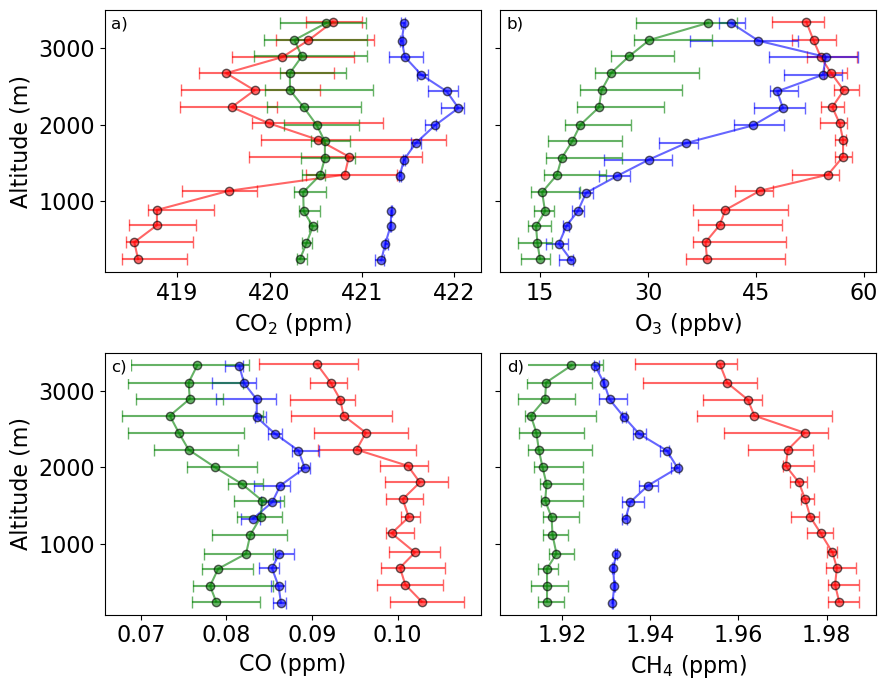

In [109]:
from matplotlib.transforms import ScaledTranslation
import matplotlib.ticker as ticker

# Create a 4x2 subplot grid with appropriate width ratios
fig, ax = plt.subplots(2, 2, figsize=(9, 7), sharey='all')

# Subplot 1: filtered_Africa_data
ax[0, 0].errorbar(North_America_transport_median['CO2_ppm_DISKIN'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['CO2_ppm_DISKIN'], North_America_transport_75['CO2_ppm_DISKIN']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color = "red", label = 'North America')
ax[0, 0].errorbar(ocean_transport_median['CO2_ppm_DISKIN'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['CO2_ppm_DISKIN'], ocean_transport_75['CO2_ppm_DISKIN']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color = "blue", label = 'Ocean')
ax[0, 0].errorbar(Caribbean_transport_median['CO2_ppm_DISKIN'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['CO2_ppm_DISKIN'], Caribbean_transport_75['CO2_ppm_DISKIN']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color = "green", label = 'Caribbean/North Africa')
ax[0, 0].set_ylabel('Altitude (m)', fontsize = 16)
ax[0, 0].tick_params(axis='both', labelsize=16)
ax[0, 0].set_xlabel(r'$\mathrm{CO_{2}}$ (ppm)', fontsize = 16)
ax[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax[0, 0].xaxis.set_minor_locator(ticker.NullLocator())
#ax[0,0].legend(bbox_to_anchor=(-0.8, 1.2, 2, 4), loc = 3, ncol = 3, fontsize='16')

ax[0,1].errorbar(North_America_transport_median['O3_ppbv_DISKIN'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['O3_ppbv_DISKIN'], North_America_transport_75['O3_ppbv_DISKIN']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color = "red", label = 'North America')
ax[0,1].errorbar(ocean_transport_median['O3_ppbv_DISKIN'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['O3_ppbv_DISKIN'], ocean_transport_75['O3_ppbv_DISKIN']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color = "blue", label = 'Ocean')
ax[0,1].errorbar(Caribbean_transport_median['O3_ppbv_DISKIN'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['O3_ppbv_DISKIN'], Caribbean_transport_75['O3_ppbv_DISKIN']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color = "green", label = 'Caribbean')
#ax[0,1].set_ylabel('Altitude (m)', fontsize = 16)
ax[0, 1].tick_params(axis='both', labelsize=16)
ax[0,1].set_xlabel(r'$\mathrm{O_{3}}$ (ppbv)', fontsize = 16)
ax[0,1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax[0,1].xaxis.set_minor_locator(ticker.NullLocator())


#ax.errorbar(DAY11_subset_median['dewpoint'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax[1,0].errorbar(North_America_transport_median['CO_ppm_DISKIN'], North_America_transport_median['GPS_Altitude_THORNHILL'], xerr=[North_America_transport_25['CO_ppm_DISKIN'], North_America_transport_75['CO_ppm_DISKIN']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color = "red", label = 'North America')
ax[1,0].errorbar(ocean_transport_median['CO_ppm_DISKIN'], ocean_transport_median['GPS_Altitude_THORNHILL'], xerr=[ocean_transport_25['CO_ppm_DISKIN'], ocean_transport_75['CO_ppm_DISKIN']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color = "blue", label = 'Ocean')
ax[1,0].errorbar(Caribbean_transport_median['CO_ppm_DISKIN'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['CO_ppm_DISKIN'], Caribbean_transport_75['CO_ppm_DISKIN']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color = "green", label = 'Caribbean')
ax[1,0].set_ylabel('Altitude (m)', fontsize = 16)
ax[1, 0].tick_params(axis='both', labelsize=16)
ax[1,0].set_xlabel('CO (ppm)', fontsize = 16)
ax[1,0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax[1,0].xaxis.set_minor_locator(ticker.NullLocator())

ax[1,1].errorbar(North_America_transport_median['CH4_ppm_DISKIN'], North_America_transport_median['GPS_Altitude_THORNHILL'],  xerr=[North_America_transport_25['CH4_ppm_DISKIN'], North_America_transport_75['CH4_ppm_DISKIN']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color = "red", label = 'North America')
ax[1,1].errorbar(ocean_transport_median['CH4_ppm_DISKIN'], ocean_transport_median['GPS_Altitude_THORNHILL'],  xerr=[ocean_transport_25['CH4_ppm_DISKIN'], ocean_transport_75['CH4_ppm_DISKIN']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color = "blue", label = 'Ocean')
ax[1,1].errorbar(Caribbean_transport_median['CH4_ppm_DISKIN'], Caribbean_transport_median['GPS_Altitude_THORNHILL'], xerr=[Caribbean_transport_25['CH4_ppm_DISKIN'], Caribbean_transport_75['CH4_ppm_DISKIN']], marker='o', markeredgecolor = 'black', linestyle='-', capsize=4, alpha=.6, color = "green", label = 'Caribbean')
#ax[1,2].set_ylabel('Altitude (m)', fontsize = 16)
ax[1, 1].tick_params(axis='both', labelsize=16)
ax[1,1].set_xlabel(r'$\mathrm{CH_{4}}$ (ppm)' , fontsize = 16)
ax[1,1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax[1,1].xaxis.set_minor_locator(ticker.NullLocator())
# Add labels 'a)', 'b)', 'c)'\
 # Set tick label sizes for both x and y axes
labels = ['a)', 'b)', 'c)', 'd)']
for i, label in enumerate(labels):
    trans = ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)
    ax[i // 2, i % 2].text(
        -0.02, 1, label,
        transform=ax[i // 2, i % 2].transAxes + trans,
        fontsize='large', verticalalignment='top',
        bbox=dict(facecolor='1', edgecolor='none', pad=3.0)
    )
plt.tight_layout()
plt.show()

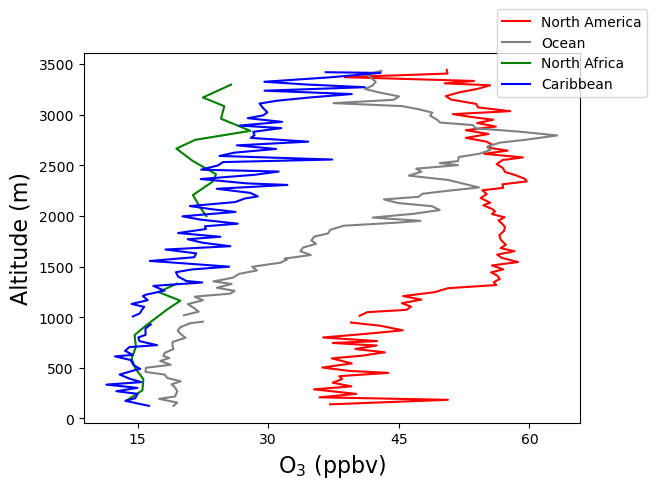

In [ ]:
fig,ax = plt.subplots()
#ax.plot(DAY11_subset_median['dewpoint'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(North_America_transport_plot['O3_ppbv_DISKIN'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color = "red", label = 'North America')
ax.plot(ocean_transport_plot['O3_ppbv_DISKIN'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color = "grey", label = 'Ocean')
ax.plot(Africa_transport_plot['O3_ppbv_DISKIN'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color = "green", label = 'North Africa')
ax.plot(Caribbean_transport_plot['O3_ppbv_DISKIN'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color = "blue", label = 'Caribbean')
ax.set_ylabel('Altitude (m)', fontsize = 16)
ax.set_xlabel(r'$\mathrm{O_{3}}$ (ppbv)', fontsize = 16)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')

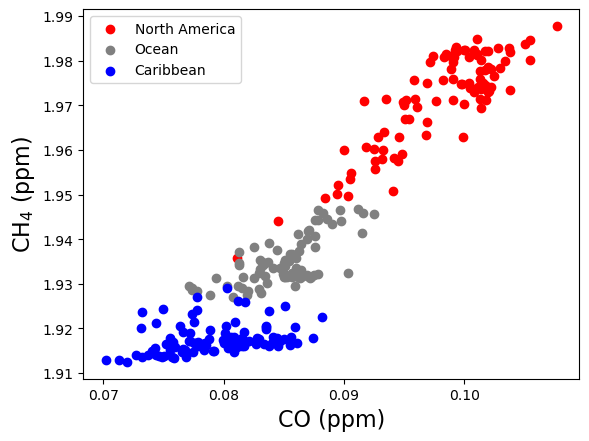

In [ ]:
fig,ax = plt.subplots()
#ax.plot(DAY11_subset_median['dewpoint'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.scatter(North_America_transport_plot['CO_ppm_DISKIN'], North_America_transport_plot['CH4_ppm_DISKIN'], color = "red", label = 'North America')
ax.scatter(ocean_transport_plot['CO_ppm_DISKIN'], ocean_transport_plot['CH4_ppm_DISKIN'], color = "grey", label = 'Ocean')
ax.scatter(Caribbean_transport_plot['CO_ppm_DISKIN'], Caribbean_transport_plot['CH4_ppm_DISKIN'], color = "blue", label = 'Caribbean')
ax.set_ylabel(r'$\mathrm{CH_{4}}$ (ppm)', fontsize = 16)
ax.set_xlabel('CO (ppm)', fontsize =16)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.legend()

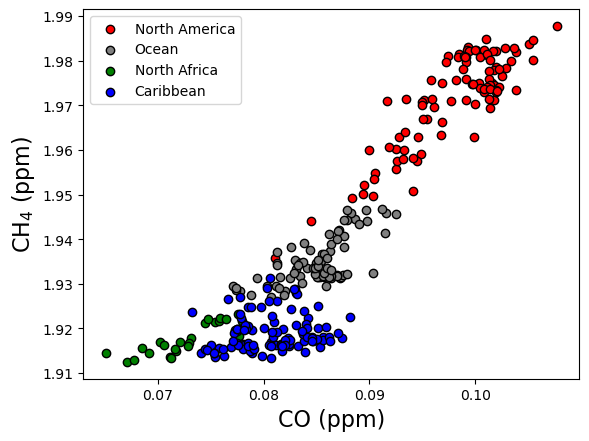

In [ ]:
fig, ax = plt.subplots()
ax.scatter(North_America_transport_plot['CO_ppm_DISKIN'], North_America_transport_plot['CH4_ppm_DISKIN'],
            color="red", label='North America', edgecolor='black')  # Add edgecolor parameter
ax.scatter(ocean_transport_plot['CO_ppm_DISKIN'], ocean_transport_plot['CH4_ppm_DISKIN'],
            color="grey", label='Ocean', edgecolor='black')  # Add edgecolor parameter
ax.scatter(Africa_transport_plot['CO_ppm_DISKIN'], Africa_transport_plot['CH4_ppm_DISKIN'],
            color="green", label='North Africa', edgecolor='black')  # Add edgecolor parameter
ax.scatter(Caribbean_transport_plot['CO_ppm_DISKIN'], Caribbean_transport_plot['CH4_ppm_DISKIN'],
            color="blue", label='Caribbean', edgecolor='black')  # Add edgecolor parameter
ax.set_ylabel(r'$\mathrm{CH_{4}}$ (ppm)', fontsize=16)
ax.set_xlabel('CO (ppm)', fontsize=16)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.legend()

plt.show()


In [ ]:
Africa_transport_cleaned = Africa_transport_plot.dropna(subset=['CO_ppm_DISKIN', 'CH4_ppm_DISKIN'])
North_America_transport_cleaned = North_America_transport_plot.dropna(subset=['CO_ppm_DISKIN', 'CH4_ppm_DISKIN'])
ocean_transport_cleaned = ocean_transport_plot.dropna(subset=['CO_ppm_DISKIN', 'CH4_ppm_DISKIN'])
Caribbean_transport_cleaned = Caribbean_transport_plot.dropna(subset=['CO_ppm_DISKIN', 'CH4_ppm_DISKIN'])

# Define the data points for each scatter plot
# Assuming you have data in arrays like 'North_America_transport_plot', 'ocean_transport_plot', etc.

x_na = North_America_transport_cleaned['CO_ppm_DISKIN']
y_na = North_America_transport_cleaned['CH4_ppm_DISKIN']

x_ocean = ocean_transport_cleaned['CO_ppm_DISKIN']
y_ocean = ocean_transport_cleaned['CH4_ppm_DISKIN']

x_africa = Africa_transport_cleaned['CO_ppm_DISKIN']
y_africa = Africa_transport_cleaned['CH4_ppm_DISKIN']

x_caribbean = Caribbean_transport_cleaned['CO_ppm_DISKIN']
y_caribbean = Caribbean_transport_cleaned['CH4_ppm_DISKIN']

# Perform linear regression using numpy's polyfit
slope_na, _ = np.polyfit(x_na, y_na, 1)
slope_ocean, _ = np.polyfit(x_ocean, y_ocean, 1)
slope_africa, _ = np.polyfit(x_africa, y_africa, 1)
slope_caribbean, _ = np.polyfit(x_caribbean, y_caribbean, 1)

# Print the slope values
print("Slope for North America:", slope_na)
print("Slope for Ocean:", slope_ocean)
print("Slope for North Africa:", slope_africa)
print("Slope for Caribbean:", slope_caribbean)


Slope for North America: 1.9017470841212532
Slope for Ocean: 1.1187379108530193
Slope for North Africa: 0.8372734339734234
Slope for Caribbean: 0.15237662344869818


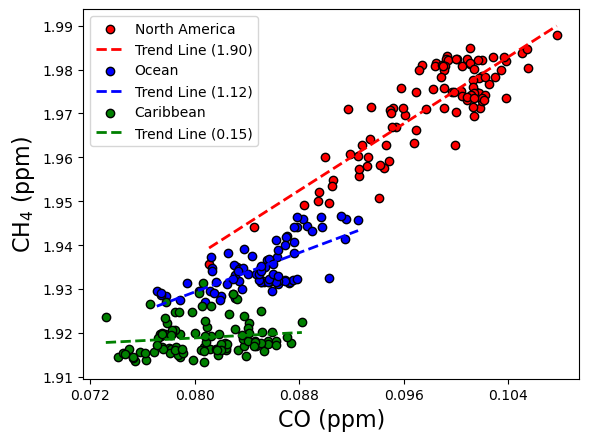

In [ ]:
# Assuming you have already cleaned your dataframes: 
# Africa_transport_cleaned, North_America_transport_cleaned, ocean_transport_cleaned, Caribbean_transport_cleaned

# Create a function to calculate and plot the trend line
def plot_trend_line(ax, x, y, color, label):
    # Fit a linear regression model to the data
    slope, intercept = np.polyfit(x, y, 1)
    
    # Calculate the trend line values
    trend_line_x = np.array([min(x), max(x)])
    trend_line_y = slope * trend_line_x + intercept
    
    # Scatter plot
    ax.scatter(x, y, color=color, label=label, edgecolor='black')
    
    # Trend line
    ax.plot(trend_line_x, trend_line_y, color=color, linestyle='--', linewidth=2, label=f'Trend Line ({slope:.2f})')

fig, ax = plt.subplots()

# Plot trend lines for each dataset
plot_trend_line(ax, North_America_transport_cleaned['CO_ppm_DISKIN'], North_America_transport_cleaned['CH4_ppm_DISKIN'],
                color="red", label='North America')
plot_trend_line(ax, ocean_transport_cleaned['CO_ppm_DISKIN'], ocean_transport_cleaned['CH4_ppm_DISKIN'],
                color="blue", label='Ocean')
plot_trend_line(ax, Caribbean_transport_cleaned['CO_ppm_DISKIN'], Caribbean_transport_cleaned['CH4_ppm_DISKIN'],
                color="green", label='Caribbean')

ax.set_ylabel(r'$\mathrm{CH_{4}}$ (ppm)', fontsize=16)
ax.set_xlabel('CO (ppm)', fontsize=16)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.legend()

plt.show()


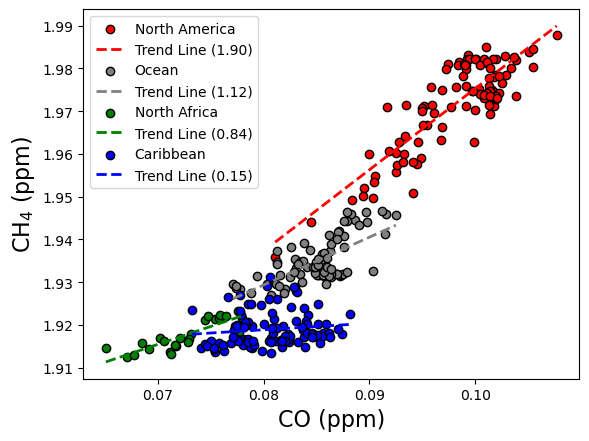

In [ ]:
# Assuming you have already cleaned your dataframes: 
# Africa_transport_cleaned, North_America_transport_cleaned, ocean_transport_cleaned, Caribbean_transport_cleaned

# Create a function to calculate and plot the trend line
def plot_trend_line(ax, x, y, color, label):
    # Fit a linear regression model to the data
    slope, intercept = np.polyfit(x, y, 1)
    
    # Calculate the trend line values
    trend_line_x = np.array([min(x), max(x)])
    trend_line_y = slope * trend_line_x + intercept
    
    # Scatter plot
    ax.scatter(x, y, color=color, label=label, edgecolor='black')
    
    # Trend line
    ax.plot(trend_line_x, trend_line_y, color=color, linestyle='--', linewidth=2, label=f'Trend Line ({slope:.2f})')

fig, ax = plt.subplots()

# Plot trend lines for each dataset
plot_trend_line(ax, North_America_transport_cleaned['CO_ppm_DISKIN'], North_America_transport_cleaned['CH4_ppm_DISKIN'],
                color="red", label='North America')
plot_trend_line(ax, ocean_transport_cleaned['CO_ppm_DISKIN'], ocean_transport_cleaned['CH4_ppm_DISKIN'],
                color="grey", label='Ocean')
plot_trend_line(ax, Africa_transport_cleaned['CO_ppm_DISKIN'], Africa_transport_cleaned['CH4_ppm_DISKIN'],
                color="green", label='North Africa')
plot_trend_line(ax, Caribbean_transport_cleaned['CO_ppm_DISKIN'], Caribbean_transport_cleaned['CH4_ppm_DISKIN'],
                color="blue", label='Caribbean')

ax.set_ylabel(r'$\mathrm{CH_{4}}$ (ppm)', fontsize=16)
ax.set_xlabel('CO (ppm)', fontsize=16)

ax.legend()

plt.show()


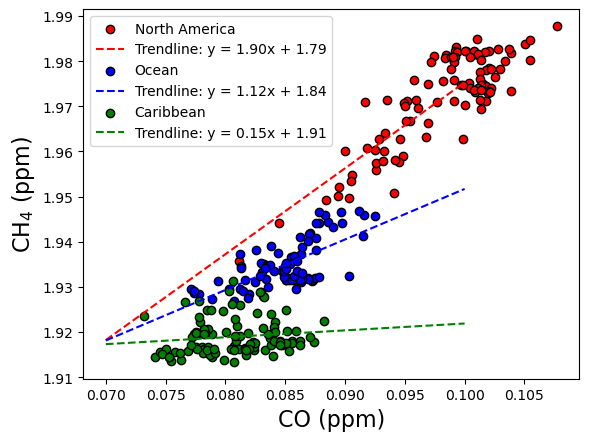

In [ ]:
# Create a function to calculate and plot the trend line
def plot_trend_line(ax, x, y, color, label):
    x = x.values.reshape(-1, 1)  # Convert to NumPy array and reshape
    y = y.values  # Convert to NumPy array
    # Fit a linear regression model to the data
    reg = LinearRegression().fit(x, y)
    # Calculate R-squared value
    r_squared = reg.score(x, y)
    # Calculate the trend line values
    x_fit = np.linspace(0.07, 0.1, 100)
    y_fit = reg.predict(x_fit.reshape(-1, 1))

    # Scatter plot
    ax.scatter(x, y, color=color, label=label, edgecolor='black')
    
    # Trend line
    ax.plot(x_fit, y_fit, color=color, linestyle='--', label=f'Trendline: y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}')

fig, ax = plt.subplots()

# Plot trend lines for each dataset
plot_trend_line(ax, North_America_transport_cleaned['CO_ppm_DISKIN'], North_America_transport_cleaned['CH4_ppm_DISKIN'],
                color="red", label='North America')
plot_trend_line(ax, ocean_transport_cleaned['CO_ppm_DISKIN'], ocean_transport_cleaned['CH4_ppm_DISKIN'],
                color="blue", label='Ocean')
plot_trend_line(ax, Caribbean_transport_cleaned['CO_ppm_DISKIN'], Caribbean_transport_cleaned['CH4_ppm_DISKIN'],
                color="green", label='Caribbean')

ax.set_ylabel(r'$\mathrm{CH_{4}}$ (ppm)', fontsize=16)
ax.set_xlabel('CO (ppm)', fontsize=16)

ax.legend()

plt.show()


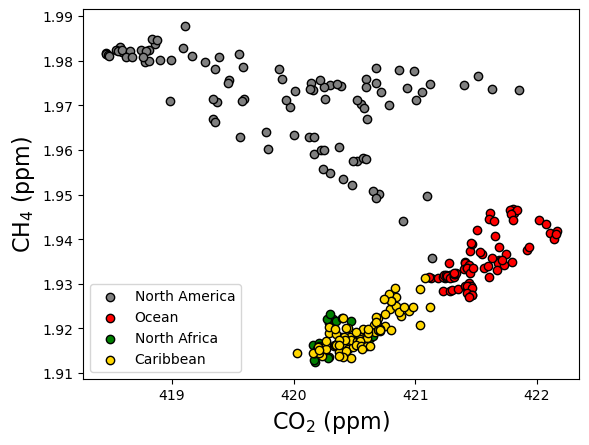

In [ ]:
fig, ax = plt.subplots()
# ax.plot(DAY11_subset_median['dewpoint'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color="green", label='Dewpoint')
ax.scatter(North_America_transport_plot['CO2_ppm_DISKIN'], North_America_transport_plot['CH4_ppm_DISKIN'],
            color="grey", label='North America', edgecolor='black')  # Add edgecolor parameter
ax.scatter(ocean_transport_plot['CO2_ppm_DISKIN'], ocean_transport_plot['CH4_ppm_DISKIN'],
            color="red", label='Ocean', edgecolor='black')  # Add edgecolor parameter
ax.scatter(Africa_transport_plot['CO2_ppm_DISKIN'], Africa_transport_plot['CH4_ppm_DISKIN'],
            color="green", label='North Africa', edgecolor='black')  # Add edgecolor parameter
ax.scatter(Caribbean_transport_plot['CO2_ppm_DISKIN'], Caribbean_transport_plot['CH4_ppm_DISKIN'],
            color="gold", label='Caribbean', edgecolor='black')  # Add edgecolor parameter
ax.set_ylabel(r'$\mathrm{CH_{4}}$ (ppm)', fontsize=16)
ax.set_xlabel(r'$\mathrm{CO_{2}}$ (ppm)', fontsize=16)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.legend()

plt.show()

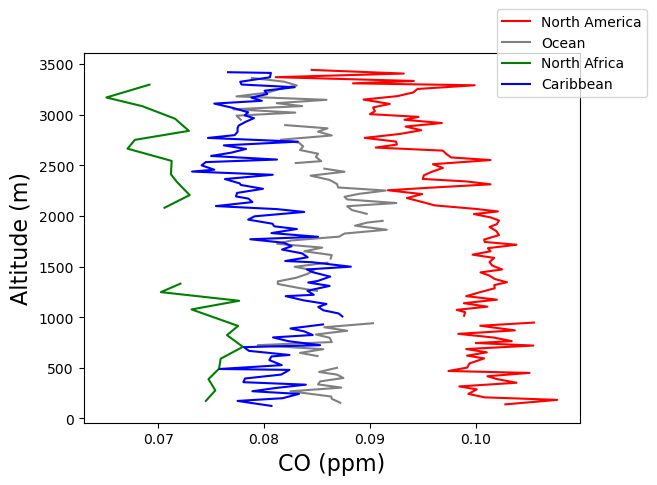

In [ ]:
fig,ax = plt.subplots()
#ax.plot(DAY11_subset_median['dewpoint'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(North_America_transport_plot['CO_ppm_DISKIN'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color = "red", label = 'North America')
ax.plot(ocean_transport_plot['CO_ppm_DISKIN'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color = "grey", label = 'Ocean')
ax.plot(Africa_transport_plot['CO_ppm_DISKIN'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color = "green", label = 'North Africa')
ax.plot(Caribbean_transport_plot['CO_ppm_DISKIN'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color = "blue", label = 'Caribbean')
ax.set_ylabel('Altitude (m)', fontsize = 16)
ax.set_xlabel('CO (ppm)', fontsize = 16)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')

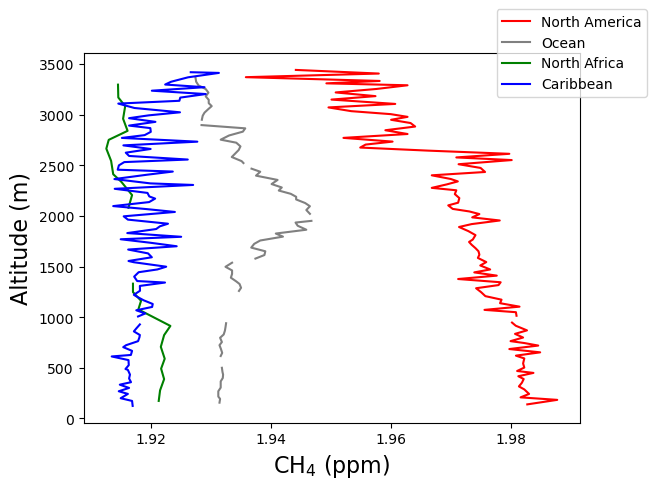

In [ ]:
fig,ax = plt.subplots()
#ax.plot(DAY11_subset_median['dewpoint'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(North_America_transport_plot['CH4_ppm_DISKIN'], North_America_transport_plot['GPS_Altitude_THORNHILL'], color = "red", label = 'North America')
ax.plot(ocean_transport_plot['CH4_ppm_DISKIN'], ocean_transport_plot['GPS_Altitude_THORNHILL'], color = "grey", label = 'Ocean')
ax.plot(Africa_transport_plot['CH4_ppm_DISKIN'], Africa_transport_plot['GPS_Altitude_THORNHILL'], color = "green", label = 'North Africa')
ax.plot(Caribbean_transport_plot['CH4_ppm_DISKIN'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], color = "blue", label = 'Caribbean')
ax.set_ylabel('Altitude (m)', fontsize = 16)
ax.set_xlabel(r'$\mathrm{CH_{4}}$ (ppm)' , fontsize = 16)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='medium')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.02, 0.98, '06/02 -06/17')

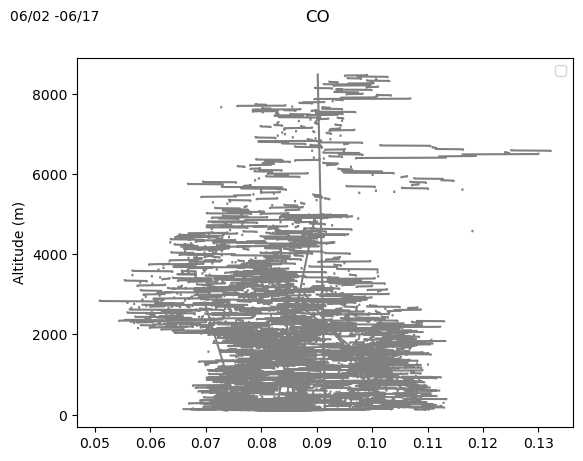

In [ ]:
fig,ax = plt.subplots()
#ax.plot(DAY11_subset_median['dewpoint'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(merged_df2['CO_ppm_DISKIN'], merged_df2['GPS_Altitude_THORNHILL'], color = "grAy")
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('CO', fontsize=12)
fig.text(0.02, 0.98, '06/02 -06/17', ha='left', va='top', fontsize=10)

In [ ]:
nbins = 1000
bins = np.linspace(merged_df2.GPS_Altitude_THORNHILL.min(), merged_df2.GPS_Altitude_THORNHILL.max(), nbins+1)
merged_df2['Bins'] = pd.cut(merged_df2['GPS_Altitude_THORNHILL'], bins)
merged_df2_2 = ocean_transport.groupby('Bins').mean()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.02, 0.98, '06/02 -06/17')

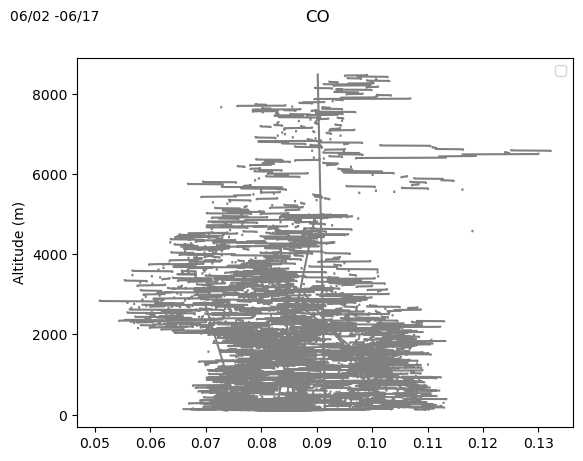

In [ ]:
fig,ax = plt.subplots()
#ax.plot(DAY11_subset_median['dewpoint'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(merged_df2['CO_ppm_DISKIN'], merged_df2['GPS_Altitude_THORNHILL'], color = "grAy")
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('CO', fontsize=12)
fig.text(0.02, 0.98, '06/02 -06/17', ha='left', va='top', fontsize=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.02, 0.98, '06/02 -06/17')

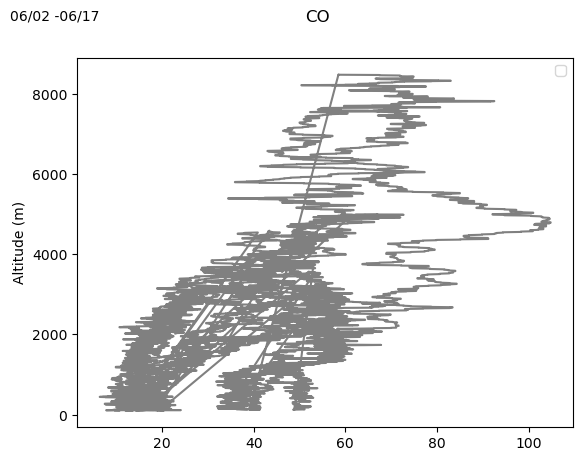

In [ ]:
fig,ax = plt.subplots()
#ax.plot(DAY11_subset_median['dewpoint'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(merged_df2['O3_ppbv_DISKIN'], merged_df2['GPS_Altitude_THORNHILL'], color = "grAy")
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('CO', fontsize=12)
fig.text(0.02, 0.98, '06/02 -06/17', ha='left', va='top', fontsize=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.02, 0.98, '06/02 -06/17')

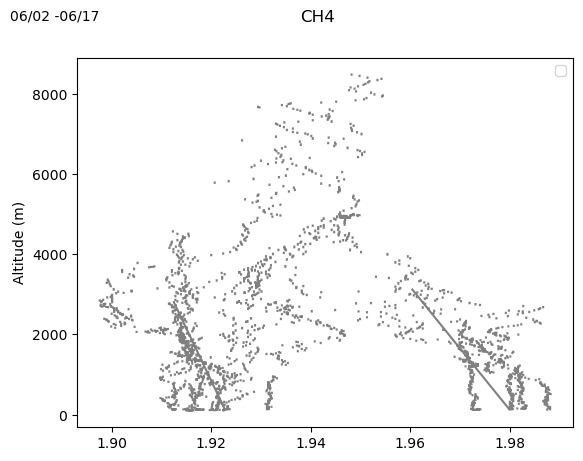

In [ ]:
fig,ax = plt.subplots()
#ax.plot(DAY11_subset_median['dewpoint'], DAY11_subset_median['GPS_Altitude_THORNHILL'], color = "green", label = 'Dewpoint')
ax.plot(merged_df2['CH4_ppm_DISKIN'], merged_df2['GPS_Altitude_THORNHILL'], color = "grey")
ax.plot(merged_df2['CH4_ppm_DISKIN'].mean(), merged_df2['GPS_Altitude_THORNHILL'].mean(), color = "blue")
ax.set_ylabel('Altitude (m)')
ax.legend()
fig.suptitle('CH4', fontsize=12)
fig.text(0.02, 0.98, '06/02 -06/17', ha='left', va='top', fontsize=10)

In [ ]:
# Concatenate the dataframes vertically (along rows)
merged_df = pd.concat([Caribbean.describe(), Caribbean2.describe(), North_America.describe(), North_America2.describe(), ocean.describe(), ocean2.describe(), Africa.describe(), DAY14_subset_3000.describe()], axis=0)

# Reset the index of the merged dataframe
merged_df.reset_index(drop=False, inplace=True)

# Display the merged dataframe
merged_df
merged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/AES_description_median.csv')